In [409]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS, Predictive, EmpiricalMarginal
from pyro.infer.autoguide import init_to_mean, init_to_median, init_to_value
from pyro.infer.inspect import get_dependencies
import gempy as gp
import gempy_engine
import gempy_viewer as gpv
from gempy_engine.core.backend_tensor import BackendTensor
import arviz as az
from gempy_probability.plot_posterior import default_red, default_blue, PlotPosterior

[ 0  1 10 11 12 13 14]
[0 1 2 3 4 5 6]
(83, 86)


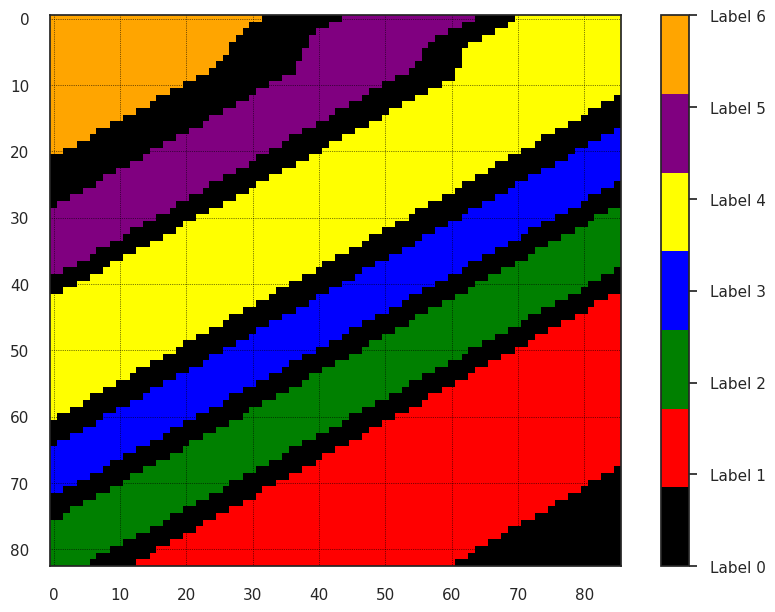

[[6 6 6 ... 4 4 4]
 [6 6 6 ... 4 4 4]
 [6 6 6 ... 4 4 4]
 ...
 [2 2 2 ... 0 0 0]
 [2 2 2 ... 0 0 0]
 [2 2 2 ... 0 0 0]]


In [410]:
import scipy.io

# Load .mat file
SalinasA= np.array(scipy.io.loadmat('./HSI_Salinas/SalinasA.mat')['salinasA'])
SalinasA_corrected= np.array(scipy.io.loadmat('./HSI_Salinas/SalinasA_corrected.mat')['salinasA_corrected'])
SalinasA_gt= np.array(scipy.io.loadmat('./HSI_Salinas/SalinasA_gt.mat')['salinasA_gt'])

i=0
label_data = [0,6,1,5,4,3,2]
print(np.unique(SalinasA_gt))
for ele in np.unique(SalinasA_gt):
    #print(ele)
    mask = SalinasA_gt==ele
    SalinasA_gt[mask] = label_data[i]
    #print(SalinasA_gt)
    i=i+1
    #print(i+1)
print(np.unique(SalinasA_gt))

print(SalinasA_gt.shape)
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
# Define a colormap with colors for each label
colors = ['black', 'red', 'green', 'blue', 'yellow', 'purple', 'orange']
cmap = ListedColormap(colors)

plt.imshow(SalinasA_gt, cmap=cmap, vmin=0, vmax=len(colors)-1)

# Add colorbar to show label-color mapping
cbar = plt.colorbar(ticks=np.arange(len(colors)))
cbar.set_ticklabels([f'Label {i}' for i in range(len(colors))])
# Add a label at a specific coordinate (e.g., x=5, y=5)
#label_text = "A"
#plt.text(20, 10, label_text, color='red', fontsize=4, ha='center', va='center')
# Set ticks to align with individual pixels
#plt.xticks(np.arange(0.0, 87.0, 1), [])
#plt.yticks(np.arange(0.0, 84.0, 1), [])
plt.grid(True, which='both', color='black', linewidth=0.5, linestyle=':')
plt.show()
print(SalinasA_gt)

In [411]:
SalinasA_gt.shape, SalinasA_corrected.shape

((83, 86), (83, 86, 204))

In [412]:
H, W = SalinasA_gt.shape
data_hsi = torch.zeros((H*W, 208 ))
for i in range(H):
    for j in range(W):
        data_hsi[i*W+j,0] = j
        data_hsi[i*W +j,2] = - i
        data_hsi[i*W +j,3] = SalinasA_gt[i,j]
        data_hsi[i*W +j,4:] = torch.tensor(SalinasA_corrected[i,j,:],dtype=torch.float64)
data_hsi


tensor([[  0.,   0.,   0.,  ...,   4.,   1.,   2.],
        [  1.,   0.,   0.,  ...,   0.,  -2.,  -9.],
        [  2.,   0.,   0.,  ...,   0.,   1.,   8.],
        ...,
        [ 83.,   0., -82.,  ...,  69.,  25.,  35.],
        [ 84.,   0., -82.,  ...,  63.,  27.,  39.],
        [ 85.,   0., -82.,  ...,  63.,  19.,  41.]])

In [413]:
column_name=["X","Y","Z", "Label"]
for i in range(SalinasA_corrected.shape[2]):
    column_name.append("feature_"+str(i+1))

In [414]:
import pandas as pd 
df_hsi = pd.DataFrame(data_hsi,columns=column_name)
df_hsi

X    Y     Z  Label  feature_1  feature_2  feature_3  feature_4  \
0      0.0  0.0   0.0    6.0      376.0      481.0      665.0     1086.0   
1      1.0  0.0   0.0    6.0      447.0      481.0      731.0     1086.0   
2      2.0  0.0   0.0    6.0      519.0      564.0      731.0     1128.0   
3      3.0  0.0   0.0    6.0      305.0      481.0      731.0     1128.0   
4      4.0  0.0   0.0    6.0      376.0      564.0      665.0     1128.0   
...    ...  ...   ...    ...        ...        ...        ...        ...   
7133  81.0  0.0 -82.0    0.0      365.0      558.0      662.0     1214.0   
7134  82.0  0.0 -82.0    0.0      365.0      558.0      859.0     1342.0   
7135  83.0  0.0 -82.0    0.0      508.0      558.0      793.0     1342.0   
7136  84.0  0.0 -82.0    0.0      436.0      558.0      793.0     1299.0   
7137  85.0  0.0 -82.0    0.0      365.0      474.0      728.0     1256.0   

      feature_5  feature_6  ...  feature_195  feature_196  feature_197  \
0        1378.0     1399.0  ...         18.0         14.0         20.0   
1        1378.0     1444.0  ...         15.0         12.0         10.0   
2        1407.0     1444.0  ...         20.0         19.0         20.0   
3        1378.0     1467.0  ...         22.0         21.0         22.0   
4        1437.0     1444.0  ...         20.0         10.0         16.0   
...         ...        ...  ...          ...          ...          ...   
7133     1579.0     1670.0  ...        208.0        183.0        225.0   
7134     1608.0     1692.0  ...        210.0        190.0        225.0   
7135     1667.0     1715.0  ...        219.0        196.0        232.0   
7136     1608.0     1738.0  ...        214.0        188.0        230.0   
7137     1608.0     1670.0  ...        217.0        194.0        223.0   

      feature_198  feature_199  feature_200  feature_201  feature_202  \
0            12.0         11.0         10.0          9.0          4.0   
1             8.0          5.0          4.0          5.0          0.0   
2            20.0          7.0         14.0          9.0          0.0   
3            18.0          9.0         18.0          7.0          6.0   
4             8.0          7.0         10.0          5.0          4.0   
...           ...          ...          ...          ...          ...   
7133        185.0        113.0        165.0        114.0         65.0   
7134        187.0        119.0        171.0        114.0         65.0   
7135        196.0        115.0        175.0        126.0         69.0   
7136        198.0        124.0        179.0        118.0         63.0   
7137        191.0        115.0        165.0        120.0         63.0   

      feature_203  feature_204  
0             1.0          2.0  
1            -2.0         -9.0  
2             1.0          8.0  
3             3.0          2.0  
4             3.0          2.0  
...           ...          ...  
7133         19.0         39.0  
7134         21.0         35.0  
7135         25.0         35.0  
7136         27.0         39.0  
7137         19.0         41.0  

[7138 rows x 208 columns]

In [415]:
data_= df_hsi.loc[(df_hsi["Label"]!=0) &(df_hsi["X"]==20)]
data_.iloc[:, 4:] = data_.iloc[:, 4:].apply(zscore,axis=1)
data_

/tmp/jt925938/login23-3_27217/ipykernel_153992/904556869.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_.iloc[:, 4:] = data_.iloc[:, 4:].apply(zscore,axis=1)


X    Y     Z  Label  feature_1  feature_2  feature_3  feature_4  \
20    20.0  0.0   0.0    6.0  -0.562609  -0.511429  -0.389573  -0.216538   
106   20.0  0.0  -1.0    6.0  -0.568452  -0.504367  -0.410212  -0.209085   
192   20.0  0.0  -2.0    6.0  -0.568452  -0.504367  -0.410212  -0.209085   
278   20.0  0.0  -3.0    6.0  -0.526721  -0.468027  -0.415203  -0.208797   
364   20.0  0.0  -4.0    6.0  -0.526721  -0.468027  -0.415203  -0.208797   
450   20.0  0.0  -5.0    6.0  -0.526721  -0.468027  -0.415203  -0.208797   
536   20.0  0.0  -6.0    6.0  -0.553241  -0.494724  -0.436207  -0.195253   
622   20.0  0.0  -7.0    6.0  -0.553241  -0.494724  -0.436207  -0.195253   
708   20.0  0.0  -8.0    6.0  -0.553241  -0.494724  -0.436207  -0.195253   
794   20.0  0.0  -9.0    6.0  -0.554530  -0.500776  -0.413905  -0.187850   
1568  20.0  0.0 -18.0    5.0  -0.921532  -0.893106  -0.612128  -0.039241   
1654  20.0  0.0 -19.0    5.0  -0.922917  -0.797842  -0.553843  -0.040214   
1740  20.0  0.0 -20.0    5.0  -0.982851  -0.960811  -0.606079  -0.055089   
1826  20.0  0.0 -21.0    5.0  -0.982851  -0.960811  -0.606079  -0.055089   
1912  20.0  0.0 -22.0    5.0  -0.990318  -0.889540  -0.542987  -0.034984   
1998  20.0  0.0 -23.0    5.0  -0.909239  -0.788985  -0.611218   0.032924   
2084  20.0  0.0 -24.0    5.0  -0.890042  -0.855056  -0.522689  -0.005552   
2170  20.0  0.0 -25.0    5.0  -0.890042  -0.855056  -0.522689  -0.005552   
2256  20.0  0.0 -26.0    5.0  -0.982370  -0.778010  -0.521767   0.012955   
2342  20.0  0.0 -27.0    5.0  -0.945744  -0.905147  -0.596806  -0.068083   
2686  20.0  0.0 -31.0    4.0  -0.765818  -0.712447  -0.347746   0.127510   
2772  20.0  0.0 -32.0    4.0  -0.957108  -0.834283  -0.510928   0.043037   
2858  20.0  0.0 -33.0    4.0  -0.960950  -0.828991  -0.589181   0.045237   
2944  20.0  0.0 -34.0    4.0  -0.960950  -0.828991  -0.589181   0.045237   
3030  20.0  0.0 -35.0    4.0  -0.987885  -0.735025  -0.519718   0.024809   
3116  20.0  0.0 -36.0    4.0  -0.967776  -0.824719  -0.694102  -0.023599   
3202  20.0  0.0 -37.0    4.0  -0.967776  -0.824719  -0.694102  -0.023599   
3288  20.0  0.0 -38.0    4.0  -0.978608  -0.844922  -0.530511   0.014138   
3374  20.0  0.0 -39.0    4.0  -1.000976  -0.768983  -0.566432  -0.044744   
3460  20.0  0.0 -40.0    4.0  -1.000976  -0.768983  -0.566432  -0.044744   
3546  20.0  0.0 -41.0    4.0  -0.883802  -0.723811  -0.619111   0.014970   
3632  20.0  0.0 -42.0    4.0  -0.964964  -0.851888  -0.549558   0.038439   
3718  20.0  0.0 -43.0    4.0  -0.964964  -0.851888  -0.549558   0.038439   
3804  20.0  0.0 -44.0    4.0  -0.952863  -0.914531  -0.543983  -0.018944   
3890  20.0  0.0 -45.0    4.0  -0.876725  -0.719763  -0.528830  -0.067313   
3976  20.0  0.0 -46.0    4.0  -0.955297  -0.937934  -0.554790  -0.035055   
4062  20.0  0.0 -47.0    4.0  -0.955297  -0.937934  -0.554790  -0.035055   
4148  20.0  0.0 -48.0    4.0  -1.056645  -0.855392  -0.556422  -0.041075   
4664  20.0  0.0 -54.0    3.0  -0.848984  -0.585308  -0.497416  -0.105358   
4750  20.0  0.0 -55.0    3.0  -0.914502  -0.822214  -0.542306  -0.083907   
4836  20.0  0.0 -56.0    3.0  -0.930966  -0.743255  -0.559647  -0.031391   
4922  20.0  0.0 -57.0    3.0  -0.930966  -0.743255  -0.559647  -0.031391   
5008  20.0  0.0 -58.0    3.0  -0.843135  -0.665591  -0.550289  -0.083980   
5094  20.0  0.0 -59.0    3.0  -0.860351  -0.652516  -0.554537  -0.095321   
5180  20.0  0.0 -60.0    3.0  -0.860351  -0.652516  -0.554537  -0.095321   
5610  20.0  0.0 -65.0    2.0  -0.756670  -0.673381  -0.569854  -0.225022   
5696  20.0  0.0 -66.0    2.0  -0.756670  -0.673381  -0.569854  -0.225022   
5782  20.0  0.0 -67.0    2.0  -0.755366  -0.659141  -0.519971  -0.218570   
5868  20.0  0.0 -68.0    2.0  -0.841233  -0.739952  -0.576274  -0.191946   
5954  20.0  0.0 -69.0    2.0  -0.841233  -0.739952  -0.576274  -0.191946   
6040  20.0  0.0 -70.0    2.0  -0.809970  -0.719734  -0.552531  -0.144700   
6126  20.0  0.0 -71.0    2.0  -0.809970  -0.719734  -0.55

In [416]:
df_with_non_labelled_pixel = df_hsi.loc[df_hsi['Label']!=0]
#df_with_non_labelled_pixel

In [417]:
#df_with_x_20 = df_with_non_labelled_pixel.loc[df_with_non_labelled_pixel["X"]==20]
#df_with_x_20

In [418]:
# Normalise along the spectral lines 
df_with_spectral_normalised = df_with_non_labelled_pixel
df_with_spectral_normalised.iloc[:, 4:] = df_with_spectral_normalised.iloc[:, 4:].apply(zscore,axis=1)

/tmp/jt925938/login23-3_27217/ipykernel_153992/1956606123.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_spectral_normalised.iloc[:, 4:] = df_with_spectral_normalised.iloc[:, 4:].apply(zscore,axis=1)


In [419]:
df_with_spectral_normalised.loc[df_with_spectral_normalised["X"]==20]

X    Y     Z  Label  feature_1  feature_2  feature_3  feature_4  \
20    20.0  0.0   0.0    6.0  -0.562609  -0.511429  -0.389573  -0.216538   
106   20.0  0.0  -1.0    6.0  -0.568452  -0.504367  -0.410212  -0.209085   
192   20.0  0.0  -2.0    6.0  -0.568452  -0.504367  -0.410212  -0.209085   
278   20.0  0.0  -3.0    6.0  -0.526721  -0.468027  -0.415203  -0.208797   
364   20.0  0.0  -4.0    6.0  -0.526721  -0.468027  -0.415203  -0.208797   
450   20.0  0.0  -5.0    6.0  -0.526721  -0.468027  -0.415203  -0.208797   
536   20.0  0.0  -6.0    6.0  -0.553241  -0.494724  -0.436207  -0.195253   
622   20.0  0.0  -7.0    6.0  -0.553241  -0.494724  -0.436207  -0.195253   
708   20.0  0.0  -8.0    6.0  -0.553241  -0.494724  -0.436207  -0.195253   
794   20.0  0.0  -9.0    6.0  -0.554530  -0.500776  -0.413905  -0.187850   
1568  20.0  0.0 -18.0    5.0  -0.921532  -0.893106  -0.612128  -0.039241   
1654  20.0  0.0 -19.0    5.0  -0.922917  -0.797842  -0.553843  -0.040214   
1740  20.0  0.0 -20.0    5.0  -0.982851  -0.960811  -0.606079  -0.055089   
1826  20.0  0.0 -21.0    5.0  -0.982851  -0.960811  -0.606079  -0.055089   
1912  20.0  0.0 -22.0    5.0  -0.990318  -0.889540  -0.542987  -0.034984   
1998  20.0  0.0 -23.0    5.0  -0.909239  -0.788985  -0.611218   0.032924   
2084  20.0  0.0 -24.0    5.0  -0.890042  -0.855056  -0.522689  -0.005552   
2170  20.0  0.0 -25.0    5.0  -0.890042  -0.855056  -0.522689  -0.005552   
2256  20.0  0.0 -26.0    5.0  -0.982370  -0.778010  -0.521767   0.012955   
2342  20.0  0.0 -27.0    5.0  -0.945744  -0.905147  -0.596806  -0.068083   
2686  20.0  0.0 -31.0    4.0  -0.765818  -0.712447  -0.347746   0.127510   
2772  20.0  0.0 -32.0    4.0  -0.957108  -0.834283  -0.510928   0.043037   
2858  20.0  0.0 -33.0    4.0  -0.960950  -0.828991  -0.589181   0.045237   
2944  20.0  0.0 -34.0    4.0  -0.960950  -0.828991  -0.589181   0.045237   
3030  20.0  0.0 -35.0    4.0  -0.987885  -0.735025  -0.519718   0.024809   
3116  20.0  0.0 -36.0    4.0  -0.967776  -0.824719  -0.694102  -0.023599   
3202  20.0  0.0 -37.0    4.0  -0.967776  -0.824719  -0.694102  -0.023599   
3288  20.0  0.0 -38.0    4.0  -0.978608  -0.844922  -0.530511   0.014138   
3374  20.0  0.0 -39.0    4.0  -1.000976  -0.768983  -0.566432  -0.044744   
3460  20.0  0.0 -40.0    4.0  -1.000976  -0.768983  -0.566432  -0.044744   
3546  20.0  0.0 -41.0    4.0  -0.883802  -0.723811  -0.619111   0.014970   
3632  20.0  0.0 -42.0    4.0  -0.964964  -0.851888  -0.549558   0.038439   
3718  20.0  0.0 -43.0    4.0  -0.964964  -0.851888  -0.549558   0.038439   
3804  20.0  0.0 -44.0    4.0  -0.952863  -0.914531  -0.543983  -0.018944   
3890  20.0  0.0 -45.0    4.0  -0.876725  -0.719763  -0.528830  -0.067313   
3976  20.0  0.0 -46.0    4.0  -0.955297  -0.937934  -0.554790  -0.035055   
4062  20.0  0.0 -47.0    4.0  -0.955297  -0.937934  -0.554790  -0.035055   
4148  20.0  0.0 -48.0    4.0  -1.056645  -0.855392  -0.556422  -0.041075   
4664  20.0  0.0 -54.0    3.0  -0.848984  -0.585308  -0.497416  -0.105358   
4750  20.0  0.0 -55.0    3.0  -0.914502  -0.822214  -0.542306  -0.083907   
4836  20.0  0.0 -56.0    3.0  -0.930966  -0.743255  -0.559647  -0.031391   
4922  20.0  0.0 -57.0    3.0  -0.930966  -0.743255  -0.559647  -0.031391   
5008  20.0  0.0 -58.0    3.0  -0.843135  -0.665591  -0.550289  -0.083980   
5094  20.0  0.0 -59.0    3.0  -0.860351  -0.652516  -0.554537  -0.095321   
5180  20.0  0.0 -60.0    3.0  -0.860351  -0.652516  -0.554537  -0.095321   
5610  20.0  0.0 -65.0    2.0  -0.756670  -0.673381  -0.569854  -0.225022   
5696  20.0  0.0 -66.0    2.0  -0.756670  -0.673381  -0.569854  -0.225022   
5782  20.0  0.0 -67.0    2.0  -0.755366  -0.659141  -0.519971  -0.218570   
5868  20.0  0.0 -68.0    2.0  -0.841233  -0.739952  -0.576274  -0.191946   
5954  20.0  0.0 -69.0    2.0  -0.841233  -0.739952  -0.576274  -0.191946   
6040  20.0  0.0 -70.0    2.0  -0.809970  -0.719734  -0.552531  -0.144700   
6126  20.0  0.0 -71.0    2.0  -0.809970  -0.719734  -0.55

In [420]:
column = 20
y_obs = torch.tensor(SalinasA_gt[:,column], dtype=torch.float64)
#print(y_obs, y_obs.shape)
mask = y_obs!=0
#print(mask)
y_obs_label = y_obs[mask]
#print(y_obs_label)
#print(SalinasA_corrected.shape)
y_obs_hsi = torch.tensor(SalinasA_corrected[:,column,:], dtype=torch.float64)[mask]
y_obs_hsi.shape

torch.Size([59, 204])

In [421]:
y_obs_hsi

tensor([[376., 481., 731.,  ...,   2.,   0.,   0.],
        [363., 493., 684.,  ...,   6.,   1.,   0.],
        [363., 493., 684.,  ...,   6.,   1.,   0.],
        ...,
        [376., 392., 599.,  ...,  30.,  12.,  19.],
        [294., 307., 597.,  ...,  33.,  13.,  21.],
        [294., 307., 597.,  ...,  33.,  13.,  21.]], dtype=torch.float64)

In [422]:
df = df_with_spectral_normalised.loc[df_with_spectral_normalised["X"]==20]
df

X    Y     Z  Label  feature_1  feature_2  feature_3  feature_4  \
20    20.0  0.0   0.0    6.0  -0.562609  -0.511429  -0.389573  -0.216538   
106   20.0  0.0  -1.0    6.0  -0.568452  -0.504367  -0.410212  -0.209085   
192   20.0  0.0  -2.0    6.0  -0.568452  -0.504367  -0.410212  -0.209085   
278   20.0  0.0  -3.0    6.0  -0.526721  -0.468027  -0.415203  -0.208797   
364   20.0  0.0  -4.0    6.0  -0.526721  -0.468027  -0.415203  -0.208797   
450   20.0  0.0  -5.0    6.0  -0.526721  -0.468027  -0.415203  -0.208797   
536   20.0  0.0  -6.0    6.0  -0.553241  -0.494724  -0.436207  -0.195253   
622   20.0  0.0  -7.0    6.0  -0.553241  -0.494724  -0.436207  -0.195253   
708   20.0  0.0  -8.0    6.0  -0.553241  -0.494724  -0.436207  -0.195253   
794   20.0  0.0  -9.0    6.0  -0.554530  -0.500776  -0.413905  -0.187850   
1568  20.0  0.0 -18.0    5.0  -0.921532  -0.893106  -0.612128  -0.039241   
1654  20.0  0.0 -19.0    5.0  -0.922917  -0.797842  -0.553843  -0.040214   
1740  20.0  0.0 -20.0    5.0  -0.982851  -0.960811  -0.606079  -0.055089   
1826  20.0  0.0 -21.0    5.0  -0.982851  -0.960811  -0.606079  -0.055089   
1912  20.0  0.0 -22.0    5.0  -0.990318  -0.889540  -0.542987  -0.034984   
1998  20.0  0.0 -23.0    5.0  -0.909239  -0.788985  -0.611218   0.032924   
2084  20.0  0.0 -24.0    5.0  -0.890042  -0.855056  -0.522689  -0.005552   
2170  20.0  0.0 -25.0    5.0  -0.890042  -0.855056  -0.522689  -0.005552   
2256  20.0  0.0 -26.0    5.0  -0.982370  -0.778010  -0.521767   0.012955   
2342  20.0  0.0 -27.0    5.0  -0.945744  -0.905147  -0.596806  -0.068083   
2686  20.0  0.0 -31.0    4.0  -0.765818  -0.712447  -0.347746   0.127510   
2772  20.0  0.0 -32.0    4.0  -0.957108  -0.834283  -0.510928   0.043037   
2858  20.0  0.0 -33.0    4.0  -0.960950  -0.828991  -0.589181   0.045237   
2944  20.0  0.0 -34.0    4.0  -0.960950  -0.828991  -0.589181   0.045237   
3030  20.0  0.0 -35.0    4.0  -0.987885  -0.735025  -0.519718   0.024809   
3116  20.0  0.0 -36.0    4.0  -0.967776  -0.824719  -0.694102  -0.023599   
3202  20.0  0.0 -37.0    4.0  -0.967776  -0.824719  -0.694102  -0.023599   
3288  20.0  0.0 -38.0    4.0  -0.978608  -0.844922  -0.530511   0.014138   
3374  20.0  0.0 -39.0    4.0  -1.000976  -0.768983  -0.566432  -0.044744   
3460  20.0  0.0 -40.0    4.0  -1.000976  -0.768983  -0.566432  -0.044744   
3546  20.0  0.0 -41.0    4.0  -0.883802  -0.723811  -0.619111   0.014970   
3632  20.0  0.0 -42.0    4.0  -0.964964  -0.851888  -0.549558   0.038439   
3718  20.0  0.0 -43.0    4.0  -0.964964  -0.851888  -0.549558   0.038439   
3804  20.0  0.0 -44.0    4.0  -0.952863  -0.914531  -0.543983  -0.018944   
3890  20.0  0.0 -45.0    4.0  -0.876725  -0.719763  -0.528830  -0.067313   
3976  20.0  0.0 -46.0    4.0  -0.955297  -0.937934  -0.554790  -0.035055   
4062  20.0  0.0 -47.0    4.0  -0.955297  -0.937934  -0.554790  -0.035055   
4148  20.0  0.0 -48.0    4.0  -1.056645  -0.855392  -0.556422  -0.041075   
4664  20.0  0.0 -54.0    3.0  -0.848984  -0.585308  -0.497416  -0.105358   
4750  20.0  0.0 -55.0    3.0  -0.914502  -0.822214  -0.542306  -0.083907   
4836  20.0  0.0 -56.0    3.0  -0.930966  -0.743255  -0.559647  -0.031391   
4922  20.0  0.0 -57.0    3.0  -0.930966  -0.743255  -0.559647  -0.031391   
5008  20.0  0.0 -58.0    3.0  -0.843135  -0.665591  -0.550289  -0.083980   
5094  20.0  0.0 -59.0    3.0  -0.860351  -0.652516  -0.554537  -0.095321   
5180  20.0  0.0 -60.0    3.0  -0.860351  -0.652516  -0.554537  -0.095321   
5610  20.0  0.0 -65.0    2.0  -0.756670  -0.673381  -0.569854  -0.225022   
5696  20.0  0.0 -66.0    2.0  -0.756670  -0.673381  -0.569854  -0.225022   
5782  20.0  0.0 -67.0    2.0  -0.755366  -0.659141  -0.519971  -0.218570   
5868  20.0  0.0 -68.0    2.0  -0.841233  -0.739952  -0.576274  -0.191946   
5954  20.0  0.0 -69.0    2.0  -0.841233  -0.739952  -0.576274  -0.191946   
6040  20.0  0.0 -70.0    2.0  -0.809970  -0.719734  -0.552531  -0.144700   
6126  20.0  0.0 -71.0    2.0  -0.809970  -0.719734  -0.55

In [423]:
normalised_hsi = zscore(y_obs_hsi, axis=1)
normalised_hsi

tensor([[-0.5626, -0.5114, -0.3896,  ..., -0.7449, -0.7459, -0.7459],
        [-0.5685, -0.5044, -0.4102,  ..., -0.7444, -0.7469, -0.7474],
        [-0.5685, -0.5044, -0.4102,  ..., -0.7444, -0.7469, -0.7474],
        ...,
        [-0.8599, -0.8409, -0.5959,  ..., -1.2695, -1.2908, -1.2825],
        [-0.9617, -0.9464, -0.6054,  ..., -1.2686, -1.2921, -1.2827],
        [-0.9617, -0.9464, -0.6054,  ..., -1.2686, -1.2921, -1.2827]],
       dtype=torch.float64)

In [424]:
normalised_hsi.shape

torch.Size([59, 204])

In [405]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0)
transformed_hsi = model.fit_transform(normalised_hsi) 

In [406]:
transformed_hsi.shape

(59, 2)

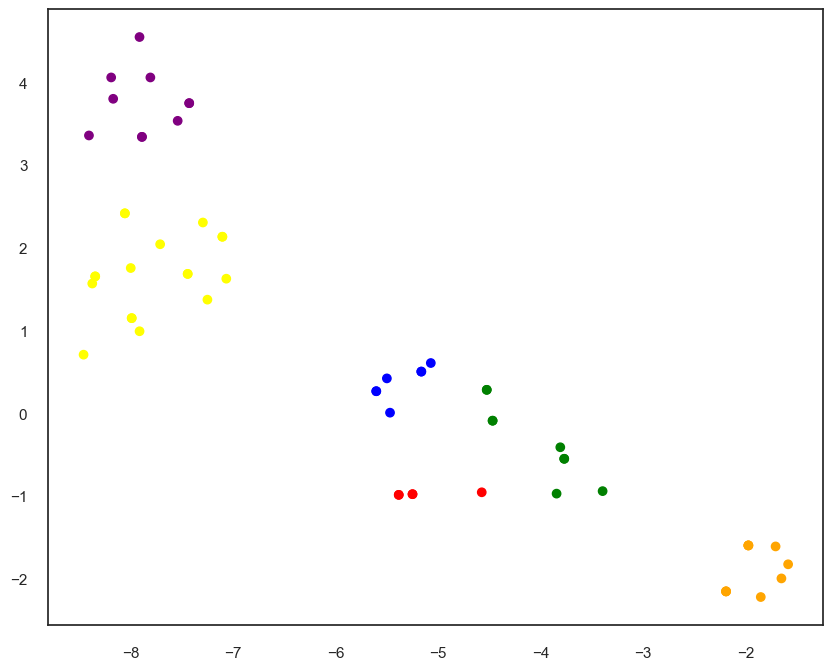

In [212]:
plt.figure(figsize=(10,8))
plt.scatter(transformed_hsi[:,0],transformed_hsi[:,1],c=y_obs_label, cmap=ListedColormap(colors[1:]))


In [213]:
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture
from sklearn.cluster import KMeans

In [214]:
gm =gm = BayesianGaussianMixture(n_components=6, random_state=0).fit(normalised_hsi)


In [215]:
gm.means_ , gm.covariances_

(array([[ 0.12906035,  0.1155815 ,  0.33734788, ...,  0.77531731,
          0.76816842,  0.84472794],
        [ 0.18750484,  0.28361056, -0.45802284, ..., -1.67492865,
         -1.66013405, -1.68724715],
        [-0.48508197,  0.38624935, -0.18674731, ...,  0.13609434,
          0.28936361, -0.0193617 ],
        [ 0.77918679, -0.00223609,  1.17668411, ...,  0.73870179,
          0.5167549 ,  0.60836502],
        [-0.71043501, -1.38776467, -1.20770212, ..., -0.51419992,
         -0.33558663, -0.44939526],
        [-0.50036014, -0.26659532, -0.80461718, ..., -0.49674434,
         -0.57947882, -0.20890256]]),
 array([[[ 8.07089627e-02,  2.92026420e-02,  2.41252374e-02, ...,
          -4.61119695e-03, -7.86197985e-03, -1.24713396e-02],
         [ 2.92026420e-02,  6.70776355e-02,  8.03313904e-03, ...,
           3.99060374e-03,  1.96382861e-04, -4.70664905e-03],
         [ 2.41252374e-02,  8.03313904e-03,  6.28652615e-02, ...,
          -2.20090474e-03,  1.20987207e-02,  1.51816101e-03],
  

In [216]:
gmm_label = gm.predict(normalised_hsi) +1 
gmm_label

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3,
       3, 6, 6, 6, 3, 3, 3, 3, 6, 6, 5, 5, 5, 5, 5])

In [217]:
y_obs_label

tensor([6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 5., 5., 5., 5., 5., 5., 5., 5.,
        5., 5., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
        4., 4., 3., 3., 3., 3., 3., 3., 3., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        1., 1., 1., 1., 1.], dtype=torch.float64)

In [218]:
gmm_label2 = torch.zeros_like(y_obs_label)
gmm_label2[gmm_label==2]=6
gmm_label2[gmm_label==4]=5
gmm_label2[gmm_label==1]=4
gmm_label2[gmm_label==3]=3
gmm_label2[gmm_label==6]=2
gmm_label2[gmm_label==5]=1
gmm_label2

tensor([6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 5., 5., 5., 5., 5., 5., 5., 5.,
        5., 5., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
        4., 4., 3., 3., 3., 3., 3., 3., 3., 2., 2., 2., 3., 3., 3., 3., 2., 2.,
        1., 1., 1., 1., 1.], dtype=torch.float64)

In [219]:
gm.means_.shape

(6, 204)

In [220]:
mean_init, cov_init = gm.means_[[4,5,2,0,3,1]], gm.covariances_[[4,5,2,0,3,1]]
mean_init.shape, cov_init.shape

((6, 204), (6, 204, 204))

In [221]:
abs_error = torch.sum(torch.abs(y_obs_label - gmm_label2))/ len(gmm_label2) *100
abs_error

tensor(6.7797, dtype=torch.float64)

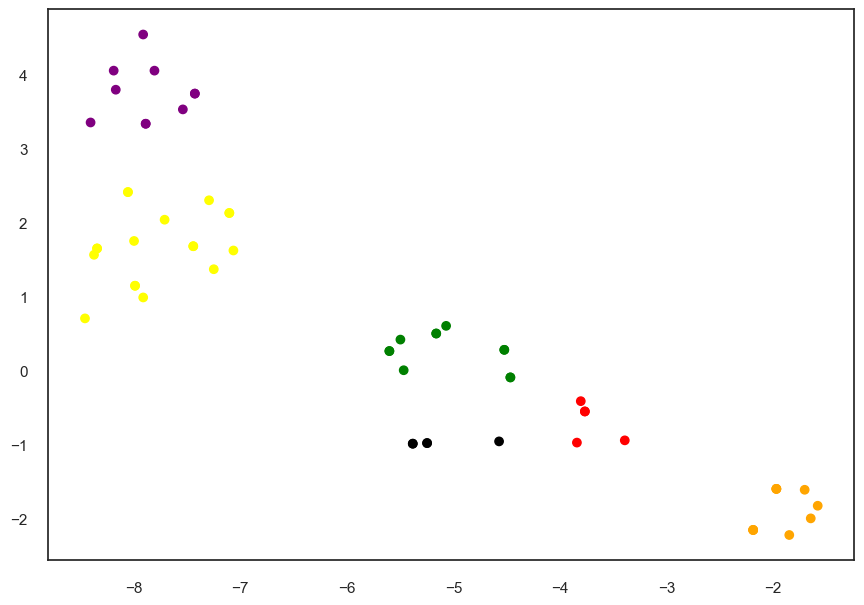

In [222]:
plt.scatter(transformed_hsi[:,0],transformed_hsi[:,1],c=gmm_label2,cmap=ListedColormap(colors))

Setting Backend To: AvailableBackends.numpy


/Users/deepprakashravi/miniforge3/envs/gempy3/lib/python3.10/site-packages/gempy/core/data/geo_model.py:164: UserWarning: You are using refinement and passing a regular grid. The resolution of the regular grid will be overwritten
  warnings.warn(
/Users/deepprakashravi/miniforge3/envs/gempy3/lib/python3.10/site-packages/gempy_viewer/API/_plot_2d_API.py:172: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  p.fig.show()


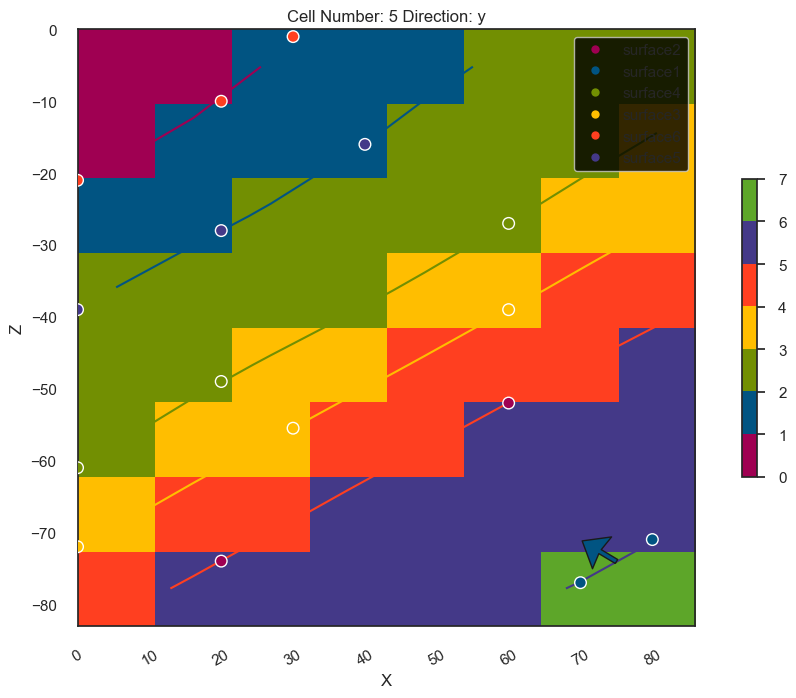

In [223]:
geo_model_test = gp.create_geomodel(
    project_name='Gempy_abc_Test',
    extent=[0, 86, -10, 10, -83, 0],
    resolution=[86,20,83],
    refinement=3,
    structural_frame= gp.data.StructuralFrame.initialize_default_structure()
    )

gp.add_surface_points(
    geo_model=geo_model_test,
    x=[70.0, 80.0],
    y=[0.0, 0.0],
    z=[-77.0, -71.0],
    elements_names=['surface1', 'surface1']
)

gp.add_orientations(
    geo_model=geo_model_test,
    x=[75],
    y=[0.0],
    z=[-74],
    elements_names=['surface1'],
    pole_vector=[[-5/3, 0, 1]]
)
geo_model_test.update_transform(gp.data.GlobalAnisotropy.NONE)

element2 = gp.data.StructuralElement(
    name='surface2',
    color=next(geo_model_test.structural_frame.color_generator),
    surface_points=gp.data.SurfacePointsTable.from_arrays(
        x=np.array([20.0, 60.0]),
        y=np.array([0.0, 0.0]),
        z=np.array([-74, -52]),
        names='surface2'
    ),
    orientations=gp.data.OrientationsTable.initialize_empty()
)

geo_model_test.structural_frame.structural_groups[0].append_element(element2)

element3 = gp.data.StructuralElement(
    name='surface3',
    color=next(geo_model_test.structural_frame.color_generator),
    surface_points=gp.data.SurfacePointsTable.from_arrays(
        x=np.array([0.0, 30.0, 60]),
        y=np.array([0.0, 0.0,0.0]),
        z=np.array([-72, -55.5, -39]),
        names='surface3'
    ),
    orientations=gp.data.OrientationsTable.initialize_empty()
)

geo_model_test.structural_frame.structural_groups[0].append_element(element3)

element4 = gp.data.StructuralElement(
    name='surface4',
    color=next(geo_model_test.structural_frame.color_generator),
    surface_points=gp.data.SurfacePointsTable.from_arrays(
        x=np.array([0.0, 20.0, 60]),
        y=np.array([0.0, 0.0,0.0]),
        z=np.array([-61, -49, -27]),
        names='surface4'
    ),
    orientations=gp.data.OrientationsTable.initialize_empty()
)

geo_model_test.structural_frame.structural_groups[0].append_element(element4)

element5 = gp.data.StructuralElement(
    name='surface5',
    color=next(geo_model_test.structural_frame.color_generator),
    surface_points=gp.data.SurfacePointsTable.from_arrays(
        x=np.array([0.0, 20.0, 40]),
        y=np.array([0.0, 0.0, 0.0]),
        z=np.array([-39, -28, -16]),
        names='surface5'
    ),
    orientations=gp.data.OrientationsTable.initialize_empty()
)

geo_model_test.structural_frame.structural_groups[0].append_element(element5)

element6 = gp.data.StructuralElement(
    name='surface6',
    color=next(geo_model_test.structural_frame.color_generator),
    surface_points=gp.data.SurfacePointsTable.from_arrays(
        x=np.array([0.0, 20.0,30]),
        y=np.array([0.0, 0.0, 0.0]),
        z=np.array([-21, -10, -1]),
        names='surface6'
    ),
    orientations=gp.data.OrientationsTable.initialize_empty()
)

geo_model_test.structural_frame.structural_groups[0].append_element(element6)

geo_model_test.structural_frame.structural_groups[0].elements[0], geo_model_test.structural_frame.structural_groups[0].elements[1],\
geo_model_test.structural_frame.structural_groups[0].elements[2], geo_model_test.structural_frame.structural_groups[0].elements[3],\
geo_model_test.structural_frame.structural_groups[0].elements[4], geo_model_test.structural_frame.structural_groups[0].elements[5] = \
geo_model_test.structural_frame.structural_groups[0].elements[1], geo_model_test.structural_frame.structural_groups[0].elements[0],\
geo_model_test.structural_frame.structural_groups[0].elements[3], geo_model_test.structural_frame.structural_groups[0].elements[2],\
geo_model_test.structural_frame.structural_groups[0].elements[5], geo_model_test.structural_frame.structural_groups[0].elements[4]  

gp.compute_model(geo_model_test)
gpv.plot_2d(geo_model_test, cell_number=5, legend='force')


In [224]:
y_obs_label = 7 -y_obs[mask]
y_obs_label

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 4., 4., 4., 4., 4., 4., 4., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
        6., 6., 6., 6., 6.], dtype=torch.float64)

In [225]:
x_loc = 20
y_loc = 0
z_loc = np.linspace(0,-82, 83)
print(z_loc)
xyz_coord = np.array([[x_loc, y_loc, z] for z in z_loc])[mask]
print(xyz_coord.shape)
gp.set_custom_grid(geo_model_test.grid, xyz_coord=xyz_coord)

[  0.  -1.  -2.  -3.  -4.  -5.  -6.  -7.  -8.  -9. -10. -11. -12. -13.
 -14. -15. -16. -17. -18. -19. -20. -21. -22. -23. -24. -25. -26. -27.
 -28. -29. -30. -31. -32. -33. -34. -35. -36. -37. -38. -39. -40. -41.
 -42. -43. -44. -45. -46. -47. -48. -49. -50. -51. -52. -53. -54. -55.
 -56. -57. -58. -59. -60. -61. -62. -63. -64. -65. -66. -67. -68. -69.
 -70. -71. -72. -73. -74. -75. -76. -77. -78. -79. -80. -81. -82.]
(59, 3)
Active grids: ['custom']


In [226]:
geo_model_test.interpolation_options.mesh_extraction = False
sol = gp.compute_model(geo_model_test)

Setting Backend To: AvailableBackends.numpy


In [227]:
#gpv.plot_2d(geo_model_test, section_names=['section1'])

In [228]:
sp_coords_copy_test = geo_model_test.interpolation_input.surface_points.sp_coords.copy()
print(sp_coords_copy_test)
geo_model_test.transform.apply_inverse(sp_coords_copy_test)

[[-2.75   0.     0.   ]
 [-0.75   0.     1.1  ]
 [-0.25   0.    -0.15 ]
 [ 0.25   0.     0.15 ]
 [-3.75   0.     0.65 ]
 [-2.75   0.     1.25 ]
 [-0.75   0.     2.35 ]
 [-3.75   0.     0.1  ]
 [-2.25   0.     0.925]
 [-0.75   0.     1.75 ]
 [-3.75   0.     2.65 ]
 [-2.75   0.     3.2  ]
 [-2.25   0.     3.65 ]
 [-3.75   0.     1.75 ]
 [-2.75   0.     2.3  ]
 [-1.75   0.     2.9  ]]


array([[ 20. ,   0. , -74. ],
       [ 60. ,   0. , -52. ],
       [ 70. ,   0. , -77. ],
       [ 80. ,   0. , -71. ],
       [  0. ,   0. , -61. ],
       [ 20. ,   0. , -49. ],
       [ 60. ,   0. , -27. ],
       [  0. ,   0. , -72. ],
       [ 30. ,   0. , -55.5],
       [ 60. ,   0. , -39. ],
       [  0. ,   0. , -21. ],
       [ 20. ,   0. , -10. ],
       [ 30. ,   0. ,  -1. ],
       [  0. ,   0. , -39. ],
       [ 20. ,   0. , -28. ],
       [ 40. ,   0. , -16. ]])

In [229]:
geo_model_test.surface_points

SurfacePointsTable(data=
[(20., 0., -74. , 83125757, 0.),(60., 0., -52. , 83125757, 0.),
 (70., 0., -77. , 80361448, 0.),(80., 0., -71. , 80361448, 0.),
 ( 0., 0., -61. , 73937819, 0.),(20., 0., -49. , 73937819, 0.),
 (60., 0., -27. , 73937819, 0.),( 0., 0., -72. , 71248705, 0.),
 (30., 0., -55.5, 71248705, 0.),(60., 0., -39. , 71248705, 0.),
 ( 0., 0., -21. , 28673039, 0.),(20., 0., -10. , 28673039, 0.),
 (30., 0.,  -1. , 28673039, 0.),( 0., 0., -39. , 46441704, 0.),
 (20., 0., -28. , 46441704, 0.),(40., 0., -16. , 46441704, 0.)],
name_id_map={'surface2': 83125757, 'surface1': 80361448, 'surface4': 73937819, 'surface3': 71248705, 'surface6': 28673039, 'surface5': 46441704, 'basement': 74357750})

Setting Backend To: AvailableBackends.numpy


/Users/deepprakashravi/miniforge3/envs/gempy3/lib/python3.10/site-packages/gempy_viewer/API/_plot_2d_API.py:172: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  p.fig.show()


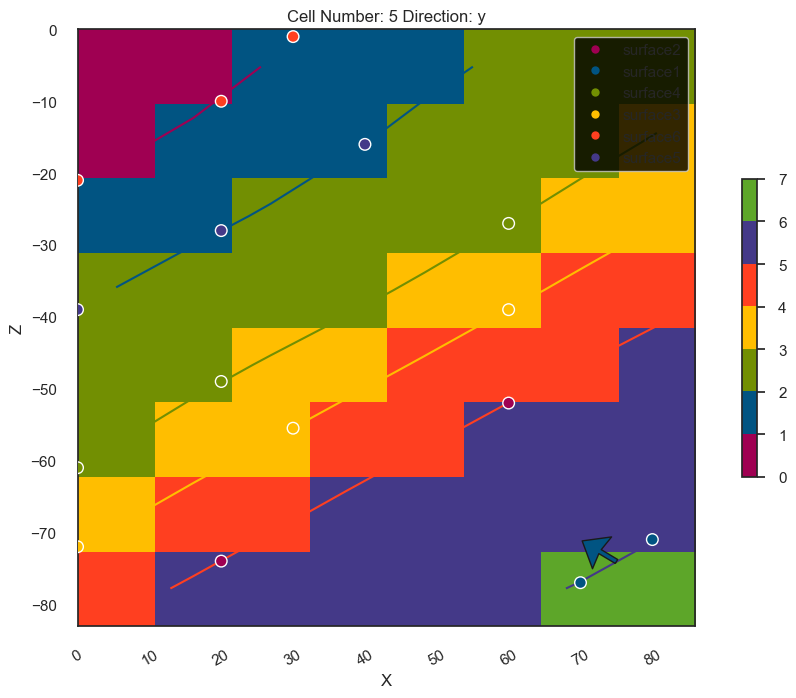

In [230]:
gp.compute_model(geo_model_test)
gpv.plot_2d(geo_model_test, cell_number=5, legend='force')

In [231]:
sp_coords_copy_test = geo_model_test.interpolation_input.surface_points.sp_coords.copy()
print(sp_coords_copy_test)
geo_model_test.transform.apply_inverse(sp_coords_copy_test)

[[-2.75   0.     0.   ]
 [-0.75   0.     1.1  ]
 [-0.25   0.    -0.15 ]
 [ 0.25   0.     0.15 ]
 [-3.75   0.     0.65 ]
 [-2.75   0.     1.25 ]
 [-0.75   0.     2.35 ]
 [-3.75   0.     0.1  ]
 [-2.25   0.     0.925]
 [-0.75   0.     1.75 ]
 [-3.75   0.     2.65 ]
 [-2.75   0.     3.2  ]
 [-2.25   0.     3.65 ]
 [-3.75   0.     1.75 ]
 [-2.75   0.     2.3  ]
 [-1.75   0.     2.9  ]]


array([[ 20. ,   0. , -74. ],
       [ 60. ,   0. , -52. ],
       [ 70. ,   0. , -77. ],
       [ 80. ,   0. , -71. ],
       [  0. ,   0. , -61. ],
       [ 20. ,   0. , -49. ],
       [ 60. ,   0. , -27. ],
       [  0. ,   0. , -72. ],
       [ 30. ,   0. , -55.5],
       [ 60. ,   0. , -39. ],
       [  0. ,   0. , -21. ],
       [ 20. ,   0. , -10. ],
       [ 30. ,   0. ,  -1. ],
       [  0. ,   0. , -39. ],
       [ 20. ,   0. , -28. ],
       [ 40. ,   0. , -16. ]])

In [232]:
# Change the backend to PyTorch for probabilistic modeling
BackendTensor.change_backend_gempy(engine_backend=gp.data.AvailableBackends.PYTORCH)

Setting Backend To: AvailableBackends.PYTORCH


In [233]:
# geo_model_test.interpolation_options.uni_degree = 0
# geo_model_test.interpolation_options.mesh_extraction = False
geo_model_test.interpolation_options.sigmoid_slope = 50

In [234]:
geo_model_test.solutions.octrees_output[0].last_output_center

InterpOutput(scalar_fields=ScalarFieldOutput(weights=array([-1.58450258e+00,  4.26719835e-17, -9.07995259e-01,  1.47537823e-02,
       -1.63896301e+00,  7.34936835e-02, -4.24866590e-03, -5.30118658e-02,
        5.72069162e-03, -1.48519490e-01,  1.22845313e-01,  4.64191770e-02,
       -4.14558661e-02, -7.47661279e-01, -2.00597546e-16,  1.31611094e+00]), grid=Grid(regular_grid=RegularGrid(extent=array([-3.749999,  0.550001, -0.499999,  0.500001, -0.449999,  3.700001]), regular_grid_shape=array([2, 2, 2])), custom_grid=GenericGrid(values=array([[-2.75,  0.  ,  3.7 ],
       [-2.75,  0.  ,  3.65],
       [-2.75,  0.  ,  3.6 ],
       [-2.75,  0.  ,  3.55],
       [-2.75,  0.  ,  3.5 ],
       [-2.75,  0.  ,  3.45],
       [-2.75,  0.  ,  3.4 ],
       [-2.75,  0.  ,  3.35],
       [-2.75,  0.  ,  3.3 ],
       [-2.75,  0.  ,  3.25],
       [-2.75,  0.  ,  2.8 ],
       [-2.75,  0.  ,  2.75],
       [-2.75,  0.  ,  2.7 ],
       [-2.75,  0.  ,  2.65],
       [-2.75,  0.  ,  2.6 ],
       [-

In [235]:
custom_grid_values1 = geo_model_test.solutions.octrees_output[0].last_output_center.custom_grid_values
custom_grid_values1

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 4., 4., 4., 4., 4., 4., 4., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 6., 6., 6., 6., 6.])

In [236]:
 
# # Compute the geological model
interpolation_input = geo_model_test.interpolation_input
geo_model_test.solutions = gempy_engine.compute_model(
    interpolation_input=interpolation_input,
    options=geo_model_test.interpolation_options,
    data_descriptor=geo_model_test.input_data_descriptor,
    geophysics_input=geo_model_test.geophysics_input,
)

# Compute and observe the thickness of the geological layer

custom_grid_values2 = geo_model_test.solutions.octrees_output[0].last_output_center.custom_grid_values

print(custom_grid_values2)

Condition number: 1549.941240198929.
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0032, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000,
        2.0000, 2.0008, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000,
        3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000,
        3.0000, 3.0015, 4.0000, 4.0000, 4.0000, 4.0000, 4.0000, 4.0000, 4.0014,
        5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0009,
        6.0000, 6.0000, 6.0000, 6.0000, 6.0000], dtype=torch.float64,
       grad_fn=<SliceBackward0>)


In [237]:
torch.tensor(custom_grid_values1) - custom_grid_values2

tensor([ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00, -5.3291e-15,
        -1.0676e-12, -2.1966e-10, -4.8607e-08, -1.1807e-05, -3.2038e-03,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00, -4.8139e-13, -5.7525e-10, -6.9389e-07, -8.3637e-04,
         6.6285e-10,  6.0396e-13,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00, -5.3291e-15, -3.9524e-12,
        -2.9621e-09, -2.1426e-06, -1.4905e-03,  1.0658e-14,  0.0000e+00,
        -5.3291e-15, -4.2775e-12, -2.8276e-09, -1.9344e-06, -1.3722e-03,
         2.1831e-12,  2.6645e-15,  0.0000e+00,  0.0000e+00, -8.8818e-16,
        -6.4571e-13, -6.9269e-10, -7.6387e-07, -8.6315e-04,  4.7073e-13,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
       dtype=torch.float64, grad_fn=<SubBackward0>)

In [238]:
geo_model_test.surface_points

SurfacePointsTable(data=
[(20., 0., -74. , 83125757, 0.),(60., 0., -52. , 83125757, 0.),
 (70., 0., -77. , 80361448, 0.),(80., 0., -71. , 80361448, 0.),
 ( 0., 0., -61. , 73937819, 0.),(20., 0., -49. , 73937819, 0.),
 (60., 0., -27. , 73937819, 0.),( 0., 0., -72. , 71248705, 0.),
 (30., 0., -55.5, 71248705, 0.),(60., 0., -39. , 71248705, 0.),
 ( 0., 0., -21. , 28673039, 0.),(20., 0., -10. , 28673039, 0.),
 (30., 0.,  -1. , 28673039, 0.),( 0., 0., -39. , 46441704, 0.),
 (20., 0., -28. , 46441704, 0.),(40., 0., -16. , 46441704, 0.)],
name_id_map={'surface2': 83125757, 'surface1': 80361448, 'surface4': 73937819, 'surface3': 71248705, 'surface6': 28673039, 'surface5': 46441704, 'basement': 74357750})

In [239]:
geo_model_test.orientations

OrientationsTable(data=
[(75., 0., -74., -1.67, 0., 1., 80361448, 0.01)],
name_id_map=None)

In [240]:
geo_model_test.transform.apply_inverse(sp_coords_copy_test)

array([[ 20. ,   0. , -74. ],
       [ 60. ,   0. , -52. ],
       [ 70. ,   0. , -77. ],
       [ 80. ,   0. , -71. ],
       [  0. ,   0. , -61. ],
       [ 20. ,   0. , -49. ],
       [ 60. ,   0. , -27. ],
       [  0. ,   0. , -72. ],
       [ 30. ,   0. , -55.5],
       [ 60. ,   0. , -39. ],
       [  0. ,   0. , -21. ],
       [ 20. ,   0. , -10. ],
       [ 30. ,   0. ,  -1. ],
       [  0. ,   0. , -39. ],
       [ 20. ,   0. , -28. ],
       [ 40. ,   0. , -16. ]])

Condition number: 1553.975019641039.
Condition number: 1553.975019641039.


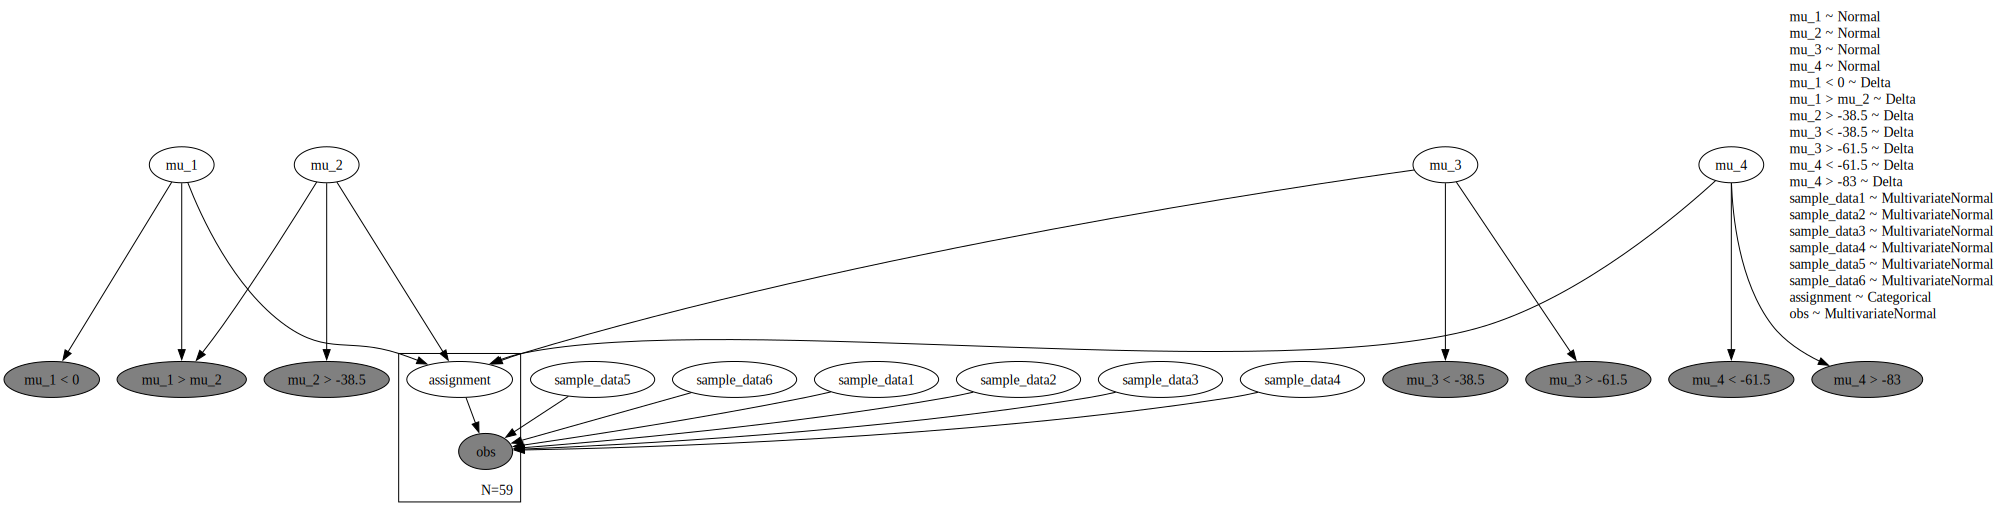

In [241]:

import torch.nn.functional as F
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete

pyro.set_rng_seed(42)

@config_enumerate
def model_test(y_obs_label):
    """
    This Pyro model represents the probabilistic aspects of the geological model.
    It defines a prior distribution for the top layer's location and
    computes the thickness of the geological layer as an observed variable.
    """
    # Define prior for the top layer's location
    prior_mean_surface_1 = sp_coords_copy_test[11, 2]
    prior_mean_surface_2 = sp_coords_copy_test[14, 2]
    prior_mean_surface_3 = sp_coords_copy_test[5, 2]
    prior_mean_surface_4 = sp_coords_copy_test[0, 2]

    mu_surface_1 = pyro.sample('mu_1', dist.Normal(prior_mean_surface_1, torch.tensor(0.2, dtype=torch.float64)))
    mu_surface_2 = pyro.sample('mu_2', dist.Normal(prior_mean_surface_2, torch.tensor(0.2, dtype=torch.float64)))
    mu_surface_3 = pyro.sample('mu_3', dist.Normal(prior_mean_surface_3, torch.tensor(0.2, dtype=torch.float64)))
    mu_surface_4 = pyro.sample('mu_4', dist.Normal(prior_mean_surface_4, torch.tensor(0.2, dtype=torch.float64)))
    #print(mu_surface_1, mu_surface_2)
    # Ensure that mu_surface_1 is greater than mu_surface_2
    pyro.sample('mu_1 < 0', dist.Delta(torch.tensor(1.0, dtype=torch.float64)), obs=(mu_surface_1 < 3.7))
    pyro.sample('mu_1 > mu_2', dist.Delta(torch.tensor(1.0, dtype=torch.float64)), obs=(mu_surface_1 > mu_surface_2))
    pyro.sample('mu_2 > -38.5', dist.Delta(torch.tensor(1.0, dtype=torch.float64)), obs=(mu_surface_2 > 1.775))
    pyro.sample('mu_3 < -38.5', dist.Delta(torch.tensor(1.0, dtype=torch.float64)), obs=(mu_surface_3 < 1.4))
    pyro.sample('mu_3 > -61.5', dist.Delta(torch.tensor(1.0, dtype=torch.float64)), obs=(mu_surface_3 > 0.625))
    pyro.sample('mu_4 < -61.5', dist.Delta(torch.tensor(1.0, dtype=torch.float64)), obs=(mu_surface_4 < 0.625))
    pyro.sample('mu_4 > -83', dist.Delta(torch.tensor(1.0, dtype=torch.float64)), obs=(mu_surface_4 > - 0.2 ))
    # Update the model with the new top layer's location
    interpolation_input = geo_model_test.interpolation_input
    
    
    interpolation_input.surface_points.sp_coords = torch.index_put(
        interpolation_input.surface_points.sp_coords,
        (torch.tensor([11]), torch.tensor([2])),
        mu_surface_1
    )
    interpolation_input.surface_points.sp_coords = torch.index_put(
        interpolation_input.surface_points.sp_coords,
        (torch.tensor([14]), torch.tensor([2])),
        mu_surface_2
    )
    
    interpolation_input.surface_points.sp_coords = torch.index_put(
        interpolation_input.surface_points.sp_coords,
        (torch.tensor([5]), torch.tensor([2])),
        mu_surface_3
    )
    interpolation_input.surface_points.sp_coords = torch.index_put(
        interpolation_input.surface_points.sp_coords,
        (torch.tensor([0]), torch.tensor([2])),
        mu_surface_4
    )
    
    
    #print("interpolation_input",interpolation_input.surface_points.sp_coords)
    
    # # Compute the geological model
    geo_model_test.solutions = gempy_engine.compute_model(
        interpolation_input=interpolation_input,
        options=geo_model_test.interpolation_options,
        data_descriptor=geo_model_test.input_data_descriptor,
        geophysics_input=geo_model_test.geophysics_input,
    )
    
    # Compute and observe the thickness of the geological layer
    
    custom_grid_values = geo_model_test.solutions.octrees_output[0].last_output_center.custom_grid_values
    lambda_ = 10.0
    loc_mean = torch.tensor(mean_init,dtype=torch.float64)
    loc_cov =  torch.tensor(cov_init, dtype=torch.float64)
    class_label = F.softmax(-lambda_* (torch.tensor([1,2,3,4,5,6], dtype=torch.float64) - custom_grid_values.reshape(-1,1))**2, dim=1)
    sample =[]
    for i in range(loc_mean.shape[0]):
        sample_data = pyro.sample("sample_data"+str(i+1), dist.MultivariateNormal(loc=loc_mean[i],covariance_matrix=loc_cov[i]))
        sample.append(sample_data)
    sample_tesnor = torch.stack(sample, dim=0)
    
    with pyro.plate('N='+str(y_obs_label.shape[0]), y_obs_label.shape[0]):
        assignment = pyro.sample("assignment", dist.Categorical(class_label))
        #print("mean\n", mean[assignment])
        #obs = pyro.sample("obs", dist.Normal(custom_grid_values, 0.5 ), obs=y_obs_label.reshape(-1))
        #obs = pyro.sample("obs", dist.Normal(sample[assignment], 0.1 ), obs=y_obs_label.reshape(-1))
        #print(sample_tesnor[assignment].shape, loc_cov[assignment].shape, y_obs_label.shape)
        obs = pyro.sample("obs", dist.MultivariateNormal(loc=sample_tesnor[assignment],covariance_matrix=loc_cov[assignment]), obs=y_obs_label)
        #obs = pyro.sample("obs", dist.Normal(mean[assignment],  sigma[assignment]), obs=y_obs_label.reshape(-1))
    #return obs
dependencies = get_dependencies(model_test, model_args=(normalised_hsi,))
pyro.render_model(model_test, model_args=(normalised_hsi,),render_distributions=True)

In [242]:
print(normalised_hsi)
model_test(normalised_hsi)

tensor([[-0.0917, -0.1022,  0.6458,  ..., -2.0414, -2.0789, -2.1446],
        [-0.3896,  0.0792, -0.0924,  ..., -1.8319, -1.9459, -2.1446],
        [-0.3896,  0.0792, -0.0924,  ..., -1.8319, -1.9459, -2.1446],
        ...,
        [-0.0917, -1.4476, -1.4273,  ..., -0.5751, -0.4825, -0.4311],
        [-1.9709, -2.7326, -1.4587,  ..., -0.4180, -0.3495, -0.2507],
        [-1.9709, -2.7326, -1.4587,  ..., -0.4180, -0.3495, -0.2507]],
       dtype=torch.float64)
Condition number: 1553.9750196410394.


Condition number: 1553.975019641039.
Condition number: 1556.5576394686082.
Condition number: 1530.8272178905484.
Condition number: 1553.9233108060996.
Condition number: 1547.8321915841918.
Condition number: 1546.7455826662208.
Condition number: 1544.802835318025.
Condition number: 1553.3464338522037.
Condition number: 1536.257309717179.
Condition number: 1568.3776474736815.
Condition number: 1534.2134591788251.
Condition number: 1546.1408818653886.
Condition number: 1543.196944877182.
Condition number: 1549.8605494721673.
Condition number: 1555.802370696594.
Condition number: 1541.9938784378785.
Condition number: 1550.3420843586462.
Condition number: 1553.327414666679.
Condition number: 1528.4937317149684.
Condition number: 1508.1476650795482.
Condition number: 1540.250257008486.
Condition number: 1558.0488366861653.
Condition number: 1528.5906911586003.
Condition number: 1536.5299828473603.
Condition number: 1576.352379468677.
Condition number: 1557.760959292805.
Condition number: 156

/Users/deepprakashravi/miniforge3/envs/gempy3/lib/python3.10/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/deepprakashravi/miniforge3/envs/gempy3/lib/python3.10/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


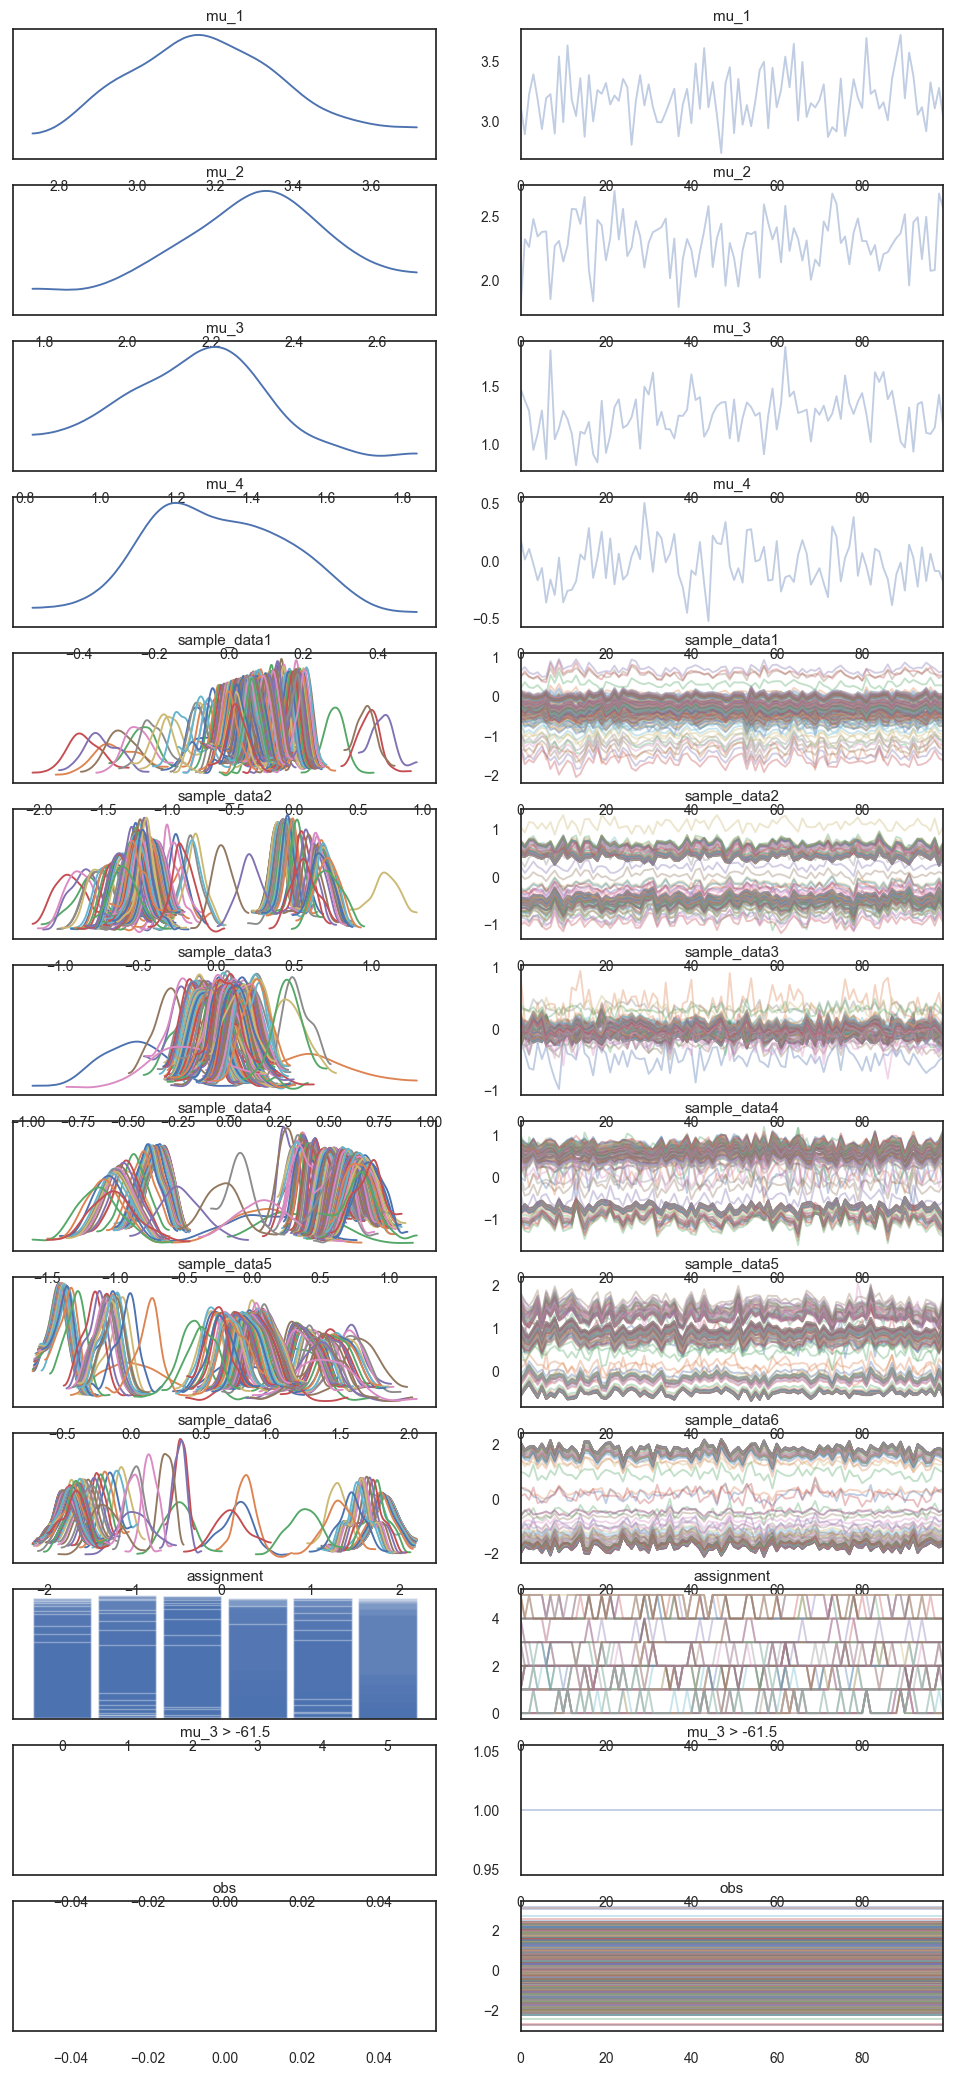

In [243]:
pyro.set_rng_seed(42)

prior = Predictive(model_test, num_samples=100)(normalised_hsi)

# Key to avoid
avoid_key = ['mu_1 < 0','mu_1 > mu_2','mu_2 > -38.5', 'mu_3 < -38.5','mu_3 > -61.4','mu_4 < -61.5', 'mu_4 > -83']

# Create sub-dictionary without the avoid_key
prior = dict((key, value) for key, value in prior.items() if key not in avoid_key)

data = az.from_pyro(prior=prior)
az.plot_trace(data.prior)
plt.show()

In [244]:
pyro.set_rng_seed(42)
pyro.primitives.enable_validation(is_validate=True)
nuts_kernel = NUTS(model_test, step_size=0.0085, adapt_step_size=True, target_accept_prob=0.9, max_tree_depth=10, init_strategy=init_to_mean)
#nuts_kernel = NUTS(model_test, step_size=0.00085, adapt_step_size=True, target_accept_prob=0.9, max_tree_depth=10)
#nuts_kernel = NUTS(model_test)
#initial_values = {'mu_1': torch.tensor(0.01, dtype=torch.float64),'mu_2': torch.tensor(0.01, dtype=torch.float64) }
initial_values = {'mu_1': torch.tensor(0.01, dtype=torch.float64),'mu_2': torch.tensor(0.01, dtype=torch.float64) }
#mcmc = MCMC(nuts_kernel, num_samples=200, warmup_steps=50, disable_validation=False, initial_params=initial_values)
mcmc = MCMC(nuts_kernel, num_samples=100, warmup_steps=50, disable_validation=False)
mcmc.run(normalised_hsi)

Warmup:   0%|          | 0/150 [00:00, ?it/s]

Condition number: 1553.9750196410394.
Condition number: 1549.941240198929.
Condition number: 1549.941240198929.
Condition number: 1549.941240198929.
Condition number: 1549.941240198929.
Condition number: 1549.941240198929.
Condition number: 1548.9393142841557.
Condition number: 1549.941240198929.
Condition number: 1549.7120324939133.
Condition number: 1549.941240198929.
Condition number: 1549.738676147651.
Condition number: 1549.941240198929.
Condition number: 1549.9333585473491.
Condition number: 1549.941240198929.
Condition number: 1549.9527461861283.
Condition number: 1549.941240198929.
Condition number: 1549.9039401184573.
Condition number: 1549.941240198929.
Condition number: 1549.9454472399386.
Condition number: 1549.941240198929.
Condition number: 1549.9459132641202.
Condition number: 1549.941240198929.
Condition number: 1549.939185879998.
Condition number: 1549.941240198929.
Condition number: 1549.9382701798.
Condition number: 1549.941240198929.
Condition number: 1549.940518116

Warmup:   1%|          | 1/150 [00:06,  6.93s/it, step size=3.79e-05, acc. prob=0.469]

Condition number: 1549.9474727709876.
Condition number: 1549.9475646068133.
Condition number: 1549.947656448175.
Condition number: 1549.9477482950906.
Condition number: 1549.9478401475756.
Condition number: 1549.9422065069884.
Condition number: 1549.946280793897.
Condition number: 1549.9503550572974.
Condition number: 1549.9340578612755.
Condition number: 1549.9299835017728.
Condition number: 1549.9259091173647.
Condition number: 1549.9218347077142.
Condition number: 1549.9544292975609.
Condition number: 1549.9585035150262.
Condition number: 1549.9625777100582.
Condition number: 1549.9666518830068.
Condition number: 1549.9707260342293.
Condition number: 1549.974800164084.
Condition number: 1549.978874272929.
Condition number: 1549.9829483611254.
Condition number: 1549.9177602724687.
Condition number: 1549.9136858112818.
Condition number: 1549.9096113238188.
Condition number: 1549.905536809723.
Condition number: 1549.90146226866.
Condition number: 1549.8973877002834.
Condition number: 1

Warmup:   1%|▏         | 2/150 [06:47, 238.51s/it, step size=4.82e-06, acc. prob=0.296]

Condition number: 1549.8036643188643.
Condition number: 1549.799588995094.
Condition number: 1549.79551363579.
Condition number: 1549.7914382406361.
Condition number: 1549.9825257670882.
Condition number: 1549.9821031790532.
Condition number: 1549.9816805970167.
Condition number: 1549.983370961166.
Condition number: 1549.9837935672147.
Condition number: 1549.9842161792724.
Condition number: 1549.9846387973432.
Condition number: 1549.981258020975.
Condition number: 1549.9808354509216.
Condition number: 1549.980412886864.
Condition number: 1549.9799903287887.
Condition number: 1549.979567776701.
Condition number: 1549.9791452305915.
Condition number: 1549.9787226904639.
Condition number: 1549.9783001563078.
Condition number: 1549.9778776281275.
Condition number: 1549.9774551059145.
Condition number: 1549.97703258967.
Condition number: 1549.9766100793909.
Condition number: 1549.9761875750698.
Condition number: 1549.9757650767117.
Condition number: 1549.9753425843057.
Condition number: 154

Warmup:   2%|▏         | 3/150 [06:50, 130.77s/it, step size=3.74e-06, acc. prob=0.512]

Condition number: 1549.9882186802745.
Condition number: 1549.9886665812658.
Condition number: 1549.9888905310536.
Condition number: 1549.9891144803746.
Condition number: 1549.9893384292236.
Condition number: 1549.989562377607.
Condition number: 1549.9897863255237.
Condition number: 1549.9900102729698.
Condition number: 1549.9902342199548.
Condition number: 1549.9904581664753.
Condition number: 1549.990682112524.
Condition number: 1549.9909060581115.
Condition number: 1549.9911300032334.
Condition number: 1549.9913539478946.
Condition number: 1549.9915778920931.
Condition number: 1549.991801835825.
Condition number: 1549.9920257791011.
Condition number: 1549.9922497219118.
Condition number: 1549.9924736642627.
Condition number: 1549.992697606156.
Condition number: 1549.9929215475888.
Condition number: 1549.9931454885632.
Condition number: 1549.9933694290776.
Condition number: 1549.9935933691368.
Condition number: 1549.9938173087385.
Condition number: 1549.9940412478813.
Condition number

Warmup:   3%|▎         | 4/150 [15:59, 296.23s/it, step size=3.86e-06, acc. prob=0.631]

Condition number: 1550.0947766069125.
Condition number: 1550.0950004011793.
Condition number: 1550.0952241952696.
Condition number: 1550.095447989183.
Condition number: 1549.8967359370652.
Condition number: 1549.8971190843001.
Condition number: 1549.8975022360967.
Condition number: 1549.8959696562426.
Condition number: 1549.8955865226578.
Condition number: 1549.8952033936152.
Condition number: 1549.8948202691215.
Condition number: 1549.8978853924493.
Condition number: 1549.8982685533636.
Condition number: 1549.8986517188398.
Condition number: 1549.8990348888801.
Condition number: 1549.89941806349.
Condition number: 1549.899801242667.
Condition number: 1549.9001844264224.
Condition number: 1549.900567614749.
Condition number: 1549.8944371491637.
Condition number: 1549.8940540337471.
Condition number: 1549.8936709228665.
Condition number: 1549.8932878165203.
Condition number: 1549.8929047147042.
Condition number: 1549.8925216174175.
Condition number: 1549.892138524657.
Condition number: 

Warmup:   3%|▎         | 5/150 [16:52, 208.37s/it, step size=4.54e-06, acc. prob=0.705]

Condition number: 1549.5352681020984.
Condition number: 1549.534888399963.
Condition number: 1549.5749652177012.
Condition number: 1549.5745812117987.
Condition number: 1549.574389205766.
Condition number: 1549.5741971976786.
Condition number: 1549.5740051875414.
Condition number: 1549.5738131753526.
Condition number: 1549.5736211611136.
Condition number: 1549.5734291448255.
Condition number: 1549.5732371264864.
Condition number: 1549.5730451061027.
Condition number: 1549.5728530836693.
Condition number: 1549.5726610591912.
Condition number: 1549.5724690326667.
Condition number: 1549.5722770040984.
Condition number: 1549.5720849734857.
Condition number: 1549.5718929408295.
Condition number: 1549.5717009061334.
Condition number: 1549.571508869397.
Condition number: 1549.5713168306147.
Condition number: 1549.5711247898003.
Condition number: 1549.5709327469433.
Condition number: 1549.570740702048.
Condition number: 1549.570548655115.
Condition number: 1549.570356606146.
Condition number: 

Warmup:   4%|▍         | 6/150 [16:57, 139.31s/it, step size=5.62e-06, acc. prob=0.753]

Condition number: 1549.5507570708542.
Condition number: 1549.5505648167402.
Condition number: 1549.5684570105411.
Condition number: 1549.5690542413809.
Condition number: 1549.5696514771762.
Condition number: 1549.5672625637405.
Condition number: 1549.566665347769.
Condition number: 1549.566068136737.
Condition number: 1549.5654709306502.
Condition number: 1549.564873729498.
Condition number: 1549.5642765332811.
Condition number: 1549.5636793419944.
Condition number: 1549.5630821556304.
Condition number: 1549.562484974189.
Condition number: 1549.5618877976622.
Condition number: 1549.5612906260524.
Condition number: 1549.5606934593457.
Condition number: 1549.5600962975482.
Condition number: 1549.5594991406485.
Condition number: 1549.558901988652.
Condition number: 1549.5583048415422.
Condition number: 1549.5577076993256.
Condition number: 1549.5571105619888.
Condition number: 1549.5565134295332.
Condition number: 1549.5559163019586.
Condition number: 1549.5553191792571.
Condition number:

Warmup:   5%|▍         | 7/150 [17:39, 107.32s/it, step size=7.30e-06, acc. prob=0.788]

Condition number: 1550.1068184320268.
Condition number: 1550.1074225136106.
Condition number: 1550.0975795112934.
Condition number: 1550.0955220402495.
Condition number: 1550.0944933056735.
Condition number: 1550.0934645717382.
Condition number: 1550.0924358384339.
Condition number: 1550.0914071057643.
Condition number: 1550.0903783737313.
Condition number: 1550.098608247764.
Condition number: 1550.0996369848674.
Condition number: 1550.1006657226033.
Condition number: 1550.1016944609703.
Condition number: 1550.1027231999676.
Condition number: 1550.1037519395938.
Condition number: 1550.1047806798533.
Condition number: 1550.1058094207408.
Condition number: 1550.106838162256.
Condition number: 1550.1078669043975.
Condition number: 1550.1088956471715.
Condition number: 1550.1099243905703.
Condition number: 1550.110953134597.
Condition number: 1550.111981879253.
Condition number: 1550.113010624531.
Condition number: 1550.1140393704359.
Condition number: 1550.1150681169688.
Condition number:

Warmup:   5%|▌         | 8/150 [18:21, 86.46s/it, step size=9.05e-06, acc. prob=0.812] 

Condition number: 1550.9763268601334.
Condition number: 1550.9773560824287.
Condition number: 1550.978385305376.
Condition number: 1550.8584879915381.
Condition number: 1550.8595112971177.
Condition number: 1550.8600229665444.
Condition number: 1550.8605346470817.
Condition number: 1550.8610463387472.
Condition number: 1550.8615580415517.
Condition number: 1550.8620697555057.
Condition number: 1550.857976355355.
Condition number: 1550.8574647302266.
Condition number: 1550.8569531161345.
Condition number: 1550.8564415130693.
Condition number: 1550.8559299210128.
Condition number: 1550.8554183399472.
Condition number: 1550.8549067698661.
Condition number: 1550.8543952107482.
Condition number: 1550.853883662583.
Condition number: 1550.8533721253564.
Condition number: 1550.8528605990475.
Condition number: 1550.8523490836506.
Condition number: 1550.851837579148.
Condition number: 1550.8513260855234.
Condition number: 1550.8508146027636.
Condition number: 1550.8503031308524.
Condition number

Warmup:   6%|▌         | 9/150 [18:23, 60.24s/it, step size=8.20e-06, acc. prob=0.819]

Condition number: 1550.8764023346603.
Condition number: 1550.876914378496.
Condition number: 1550.8774264339265.
Condition number: 1550.8779385009705.
Condition number: 1550.8784505796432.
Condition number: 1550.8507223206998.
Condition number: 1550.8519298695378.
Condition number: 1550.852533672754.
Condition number: 1550.8501185750654.
Condition number: 1550.849514848622.
Condition number: 1550.8489111413626.
Condition number: 1550.848307453291.
Condition number: 1550.8477037843961.
Condition number: 1550.8471001346763.
Condition number: 1550.8464965041317.
Condition number: 1550.8458928927585.
Condition number: 1550.8452893005551.
Condition number: 1550.8446857275155.
Condition number: 1550.8440821736408.
Condition number: 1550.8434786389241.
Condition number: 1550.8531374951726.
Condition number: 1550.8537413367949.
Condition number: 1550.8543451976186.
Condition number: 1550.854949077657.
Condition number: 1550.8555529769008.
Condition number: 1550.8561568953646.
Condition number:

Warmup:   7%|▋         | 10/150 [19:05, 54.49s/it, step size=1.05e-05, acc. prob=0.835]

Condition number: 1551.3811222430036.
Condition number: 1551.3823860392215.
Condition number: 1551.3830179972206.
Condition number: 1551.3804904047233.
Condition number: 1551.3798586062892.
Condition number: 1551.3792268476684.
Condition number: 1551.3785951288376.
Condition number: 1551.3836499951842.
Condition number: 1551.3842820331477.
Condition number: 1551.3849141111325.
Condition number: 1551.3855462291792.
Condition number: 1551.3861783873097.
Condition number: 1551.3868105855604.
Condition number: 1551.3874428239567.
Condition number: 1551.3880751025276.
Condition number: 1551.3887074213087.
Condition number: 1551.3893397803297.
Condition number: 1551.3899721796197.
Condition number: 1551.390604619201.
Condition number: 1551.3912370991154.
Condition number: 1551.3918696193941.
Condition number: 1551.3925021800596.
Condition number: 1551.3931347811424.
Condition number: 1551.3937674226781.
Condition number: 1551.3944001046962.
Condition number: 1551.395032827221.
Condition numb

Warmup:   7%|▋         | 11/150 [19:46, 50.50s/it, step size=1.23e-05, acc. prob=0.845]

Condition number: 1550.8667639638493.
Condition number: 1550.8661568872642.
Condition number: 1550.8655498323114.
Condition number: 1550.8649427989722.
Condition number: 1550.864335787237.
Condition number: 1551.1210406423781.
Condition number: 1551.1206930844373.
Condition number: 1551.120345540579.
Condition number: 1551.1217358005495.
Condition number: 1551.122083400816.
Condition number: 1551.1224310152234.
Condition number: 1551.122778643786.
Condition number: 1551.1231262865215.
Condition number: 1551.1234739434456.
Condition number: 1551.123821614574.
Condition number: 1551.1241692999256.
Condition number: 1551.1245169995104.
Condition number: 1551.1248647133502.
Condition number: 1551.1252124414618.
Condition number: 1551.1255601838573.
Condition number: 1551.1259079405522.
Condition number: 1551.126255711565.
Condition number: 1551.1266034969142.
Condition number: 1551.1269512966091.
Condition number: 1551.127299110674.
Condition number: 1551.127646939119.
Condition number: 15

Warmup:   8%|▊         | 12/150 [20:28, 47.76s/it, step size=1.47e-05, acc. prob=0.854]

Condition number: 1550.8899429673231.
Condition number: 1550.8896018032747.
Condition number: 1550.889260644874.
Condition number: 1550.8940682216698.
Condition number: 1550.8951227896678.
Condition number: 1550.8961774034865.
Condition number: 1550.8972320631701.
Condition number: 1550.898286768758.
Condition number: 1550.8993415202976.
Condition number: 1550.9003963178245.
Condition number: 1550.8919592229618.
Condition number: 1550.8909047921672.
Condition number: 1550.8898504070266.
Condition number: 1550.888796067492.
Condition number: 1550.8877417735234.
Condition number: 1550.886687525077.
Condition number: 1550.885633322116.
Condition number: 1550.884579164591.
Condition number: 1550.9014511613896.
Condition number: 1550.9025060510278.
Condition number: 1550.9035609867904.
Condition number: 1550.9046159687114.
Condition number: 1550.9056709968415.
Condition number: 1550.90672607122.
Condition number: 1550.90778119189.
Condition number: 1550.908836358896.
Condition number: 1550.

Warmup:   9%|▊         | 13/150 [21:09, 45.89s/it, step size=1.61e-05, acc. prob=0.860]

Condition number: 1551.9574610073837.
Condition number: 1551.9585913978544.
Condition number: 1551.9597219127245.
Condition number: 1551.9608525521426.
Condition number: 1551.8258911525943.
Condition number: 1551.8261635506983.
Condition number: 1551.8262999455198.
Condition number: 1551.8264364710299.
Condition number: 1551.8265731273573.
Condition number: 1551.8267099146399.
Condition number: 1551.8268468330002.
Condition number: 1551.8257551490492.
Condition number: 1551.8256192756667.
Condition number: 1551.825483532319.
Condition number: 1551.8253479188704.
Condition number: 1551.8252124351927.
Condition number: 1551.8250770811576.
Condition number: 1551.8249418566345.
Condition number: 1551.8248067614898.
Condition number: 1551.8246717956008.
Condition number: 1551.8245369588296.
Condition number: 1551.8244022510542.
Condition number: 1551.8242676721402.
Condition number: 1551.8241332219604.
Condition number: 1551.8239989003857.
Condition number: 1551.8238647072885.
Condition num

Warmup:   9%|▉         | 14/150 [21:51, 44.55s/it, step size=1.60e-05, acc. prob=0.862]

Condition number: 1551.9172682431295.
Condition number: 1551.91749417678.
Condition number: 1551.9177203396068.
Condition number: 1551.87092005981.
Condition number: 1551.8722740869243.
Condition number: 1551.8729513706783.
Condition number: 1551.873628835251.
Condition number: 1551.87430648116.
Condition number: 1551.8749843089226.
Condition number: 1551.8756623190607.
Condition number: 1551.870243315425.
Condition number: 1551.8695667497968.
Condition number: 1551.868890362424.
Condition number: 1551.86821415279.
Condition number: 1551.8675381203946.
Condition number: 1551.8668622647292.
Condition number: 1551.8661865852848.
Condition number: 1551.8655110815703.
Condition number: 1551.8763405121008.
Condition number: 1551.8770188885608.
Condition number: 1551.8776974489704.
Condition number: 1551.8783761938546.
Condition number: 1551.8790551237432.
Condition number: 1551.8797342391588.
Condition number: 1551.880413540646.
Condition number: 1551.8810930287245.
Condition number: 1551.8

Warmup:  10%|█         | 15/150 [22:32, 43.55s/it, step size=2.13e-05, acc. prob=0.871]

Condition number: 1552.7245668731146.
Condition number: 1552.726139282947.
Condition number: 1552.7277148686462.
Condition number: 1552.7292936420347.
Condition number: 1552.3382219366406.
Condition number: 1552.3419642731076.
Condition number: 1552.3438382106922.
Condition number: 1552.3363535306428.
Condition number: 1552.3344869614107.
Condition number: 1552.3326222254204.
Condition number: 1552.3307593191548.
Condition number: 1552.3457139992847.
Condition number: 1552.347591642473.
Condition number: 1552.3494711438668.
Condition number: 1552.351352507085.
Condition number: 1552.3532357357633.
Condition number: 1552.3551208335493.
Condition number: 1552.3570078041107.
Condition number: 1552.3588966511202.
Condition number: 1552.3288982391223.
Condition number: 1552.3270389818279.
Condition number: 1552.3251815438111.
Condition number: 1552.3233259215986.
Condition number: 1552.3214721117479.
Condition number: 1552.3196201108317.
Condition number: 1552.317769915425.
Condition number

Warmup:  11%|█         | 16/150 [23:14, 43.09s/it, step size=1.28e-05, acc. prob=0.862]

Condition number: 1554.7151584624555.
Condition number: 1554.7216224649273.
Condition number: 1554.7280963981113.
Condition number: 1553.1104167801234.
Condition number: 1553.112248833961.
Condition number: 1553.113167279217.
Condition number: 1553.114087337444.
Condition number: 1553.115009009209.
Condition number: 1553.1159322950866.
Condition number: 1553.116857195656.
Condition number: 1553.1095031704267.
Condition number: 1553.1085911714815.
Condition number: 1553.107680782743.
Condition number: 1553.1067720036785.
Condition number: 1553.105864833749.
Condition number: 1553.1049592724266.
Condition number: 1553.1040553191933.
Condition number: 1553.1031529735235.
Condition number: 1553.1177837114938.
Condition number: 1553.118711843197.
Condition number: 1553.1196415913507.
Condition number: 1553.1205729565593.
Condition number: 1553.121505939418.
Condition number: 1553.1224405405408.
Condition number: 1553.12337676054.
Condition number: 1553.124314600029.
Condition number: 1553.1

Warmup:  11%|█▏        | 17/150 [23:55, 42.56s/it, step size=9.62e-06, acc. prob=0.858]

Condition number: 1553.5326768403336.
Condition number: 1553.5334196931183.
Condition number: 1553.5341637773836.
Condition number: 1553.534909094089.
Condition number: 1553.5356556442134.
Condition number: 1553.5364034287413.
Condition number: 1553.5371524486397.
Condition number: 1553.5379027048987.
Condition number: 1553.5386541984997.
Condition number: 1553.5394069304364.
Condition number: 1553.5401609016976.
Condition number: 1553.5409161132811.
Condition number: 1553.5416725661823.
Condition number: 1553.542430261403.
Condition number: 1553.543189199955.
Condition number: 1553.5311948253332.
Condition number: 1553.5304556611895.
Condition number: 1553.5297177246737.
Condition number: 1553.52898101483.
Condition number: 1553.5282455307106.
Condition number: 1553.5275112713643.
Condition number: 1553.5267782358437.
Condition number: 1553.52604642321.
Condition number: 1553.5253158325215.
Condition number: 1553.5245864628466.
Condition number: 1553.5238583132468.
Condition number: 1

Warmup:  12%|█▏        | 18/150 [23:58, 30.54s/it, step size=1.29e-05, acc. prob=0.866]

Condition number: 1553.4998207111323.
Condition number: 1553.4991346998531.
Condition number: 1553.4984498770582.
Condition number: 1553.4977662419233.
Condition number: 1553.5255255277923.
Condition number: 1553.524275043293.
Condition number: 1553.5230267801255.
Condition number: 1553.5280331696706.
Condition number: 1553.529290331506.
Condition number: 1553.530549723592.
Condition number: 1553.5318113481883.
Condition number: 1553.5330752075508.
Condition number: 1553.5343413039598.
Condition number: 1553.5356096396943.
Condition number: 1553.5368802170515.
Condition number: 1553.538153038332.
Condition number: 1553.5394281058511.
Condition number: 1553.5407054219334.
Condition number: 1553.5419849889156.
Condition number: 1553.543266809139.
Condition number: 1553.5445508849598.
Condition number: 1553.5458372187406.
Condition number: 1553.5471258128553.
Condition number: 1553.5484166696963.
Condition number: 1553.549709791654.
Condition number: 1553.551005181135.
Condition number: 1

Warmup:  13%|█▎        | 19/150 [24:41, 34.28s/it, step size=1.70e-05, acc. prob=0.872]

Condition number: 1553.1566530871403.
Condition number: 1553.156961645091.
Condition number: 1553.2619253820144.
Condition number: 1553.2563323006764.
Condition number: 1553.2535407704056.
Condition number: 1553.2647269475501.
Condition number: 1553.267531872691.
Condition number: 1553.270340164753.
Condition number: 1553.273151831072.
Condition number: 1553.2759668790288.
Condition number: 1553.278785316019.
Condition number: 1553.2816071494858.
Condition number: 1553.2844323868933.
Condition number: 1553.2872610357433.
Condition number: 1553.29009310357.
Condition number: 1553.292928597928.
Condition number: 1553.2957675264256.
Condition number: 1553.298609896686.
Condition number: 1553.3014557163724.
Condition number: 1553.3043049931757.
Condition number: 1553.3071577348253.
Condition number: 1553.3100139490748.
Condition number: 1553.312873643728.
Condition number: 1553.3157368266.
Condition number: 1553.318603505556.
Condition number: 1553.3214736884952.
Condition number: 1553.324

Warmup:  13%|█▎        | 20/150 [24:49, 26.31s/it, step size=1.07e-05, acc. prob=0.866]

Condition number: 1553.089301222559.
Condition number: 1553.0867037423673.
Condition number: 1553.0841092020676.
Condition number: 1553.0815175961611.
Condition number: 1553.446191128238.
Condition number: 1553.4444007945306.
Condition number: 1553.4435079295788.
Condition number: 1553.4426165963473.
Condition number: 1553.4417267926801.
Condition number: 1553.4408385164306.
Condition number: 1553.43995176545.
Condition number: 1553.4390665376106.
Condition number: 1553.438182830769.
Condition number: 1553.4373006428132.
Condition number: 1553.4364199716174.
Condition number: 1553.435540815073.
Condition number: 1553.434663171064.
Condition number: 1553.4337870375002.
Condition number: 1553.4329124122792.
Condition number: 1553.4320392933155.
Condition number: 1553.4311676785248.
Condition number: 1553.4302975658252.
Condition number: 1553.4294289531529.
Condition number: 1553.428561838439.
Condition number: 1553.4276962196184.
Condition number: 1553.4268320946435.
Condition number: 15

Warmup:  14%|█▍        | 21/150 [25:30, 30.85s/it, step size=1.28e-05, acc. prob=0.870]

Condition number: 1554.248437479052.
Condition number: 1553.5635270636228.
Condition number: 1553.56319489043.
Condition number: 1553.5630326929565.
Condition number: 1553.5628730885687.
Condition number: 1553.562716077524.
Condition number: 1553.5625616601144.
Condition number: 1553.562409836611.
Condition number: 1553.5636970388657.
Condition number: 1553.5638696062404.
Condition number: 1553.5640447655373.
Condition number: 1553.5642225165582.
Condition number: 1553.5644028591087.
Condition number: 1553.564585793017.
Condition number: 1553.564771318115.
Condition number: 1553.5649594342442.
Condition number: 1553.5622606073198.
Condition number: 1553.5621139725486.
Condition number: 1553.5619699326144.
Condition number: 1553.5618284878547.
Condition number: 1553.5616896386061.
Condition number: 1553.5615533852233.
Condition number: 1553.5614197280697.
Condition number: 1553.561288667523.
Condition number: 1553.5611602039635.
Condition number: 1553.5610343377962.
Condition number: 15

Warmup:  15%|█▍        | 22/150 [26:13, 34.40s/it, step size=1.17e-05, acc. prob=0.870]

Condition number: 1555.1597190069392.
Condition number: 1554.352564962087.
Condition number: 1554.3497991307615.
Condition number: 1554.3484227228694.
Condition number: 1554.3539543855684.
Condition number: 1554.3553481476436.
Condition number: 1554.3567462483581.
Condition number: 1554.35814868776.
Condition number: 1554.3595554659087.
Condition number: 1554.360966582864.
Condition number: 1554.3623820387047.
Condition number: 1554.3638018335093.
Condition number: 1554.3652259673654.
Condition number: 1554.3666544403623.
Condition number: 1554.368087252607.
Condition number: 1554.3695244042015.
Condition number: 1554.3709658952678.
Condition number: 1554.3724117259217.
Condition number: 1554.3738618962968.
Condition number: 1554.3753164065301.
Condition number: 1554.3767752567628.
Condition number: 1554.3782384471467.
Condition number: 1554.3797059778392.
Condition number: 1554.381177849005.
Condition number: 1554.3826540608122.
Condition number: 1554.3841346134445.
Condition number: 

Warmup:  15%|█▌        | 23/150 [27:00, 38.27s/it, step size=1.04e-05, acc. prob=0.869]

Condition number: 1555.3179257057625.
Condition number: 1555.3152207755263.
Condition number: 1555.3138708835545.
Condition number: 1555.3192807360035.
Condition number: 1555.3206374709712.
Condition number: 1555.3219959066112.
Condition number: 1555.323356038882.
Condition number: 1555.3247178637175.
Condition number: 1555.3260813770344.
Condition number: 1555.3274465747481.
Condition number: 1555.3288134527543.
Condition number: 1555.33018200694.
Condition number: 1555.331552233184.
Condition number: 1555.3329241273439.
Condition number: 1555.334297685276.
Condition number: 1555.312522712335.
Condition number: 1555.3111762658443.
Condition number: 1555.3098315480438.
Condition number: 1555.308488562883.
Condition number: 1555.3071473142993.
Condition number: 1555.3058078062174.
Condition number: 1555.3044700425405.
Condition number: 1555.3031340271693.
Condition number: 1555.301799763986.
Condition number: 1555.300467256856.
Condition number: 1555.299136509632.
Condition number: 1555

Warmup:  16%|█▌        | 24/150 [27:44, 39.89s/it, step size=1.28e-05, acc. prob=0.873]

Condition number: 1554.8132176632396.
Condition number: 1554.8598148143326.
Condition number: 1554.8585937314317.
Condition number: 1554.8579853264362.
Condition number: 1554.8604274749005.
Condition number: 1554.8610415367145.
Condition number: 1554.8616569911771.
Condition number: 1554.8622738297202.
Condition number: 1554.8628920438155.
Condition number: 1554.863511624955.
Condition number: 1554.8641325646738.
Condition number: 1554.8647548545293.
Condition number: 1554.8653784861085.
Condition number: 1554.8660034510385.
Condition number: 1554.8666297409738.
Condition number: 1554.8672573475965.
Condition number: 1554.8573783573531.
Condition number: 1554.8567728329153.
Condition number: 1554.8561687618933.
Condition number: 1554.8555661530781.
Condition number: 1554.8549650152972.
Condition number: 1554.8543653573968.
Condition number: 1554.8537671882507.
Condition number: 1554.8531705167677.
Condition number: 1554.8525753518695.
Condition number: 1554.8519817025167.
Condition num

Warmup:  17%|█▋        | 25/150 [28:25, 40.32s/it, step size=1.10e-05, acc. prob=0.872]

Condition number: 1555.6898329276546.
Condition number: 1555.3281661951298.
Condition number: 1555.3275168960963.
Condition number: 1555.327192566038.
Condition number: 1555.3268684490504.
Condition number: 1555.326544545209.
Condition number: 1555.3262208545868.
Condition number: 1555.325897377263.
Condition number: 1555.3255741133103.
Condition number: 1555.3252510628038.
Condition number: 1555.3249282258232.
Condition number: 1555.3246056024386.
Condition number: 1555.3242831927307.
Condition number: 1555.3239609967704.
Condition number: 1555.323639014637.
Condition number: 1555.3233172464113.
Condition number: 1555.3229956921607.
Condition number: 1555.3226743519683.
Condition number: 1555.3223532259108.
Condition number: 1555.322032314065.
Condition number: 1555.321711616505.
Condition number: 1555.3213911333085.
Condition number: 1555.3210708645533.
Condition number: 1555.3207508103212.
Condition number: 1555.3204309706841.
Condition number: 1555.3201113457237.
Condition number: 

Warmup:  17%|█▋        | 26/150 [29:10, 41.86s/it, step size=1.45e-05, acc. prob=0.876]

Condition number: 1555.54881522666.
Condition number: 1555.470462174687.
Condition number: 1555.4716916986579.
Condition number: 1555.4729215789375.
Condition number: 1555.474151815803.
Condition number: 1555.4753824095235.
Condition number: 1555.4766133603691.
Condition number: 1555.477844668613.
Condition number: 1555.4790763345247.
Condition number: 1555.4803083583822.
Condition number: 1555.481540740456.
Condition number: 1555.4827734810192.
Condition number: 1555.4840065803487.
Condition number: 1555.4852400387153.
Condition number: 1555.4864738564054.
Condition number: 1555.4877080336862.
Condition number: 1555.468004194619.
Condition number: 1555.4667757379805.
Condition number: 1555.4655476365817.
Condition number: 1555.464319890155.
Condition number: 1555.463092498439.
Condition number: 1555.4618654611634.
Condition number: 1555.4606387780625.
Condition number: 1555.459412448874.
Condition number: 1555.4581864733357.
Condition number: 1555.4569608511802.
Condition number: 1555

Warmup:  18%|█▊        | 27/150 [30:03, 45.11s/it, step size=1.63e-05, acc. prob=0.879]

Condition number: 1556.4687153826899.
Condition number: 1556.470322628552.
Condition number: 1555.7858385148268.
Condition number: 1555.7856602215813.
Condition number: 1555.7855719145457.
Condition number: 1555.7859285010588.
Condition number: 1555.7860190470476.
Condition number: 1555.7861101527997.
Condition number: 1555.7862018183314.
Condition number: 1555.7862940436564.
Condition number: 1555.7863868287811.
Condition number: 1555.7864801737292.
Condition number: 1555.786574078511.
Condition number: 1555.786668543138.
Condition number: 1555.7867635676364.
Condition number: 1555.7868591520164.
Condition number: 1555.7869552962954.
Condition number: 1555.7870520004894.
Condition number: 1555.7871492646261.
Condition number: 1555.7872470887164.
Condition number: 1555.7873454727805.
Condition number: 1555.7874444168444.
Condition number: 1555.7875439209242.
Condition number: 1555.787643985045.
Condition number: 1555.787744609229.
Condition number: 1555.7878457934985.
Condition number:

Warmup:  19%|█▊        | 28/150 [30:53, 46.46s/it, step size=1.71e-05, acc. prob=0.880]

Condition number: 1555.8219942605717.
Condition number: 1555.8222259748413.
Condition number: 1555.822458348148.
Condition number: 1555.82269138092.
Condition number: 1555.7950143177468.
Condition number: 1555.7944326148415.
Condition number: 1555.793851591588.
Condition number: 1555.796179759771.
Condition number: 1555.7967634975264.
Condition number: 1555.7973479122068.
Condition number: 1555.797933003139.
Condition number: 1555.7985187696406.
Condition number: 1555.7991052110456.
Condition number: 1555.7996923266783.
Condition number: 1555.8002801158705.
Condition number: 1555.8008685779494.
Condition number: 1555.8014577122556.
Condition number: 1555.8020475181158.
Condition number: 1555.8026379948717.
Condition number: 1555.793271248663.
Condition number: 1555.79269158676.
Condition number: 1555.7921126065603.
Condition number: 1555.791534308764.
Condition number: 1555.7909566940525.
Condition number: 1555.7903797631266.
Condition number: 1555.7898035166725.
Condition number: 1555

Warmup:  19%|█▉        | 29/150 [31:12, 38.16s/it, step size=8.33e-06, acc. prob=0.871]

Condition number: 1555.7368147129464.
Condition number: 1555.7367279310815.
Condition number: 1555.7366848140875.
Condition number: 1555.7368583777732.
Condition number: 1555.7369022251637.
Condition number: 1555.7369462550967.
Condition number: 1555.7369904675493.
Condition number: 1555.7366418797524.
Condition number: 1555.7365991280888.
Condition number: 1555.736556559133.
Condition number: 1555.7365141728958.
Condition number: 1555.7364719694099.
Condition number: 1555.7364299486956.
Condition number: 1555.7363881107772.
Condition number: 1555.7363464556754.
Condition number: 1555.7363049834132.
Condition number: 1555.7362636940154.
Condition number: 1555.7362225875104.
Condition number: 1555.7361816639122.
Condition number: 1555.7361409232542.
Condition number: 1555.7361003655521.
Condition number: 1555.7360599908345.
Condition number: 1555.7360197991197.
Condition number: 1555.735979790444.
Condition number: 1555.7359399648194.
Condition number: 1555.7359003222703.
Condition numb

Warmup:  20%|██        | 30/150 [31:59, 40.87s/it, step size=9.65e-06, acc. prob=0.874]

Condition number: 1555.8106409942648.
Condition number: 1555.8114718155446.
Condition number: 1555.8118875954362.
Condition number: 1555.812303622161.
Condition number: 1555.8127198962272.
Condition number: 1555.8131364181386.
Condition number: 1555.813553188398.
Condition number: 1555.8139702075155.
Condition number: 1555.8143874759978.
Condition number: 1555.8148049943504.
Condition number: 1555.815222763085.
Condition number: 1555.815640782721.
Condition number: 1555.8160590537627.
Condition number: 1555.8164775767198.
Condition number: 1555.8168963521111.
Condition number: 1555.8173153804598.
Condition number: 1555.8177346622708.
Condition number: 1555.8181541980694.
Condition number: 1555.8185739883754.
Condition number: 1555.818994033705.
Condition number: 1555.8194143345809.
Condition number: 1555.8198348915255.
Condition number: 1555.8202557050652.
Condition number: 1555.8206767757215.
Condition number: 1555.8210981040215.
Condition number: 1555.821519690496.
Condition number: 

Warmup:  21%|██        | 31/150 [32:46, 42.67s/it, step size=1.12e-05, acc. prob=0.876]

Condition number: 1556.0892220413523.
Condition number: 1556.0898818727537.
Condition number: 1556.0905424580974.
Condition number: 1555.9886586650182.
Condition number: 1555.9883012192379.
Condition number: 1555.9879444741728.
Condition number: 1555.9875884300163.
Condition number: 1555.9872330869634.
Condition number: 1555.986878445216.
Condition number: 1555.9865245049716.
Condition number: 1555.9861712664351.
Condition number: 1555.985818729798.
Condition number: 1555.9854668952687.
Condition number: 1555.9851157630455.
Condition number: 1555.9847653333322.
Condition number: 1555.9844156063393.
Condition number: 1555.9840665822665.
Condition number: 1555.9837182613223.
Condition number: 1555.9833706437137.
Condition number: 1555.9830237296533.
Condition number: 1555.9826775193453.
Condition number: 1555.9823320129976.
Condition number: 1555.9819872108285.
Condition number: 1555.981643113049.
Condition number: 1555.981299719869.
Condition number: 1555.9809570315008.
Condition number

Warmup:  21%|██▏       | 32/150 [33:33, 44.09s/it, step size=1.38e-05, acc. prob=0.879]

Condition number: 1555.919185164172.
Condition number: 1555.9083792094145.
Condition number: 1555.9052185526741.
Condition number: 1555.9036405728389.
Condition number: 1555.9020641516638.
Condition number: 1555.900489283898.
Condition number: 1555.898915964307.
Condition number: 1555.8973441876801.
Condition number: 1555.8957739488214.
Condition number: 1555.8942052425457.
Condition number: 1555.8926380636933.
Condition number: 1555.891072407121.
Condition number: 1555.8895082677047.
Condition number: 1555.8879456403301.
Condition number: 1555.886384519908.
Condition number: 1555.8848249013658.
Condition number: 1555.8832667796344.
Condition number: 1555.8817101496866.
Condition number: 1555.8801550064904.
Condition number: 1555.8786013450454.
Condition number: 1555.8770491603555.
Condition number: 1555.8754984474563.
Condition number: 1555.8739492013895.
Condition number: 1555.8724014172092.
Condition number: 1555.8708550900037.
Condition number: 1555.8693102148638.
Condition number:

Warmup:  22%|██▏       | 33/150 [34:21, 45.18s/it, step size=1.74e-05, acc. prob=0.882]

Condition number: 1555.0032816700257.
Condition number: 1555.1860257918213.
Condition number: 1555.1882519117644.
Condition number: 1555.1904785103457.
Condition number: 1555.1927055873255.
Condition number: 1555.194933142495.
Condition number: 1555.197161175677.
Condition number: 1555.199389686714.
Condition number: 1555.1815749889065.
Condition number: 1555.1793503065414.
Condition number: 1555.1771261040171.
Condition number: 1555.1749023817072.
Condition number: 1555.1726791400067.
Condition number: 1555.1704563793485.
Condition number: 1555.168234100182.
Condition number: 1555.166012302999.
Condition number: 1555.1637909883166.
Condition number: 1555.1615701566752.
Condition number: 1555.159349808652.
Condition number: 1555.157129944854.
Condition number: 1555.1549105659212.
Condition number: 1555.1526916725186.
Condition number: 1555.1504732653423.
Condition number: 1555.1482553451335.
Condition number: 1555.1460379126565.
Condition number: 1555.1438209687026.
Condition number: 1

Warmup:  23%|██▎       | 34/150 [34:55, 41.94s/it, step size=1.22e-05, acc. prob=0.879]

Condition number: 1555.9434644765531.
Condition number: 1554.7459672118719.
Condition number: 1554.7461716914058.
Condition number: 1554.746377132512.
Condition number: 1554.746583533142.
Condition number: 1554.7467908912479.
Condition number: 1554.7469992047916.
Condition number: 1554.747208471712.
Condition number: 1554.7455611456705.
Condition number: 1554.7453595630805.
Condition number: 1554.7451589502066.
Condition number: 1554.744959309081.
Condition number: 1554.744760641737.
Condition number: 1554.744562950193.
Condition number: 1554.7443662364783.
Condition number: 1554.7441705026097.
Condition number: 1554.747418689959.
Condition number: 1554.7476298574772.
Condition number: 1554.7478419722152.
Condition number: 1554.7480550321052.
Condition number: 1554.7482690350923.
Condition number: 1554.748483979111.
Condition number: 1554.7486998620964.
Condition number: 1554.7489166819803.
Condition number: 1554.749134436698.
Condition number: 1554.7493531241714.
Condition number: 155

Warmup:  23%|██▎       | 35/150 [35:55, 47.45s/it, step size=1.54e-05, acc. prob=0.882]

Condition number: 1554.8548398493313.
Condition number: 1554.8553404544703.
Condition number: 1554.729202599898.
Condition number: 1554.7288164938027.
Condition number: 1554.7286264931274.
Condition number: 1554.7284385172447.
Condition number: 1554.728252558562.
Condition number: 1554.7280686094743.
Condition number: 1554.7278866623815.
Condition number: 1554.7293987204837.
Condition number: 1554.729596896196.
Condition number: 1554.7297971346054.
Condition number: 1554.7299994432688.
Condition number: 1554.7302038297407.
Condition number: 1554.7304103015756.
Condition number: 1554.7306188663058.
Condition number: 1554.7308295314604.
Condition number: 1554.7277067096704.
Condition number: 1554.7275287437349.
Condition number: 1554.7273527569519.
Condition number: 1554.7271787417067.
Condition number: 1554.727006690382.
Condition number: 1554.7268365953528.
Condition number: 1554.7266684489978.
Condition number: 1554.7265022436866.
Condition number: 1554.7263379718.
Condition number: 1

Warmup:  24%|██▍       | 36/150 [36:47, 48.57s/it, step size=1.25e-05, acc. prob=0.880]

Condition number: 1554.8490626280086.
Condition number: 1554.7928807251415.
Condition number: 1554.796378958715.
Condition number: 1554.798128440263.
Condition number: 1554.7998781654007.
Condition number: 1554.8016281344421.
Condition number: 1554.8033783477.
Condition number: 1554.8051288054953.
Condition number: 1554.8068795081429.
Condition number: 1554.8086304559667.
Condition number: 1554.8103816492894.
Condition number: 1554.8121330884362.
Condition number: 1554.8138847737316.
Condition number: 1554.8156367055021.
Condition number: 1554.8173888840793.
Condition number: 1554.8191413097966.
Condition number: 1554.820893982987.
Condition number: 1554.822646903984.
Condition number: 1554.8244000731274.
Condition number: 1554.8261534907522.
Condition number: 1554.8279071571976.
Condition number: 1554.8296610728116.
Condition number: 1554.8314152379337.
Condition number: 1554.8331696529144.
Condition number: 1554.8349243180978.
Condition number: 1554.8366792338304.
Condition number: 1

Warmup:  25%|██▍       | 37/150 [37:34, 48.14s/it, step size=1.24e-05, acc. prob=0.880]

Condition number: 1553.5679928657626.
Condition number: 1553.7828024989958.
Condition number: 1553.782265884215.
Condition number: 1553.7817305177182.
Condition number: 1553.783879473769.
Condition number: 1553.7844198339274.
Condition number: 1553.7849614426982.
Condition number: 1553.78550430013.
Condition number: 1553.781196399387.
Condition number: 1553.7806635291086.
Condition number: 1553.7801319067466.
Condition number: 1553.7796015321694.
Condition number: 1553.7790724052138.
Condition number: 1553.7785445257284.
Condition number: 1553.7780178935345.
Condition number: 1553.7774925084564.
Condition number: 1553.7769683702913.
Condition number: 1553.7764454788407.
Condition number: 1553.775923833894.
Condition number: 1553.775403435217.
Condition number: 1553.7748842825774.
Condition number: 1553.7743663757349.
Condition number: 1553.7738497144283.
Condition number: 1553.773334298389.
Condition number: 1553.7728201273437.
Condition number: 1553.772307200998.
Condition number: 155

Warmup:  25%|██▌       | 38/150 [38:16, 46.25s/it, step size=1.08e-05, acc. prob=0.879]

Condition number: 1553.645806708275.
Condition number: 1553.6458602683717.
Condition number: 1553.6459140814195.
Condition number: 1553.6436544621536.
Condition number: 1553.6440048399056.
Condition number: 1553.6441803246096.
Condition number: 1553.644356006514.
Condition number: 1553.6445318856015.
Condition number: 1553.6447079618517.
Condition number: 1553.6448842352581.
Condition number: 1553.645060705799.
Condition number: 1553.645237373458.
Condition number: 1553.6454142382197.
Condition number: 1553.6455913000732.
Condition number: 1553.645768558995.
Condition number: 1553.6459460149774.
Condition number: 1553.6461236679947.
Condition number: 1553.646301518043.
Condition number: 1553.6464795650963.
Condition number: 1553.6466578091429.
Condition number: 1553.6468362501678.
Condition number: 1553.647014888151.
Condition number: 1553.6471937230795.
Condition number: 1553.6473727549367.
Condition number: 1553.647551983707.
Condition number: 1553.647731409374.
Condition number: 155

Warmup:  26%|██▌       | 39/150 [38:56, 44.48s/it, step size=9.56e-06, acc. prob=0.878]

Condition number: 1553.877557358447.
Condition number: 1553.8434842368667.
Condition number: 1553.8461372818447.
Condition number: 1553.8474640579532.
Condition number: 1553.8487910033168.
Condition number: 1553.850118118074.
Condition number: 1553.851445402373.
Condition number: 1553.8527728563581.
Condition number: 1553.8421579677238.
Condition number: 1553.8408318673107.
Condition number: 1553.839505935497.
Condition number: 1553.8381801721591.
Condition number: 1553.8368545771727.
Condition number: 1553.8355291504276.
Condition number: 1553.8342038917997.
Condition number: 1553.8328788011809.
Condition number: 1553.8541004801746.
Condition number: 1553.8554282739688.
Condition number: 1553.8567562378953.
Condition number: 1553.8580843721102.
Condition number: 1553.8594126767705.
Condition number: 1553.860741152029.
Condition number: 1553.8620697980573.
Condition number: 1553.8633986150116.
Condition number: 1553.864727603063.
Condition number: 1553.8660567623758.
Condition number: 

Warmup:  27%|██▋       | 40/150 [39:36, 43.26s/it, step size=8.18e-06, acc. prob=0.877]

Condition number: 1554.9329460662177.
Condition number: 1554.4518498618868.
Condition number: 1554.4526313125816.
Condition number: 1554.453413038343.
Condition number: 1554.4541950393798.
Condition number: 1554.4549773158958.
Condition number: 1554.4557598680926.
Condition number: 1554.4565426961726.
Condition number: 1554.4573258003388.
Condition number: 1554.4581091808022.
Condition number: 1554.4588928377611.
Condition number: 1554.4596767714213.
Condition number: 1554.4604609819892.
Condition number: 1554.461245469671.
Condition number: 1554.4620302346682.
Condition number: 1554.4628152771957.
Condition number: 1554.4502877849084.
Condition number: 1554.4495071582146.
Condition number: 1554.448726805781.
Condition number: 1554.4479467274098.
Condition number: 1554.4471669228965.
Condition number: 1554.446387392042.
Condition number: 1554.4456081346434.
Condition number: 1554.4448291505041.
Condition number: 1554.4440504394183.
Condition number: 1554.4432720011885.
Condition number

Warmup:  27%|██▋       | 41/150 [40:16, 42.20s/it, step size=1.07e-05, acc. prob=0.880]

Condition number: 1554.0747294738871.
Condition number: 1554.074070240482.
Condition number: 1554.0734112044663.
Condition number: 1554.072752365742.
Condition number: 1554.1154677764673.
Condition number: 1554.115172909124.
Condition number: 1554.1150259849169.
Condition number: 1554.1156157190649.
Condition number: 1554.1157640005872.
Condition number: 1554.115912620762.
Condition number: 1554.1160615793237.
Condition number: 1554.1162108760097.
Condition number: 1554.116360510541.
Condition number: 1554.1165104826575.
Condition number: 1554.1166607920968.
Condition number: 1554.1168114385855.
Condition number: 1554.1169624218583.
Condition number: 1554.1171137416522.
Condition number: 1554.1172653977037.
Condition number: 1554.1148794007138.
Condition number: 1554.1147331567813.
Condition number: 1554.1145872533957.
Condition number: 1554.1144416908285.
Condition number: 1554.1142964693483.
Condition number: 1554.114151589233.
Condition number: 1554.114007050748.
Condition number: 1

Warmup:  28%|██▊       | 42/150 [40:55, 41.31s/it, step size=1.16e-05, acc. prob=0.881]

Condition number: 1554.120135267577.
Condition number: 1554.1203398377086.
Condition number: 1554.120545120656.
Condition number: 1554.099617786806.
Condition number: 1554.0983533323151.
Condition number: 1554.0970896093463.
Condition number: 1554.0958266166901.
Condition number: 1554.0945643531215.
Condition number: 1554.09330281744.
Condition number: 1554.0920420084221.
Condition number: 1554.1021488952579.
Condition number: 1554.1034155516654.
Condition number: 1554.1046829444952.
Condition number: 1554.1059510749838.
Condition number: 1554.1072199443588.
Condition number: 1554.1084895538563.
Condition number: 1554.1097599047248.
Condition number: 1554.1110309981964.
Condition number: 1554.1123028355166.
Condition number: 1554.1135754179363.
Condition number: 1554.114848746702.
Condition number: 1554.116122823066.
Condition number: 1554.1173976482826.
Condition number: 1554.118673223611.
Condition number: 1554.1199495503122.
Condition number: 1554.121226629645.
Condition number: 155

Warmup:  29%|██▊       | 43/150 [41:35, 40.74s/it, step size=1.39e-05, acc. prob=0.883]

Condition number: 1553.5858166981452.
Condition number: 1553.5874059926778.
Condition number: 1553.5882014476192.
Condition number: 1553.585022856381.
Condition number: 1553.5842295501698.
Condition number: 1553.5834367784337.
Condition number: 1553.5826445400955.
Condition number: 1553.5889974424626.
Condition number: 1553.5897939783106.
Condition number: 1553.5905910562524.
Condition number: 1553.5913886773938.
Condition number: 1553.5921868428372.
Condition number: 1553.5929855536876.
Condition number: 1553.5937848110566.
Condition number: 1553.5945846160553.
Condition number: 1553.5818528340767.
Condition number: 1553.5810616593126.
Condition number: 1553.5802710147277.
Condition number: 1553.5794808992582.
Condition number: 1553.5786913118395.
Condition number: 1553.5779022514118.
Condition number: 1553.5771137169213.
Condition number: 1553.576325707309.
Condition number: 1553.5755382215232.
Condition number: 1553.5747512585137.
Condition number: 1553.5739648172398.
Condition numb

Warmup:  29%|██▉       | 44/150 [42:15, 40.66s/it, step size=3.17e-03, acc. prob=0.882]

Condition number: 1554.5146163723418.
Condition number: 1554.5287505937172.
Condition number: 1554.5430020080807.
Condition number: 1554.4866938238008.
Condition number: 1554.4729027066026.
Condition number: 1554.4592232021575.
Condition number: 1554.4456539673959.
Condition number: 1554.4321936798228.
Condition number: 1554.4188410373545.
Condition number: 1554.405594758194.
Condition number: 1554.3924535806373.
Condition number: 1554.3794162629272.
Condition number: 1554.366481583025.
Condition number: 1554.3536483384457.
Condition number: 1554.3409153460427.
Condition number: 1554.55737206289.
Condition number: 1554.5718622266318.
Condition number: 1554.5864739888464.
Condition number: 1554.6012088600794.
Condition number: 1554.6160683718422.
Condition number: 1554.631054076503.
Condition number: 1554.646167547164.
Condition number: 1554.6614103775023.
Condition number: 1554.6767841815383.
Condition number: 1554.692290593407.
Condition number: 1554.707931267019.
Condition number: 15

Warmup:  30%|███       | 45/150 [42:27, 32.00s/it, step size=1.66e-02, acc. prob=0.875]

Condition number: 1559.6156728770543.
Condition number: 1557.3588691375378.
Condition number: 1557.295790216883.
Condition number: 1557.2953966499529.
Condition number: 1557.2952193111594.
Condition number: 1557.2950549023612.
Condition number: 1557.2949033990246.
Condition number: 1557.294764776896.
Condition number: 1557.294639011948.
Condition number: 1557.2945260804129.
Condition number: 1557.2944259587848.
Condition number: 1557.29433862379.
Condition number: 1557.294264052415.
Condition number: 1557.2942022218854.
Condition number: 1557.2941531096737.
Condition number: 1557.2941166934925.
Condition number: 1557.2940929513109.
Condition number: 1557.2940818613185.
Condition number: 1557.2940834019628.
Condition number: 1557.2940975519248.
Condition number: 1557.2941242901209.
Condition number: 1557.2941635957047.
Condition number: 1557.2942154480702.
Condition number: 1557.2942798268393.
Condition number: 1557.294356711874.
Condition number: 1557.294446083271.
Condition number: 15

Warmup:  31%|███▏      | 47/150 [42:53, 23.29s/it, step size=8.20e-04, acc. prob=0.854]

Condition number: 1560.042676796503.
Condition number: 1560.0555915027455.
Condition number: 1560.0685377918098.
Condition number: 1560.0815148202569.
Condition number: 1560.0945217407.
Condition number: 1557.5140993180296.
Condition number: 1557.5133658541513.
Condition number: 1557.5126353790715.
Condition number: 1557.5119078871014.
Condition number: 1557.5111833725705.
Condition number: 1557.5104618298217.
Condition number: 1557.5097432532386.
Condition number: 1557.5155752350474.
Condition number: 1557.5163176996762.
Condition number: 1557.517063176078.
Condition number: 1557.5178116700472.
Condition number: 1557.5185631873976.
Condition number: 1557.5193177339722.
Condition number: 1557.520075315632.
Condition number: 1557.5208359382493.
Condition number: 1557.521599607736.
Condition number: 1557.522366330012.
Condition number: 1557.5231361110239.
Condition number: 1557.5239089567356.
Condition number: 1557.5246848731388.
Condition number: 1557.5254638662477.
Condition number: 15

Warmup:  32%|███▏      | 48/150 [43:23, 24.93s/it, step size=8.32e-04, acc. prob=0.857]

Condition number: 1559.1477354024983.
Condition number: 1559.1530530445452.
Condition number: 1559.1583781381753.
Condition number: 1559.1637105815464.
Condition number: 1557.7184256348564.
Condition number: 1557.7215369732044.
Condition number: 1557.7230999438327.
Condition number: 1557.7246678024133.
Condition number: 1557.7262405642566.
Condition number: 1557.7278182447294.
Condition number: 1557.7294008592569.
Condition number: 1557.7168772368082.
Condition number: 1557.7153336660435.
Condition number: 1557.713794907538.
Condition number: 1557.712260946326.
Condition number: 1557.7107317674938.
Condition number: 1557.7092073561828.
Condition number: 1557.7076876975907.
Condition number: 1557.7061727769724.
Condition number: 1557.7046625796386.
Condition number: 1557.70315709095.
Condition number: 1557.70165629633.
Condition number: 1557.7001601812465.
Condition number: 1557.6986687312317.
Condition number: 1557.6971819318644.
Condition number: 1557.6956997687819.
Condition number: 

Warmup:  33%|███▎      | 49/150 [44:03, 28.72s/it, step size=1.20e-03, acc. prob=0.858]

Condition number: 1557.3244565590182.
Condition number: 1557.3244953883584.
Condition number: 1557.3245360773583.
Condition number: 1557.3245786306993.
Condition number: 1557.324623053104.
Condition number: 1557.4250306060214.
Condition number: 1557.428483210808.
Condition number: 1557.4319402699075.
Condition number: 1557.43540179489.
Condition number: 1557.4388677973845.
Condition number: 1557.4423382890946.
Condition number: 1557.4458132817817.
Condition number: 1557.4492927872682.
Condition number: 1557.452776817455.
Condition number: 1557.4562653842916.
Condition number: 1557.4597584998.
Condition number: 1557.463256176073.
Condition number: 1557.4667584252543.
Condition number: 1557.4702652595697.
Condition number: 1557.4737766913056.
Condition number: 1557.4181387134076.
Condition number: 1557.4146994027597.
Condition number: 1557.4112645007713.
Condition number: 1557.4078339961852.
Condition number: 1557.4044078778052.
Condition number: 1557.4009861345046.
Condition number: 155

Warmup:  33%|███▎      | 50/150 [44:42, 31.75s/it, step size=1.20e-03, acc. prob=0.860]

Condition number: 1555.8053457000567.
Condition number: 1555.804627433258.
Condition number: 1555.8039123732058.
Condition number: 1555.803200518271.
Condition number: 1555.8024918668486.
Condition number: 1555.8157614919653.
Condition number: 1555.8313437113502.
Condition number: 1555.8391401882661.
Condition number: 1555.8079757802136.
Condition number: 1555.8001936896835.
Condition number: 1555.7924152389407.
Condition number: 1555.784640447929.
Condition number: 1555.846940224897.
Condition number: 1555.8547438089083.
Condition number: 1555.8625509291073.
Condition number: 1555.870361575425.
Condition number: 1555.8781757388892.
Condition number: 1555.885993411578.
Condition number: 1555.8938145866173.
Condition number: 1555.901639258128.
Condition number: 1555.9094674212172.
Condition number: 1555.9172990719503.
Condition number: 1555.9251342073178.
Condition number: 1555.9329728252198.
Condition number: 1555.9408149244362.
Condition number: 1555.9486605046138.
Condition number: 1

Warmup:  34%|███▍      | 51/150 [45:28, 35.48s/it, step size=1.20e-03, acc. prob=0.990]

Condition number: 1555.9914696886126.
Condition number: 1555.9989867177203.
Condition number: 1556.0065198751452.
Condition number: 1556.0140688579213.
Condition number: 1554.3797952131204.
Condition number: 1554.3773034522196.
Condition number: 1554.374838708999.
Condition number: 1554.3724009849188.
Condition number: 1554.3699902812996.
Condition number: 1554.3676065993268.
Condition number: 1554.3652499400412.
Condition number: 1554.384859781289.
Condition number: 1554.3874325848249.
Condition number: 1554.3900323985524.
Condition number: 1554.3926592201483.
Condition number: 1554.395313047108.
Condition number: 1554.397993876714.
Condition number: 1554.4007017060358.
Condition number: 1554.4034365319217.
Condition number: 1554.3629203043731.
Condition number: 1554.3606176931169.
Condition number: 1554.358342106962.
Condition number: 1554.3560935464877.
Condition number: 1554.3538720121658.
Condition number: 1554.351677504374.
Condition number: 1554.3495100233883.
Condition number: 

Sample:  35%|███▍      | 52/150 [46:15, 38.94s/it, step size=1.20e-03, acc. prob=0.995]

Condition number: 1555.9610340087124.
Condition number: 1555.237674725974.
Condition number: 1555.2406715970226.
Condition number: 1555.2421815917905.
Condition number: 1555.2361878547576.
Condition number: 1555.2347086965833.
Condition number: 1555.2332372541698.
Condition number: 1555.231773530304.
Condition number: 1555.2436992894625.
Condition number: 1555.2452246876949.
Condition number: 1555.2467577842108.
Condition number: 1555.2482985768063.
Condition number: 1555.2498470633561.
Condition number: 1555.2514032418037.
Condition number: 1555.2529671101697.
Condition number: 1555.2545386665468.
Condition number: 1555.2303175278598.
Condition number: 1555.2288692497698.
Condition number: 1555.227428699058.
Condition number: 1555.2259958788056.
Condition number: 1555.2245707921775.
Condition number: 1555.2231534424138.
Condition number: 1555.2217438328344.
Condition number: 1555.2203419668162.
Condition number: 1555.218947847824.
Condition number: 1555.217561479398.
Condition number:

Sample:  35%|███▌      | 53/150 [46:57, 39.93s/it, step size=1.20e-03, acc. prob=0.942]

Condition number: 1555.5647814863848.
Condition number: 1555.5690867424812.
Condition number: 1555.5712518901494.
Condition number: 1555.5734254266558.
Condition number: 1555.5756073840278.
Condition number: 1555.5777977944576.
Condition number: 1555.5799966903078.
Condition number: 1555.5626413147388.
Condition number: 1555.5605094054913.
Condition number: 1555.5583857274453.
Condition number: 1555.5562702495683.
Condition number: 1555.5541629409815.
Condition number: 1555.5520637709856.
Condition number: 1555.5499727090228.
Condition number: 1555.547889724703.
Condition number: 1555.5458147878012.
Condition number: 1555.5437478682393.
Condition number: 1555.5416889361074.
Condition number: 1555.5396379616418.
Condition number: 1555.5375949152392.
Condition number: 1555.5355597674568.
Condition number: 1555.533532488993.
Condition number: 1555.5315130507076.
Condition number: 1555.529501423616.
Condition number: 1555.5274975788764.
Condition number: 1555.5255014878019.
Condition numbe

Sample:  36%|███▌      | 54/150 [47:20, 34.82s/it, step size=1.20e-03, acc. prob=0.951]

Condition number: 1557.1612265050794.
Condition number: 1555.3205727454479.
Condition number: 1555.3217506667422.
Condition number: 1555.322933741619.
Condition number: 1555.3182322587713.
Condition number: 1555.3170696414245.
Condition number: 1555.3159120737391.
Condition number: 1555.314759530182.
Condition number: 1555.3136119854098.
Condition number: 1555.3124694142564.
Condition number: 1555.3113317917393.
Condition number: 1555.3101990930627.
Condition number: 1555.3090712936003.
Condition number: 1555.3079483689205.
Condition number: 1555.3068302947615.
Condition number: 1555.3057170470504.
Condition number: 1555.3241219965148.
Condition number: 1555.3253154580498.
Condition number: 1555.3265141530287.
Condition number: 1555.327718108431.
Condition number: 1555.3289273514267.
Condition number: 1555.3301419093725.
Condition number: 1555.3313618097973.
Condition number: 1555.3325870804229.
Condition number: 1555.3338177491546.
Condition number: 1555.3350538440832.
Condition numbe

Sample:  37%|███▋      | 55/150 [47:58, 35.91s/it, step size=1.20e-03, acc. prob=0.944]

Condition number: 1556.60573248273.
Condition number: 1555.2024342388584.
Condition number: 1555.1995119319206.
Condition number: 1555.1966091969664.
Condition number: 1555.1937261671808.
Condition number: 1555.1908629739423.
Condition number: 1555.1880197467945.
Condition number: 1555.1851966134502.
Condition number: 1555.2083370269665.
Condition number: 1555.2113172328538.
Condition number: 1555.2143164601864.
Condition number: 1555.2173345669921.
Condition number: 1555.2203714096054.
Condition number: 1555.2234268426967.
Condition number: 1555.2265007193039.
Condition number: 1555.229592890866.
Condition number: 1555.2327032072512.
Condition number: 1555.2358315168037.
Condition number: 1555.2389776663683.
Condition number: 1555.2421415013355.
Condition number: 1555.2453228656886.
Condition number: 1555.2485216020389.
Condition number: 1555.251737551679.
Condition number: 1555.2549705546269.
Condition number: 1555.258220449676.
Condition number: 1555.2614870744537.
Condition number:

Sample:  37%|███▋      | 56/150 [48:43, 38.47s/it, step size=1.20e-03, acc. prob=0.953]

Condition number: 1558.4426270930937.
Condition number: 1558.4524551706943.
Condition number: 1555.4940480270052.
Condition number: 1555.49763970381.
Condition number: 1555.4994439773404.
Condition number: 1555.4922606954249.
Condition number: 1555.4904790833405.
Condition number: 1555.48870322733.
Condition number: 1555.4869331642417.
Condition number: 1555.4851689312184.
Condition number: 1555.4834105656794.
Condition number: 1555.4816581053265.
Condition number: 1555.4799115881292.
Condition number: 1555.4781710523275.
Condition number: 1555.4764365364408.
Condition number: 1555.4747080792422.
Condition number: 1555.4729857197788.
Condition number: 1555.471269497342.
Condition number: 1555.4695594514938.
Condition number: 1555.4678556220356.
Condition number: 1555.466158049032.
Condition number: 1555.4644667727762.
Condition number: 1555.4627818338126.
Condition number: 1555.4611032729235.
Condition number: 1555.459431131117.
Condition number: 1555.4577654496404.
Condition number: 1

Sample:  38%|███▊      | 57/150 [49:29, 40.68s/it, step size=1.20e-03, acc. prob=0.923]

Condition number: 1557.3901594483325.
Condition number: 1556.001243598076.
Condition number: 1556.0001648231496.
Condition number: 1555.999631426321.
Condition number: 1556.001788962722.
Condition number: 1556.0023383032526.
Condition number: 1556.0028916130452.
Condition number: 1556.0034488855176.
Condition number: 1555.9991020322943.
Condition number: 1555.99857664789.
Condition number: 1555.9980552799934.
Condition number: 1555.9975379355126.
Condition number: 1555.9970246214116.
Condition number: 1555.996515344686.
Condition number: 1555.9960101123866.
Condition number: 1555.9955089315963.
Condition number: 1555.9950118094453.
Condition number: 1555.9945187531064.
Condition number: 1555.9940297697992.
Condition number: 1555.993544866779.
Condition number: 1555.993064051357.
Condition number: 1555.9925873308737.
Condition number: 1555.9921147127263.
Condition number: 1555.9916462043473.
Condition number: 1555.9911818132175.
Condition number: 1555.9907215468647.
Condition number: 15

Sample:  39%|███▊      | 58/150 [50:04, 38.89s/it, step size=1.20e-03, acc. prob=0.926]

Condition number: 1557.3257274836299.
Condition number: 1555.9881661182976.
Condition number: 1555.9893624114345.
Condition number: 1555.9899703926978.
Condition number: 1555.9875778082842.
Condition number: 1555.986996057305.
Condition number: 1555.9864208664344.
Condition number: 1555.985852236796.
Condition number: 1555.990584929272.
Condition number: 1555.9912060203685.
Condition number: 1555.9918336652502.
Condition number: 1555.9924678632367.
Condition number: 1555.9931086137024.
Condition number: 1555.9937559160753.
Condition number: 1555.9944097698515.
Condition number: 1555.9950701745584.
Condition number: 1555.9957371298012.
Condition number: 1555.9964106352336.
Condition number: 1555.99709069056.
Condition number: 1555.9977772955447.
Condition number: 1555.9984704500066.
Condition number: 1555.9991701538254.
Condition number: 1555.9998764069287.
Condition number: 1556.0005892092959.
Condition number: 1556.0013085609776.
Condition number: 1556.0020344620648.
Condition number:

Sample:  39%|███▉      | 59/150 [50:49, 40.94s/it, step size=1.20e-03, acc. prob=0.933]

Condition number: 1558.1517739566484.
Condition number: 1558.1600662402786.
Condition number: 1558.1683829761776.
Condition number: 1558.1767240953.
Condition number: 1556.1528948466873.
Condition number: 1556.1512746142841.
Condition number: 1556.14966148246.
Condition number: 1556.1480554555285.
Condition number: 1556.1464565378656.
Condition number: 1556.144864733912.
Condition number: 1556.1432800481725.
Condition number: 1556.1417024852265.
Condition number: 1556.1401320497125.
Condition number: 1556.1385687463328.
Condition number: 1556.1370125798712.
Condition number: 1556.1354635551581.
Condition number: 1556.1339216771048.
Condition number: 1556.1323869506853.
Condition number: 1556.1308593809506.
Condition number: 1556.129338972991.
Condition number: 1556.1278257320014.
Condition number: 1556.1263196632183.
Condition number: 1556.1248207719543.
Condition number: 1556.1233290635878.
Condition number: 1556.1218445435693.
Condition number: 1556.120367217418.
Condition number: 15

Sample:  40%|████      | 60/150 [51:22, 38.35s/it, step size=1.20e-03, acc. prob=0.934]

Condition number: 1557.009354905807.
Condition number: 1557.0157779455465.
Condition number: 1557.0222168358348.
Condition number: 1557.0286713085386.
Condition number: 1556.000565982108.
Condition number: 1555.9999068113566.
Condition number: 1555.999258892004.
Condition number: 1555.9986222239868.
Condition number: 1555.9979968073806.
Condition number: 1555.9973826423827.
Condition number: 1555.9967797293396.
Condition number: 1555.9961880687183.
Condition number: 1555.9956076611381.
Condition number: 1555.995038507336.
Condition number: 1555.9944806081999.
Condition number: 1555.9939339647385.
Condition number: 1555.9933985781072.
Condition number: 1555.9928744495976.
Condition number: 1555.9923615806183.
Condition number: 1556.001918078766.
Condition number: 1556.002611005468.
Condition number: 1556.0033151851942.
Condition number: 1556.0040306186725.
Condition number: 1556.0047573067834.
Condition number: 1556.005495250544.
Condition number: 1556.0062444510927.
Condition number: 1

Sample:  41%|████      | 61/150 [51:51, 35.70s/it, step size=1.20e-03, acc. prob=0.928]

Condition number: 1557.983618342129.
Condition number: 1557.9923282083812.
Condition number: 1556.5443457105043.
Condition number: 1556.5404761795885.
Condition number: 1556.538565235658.
Condition number: 1556.5366701749892.
Condition number: 1556.534790999535.
Condition number: 1556.5329277114583.
Condition number: 1556.5310803131422.
Condition number: 1556.546304294663.
Condition number: 1556.548278756425.
Condition number: 1556.5502690949122.
Condition number: 1556.5522753094579.
Condition number: 1556.554297399616.
Condition number: 1556.5563353651446.
Condition number: 1556.5583892060229.
Condition number: 1556.5604589224477.
Condition number: 1556.5625445148225.
Condition number: 1556.5646459837708.
Condition number: 1556.566763330127.
Condition number: 1556.5688965549425.
Condition number: 1556.5710456594836.
Condition number: 1556.5732106452217.
Condition number: 1556.575391513863.
Condition number: 1556.57758826731.
Condition number: 1556.5798009076861.
Condition number: 1556

Sample:  41%|████▏     | 62/150 [52:11, 31.09s/it, step size=1.20e-03, acc. prob=0.934]

Condition number: 1558.6136874450287.
Condition number: 1556.7006196675964.
Condition number: 1556.6994515042943.
Condition number: 1556.6982996959255.
Condition number: 1556.7030051658771.
Condition number: 1556.7042225548323.
Condition number: 1556.705456406692.
Condition number: 1556.7067067490025.
Condition number: 1556.7079736095218.
Condition number: 1556.709257016247.
Condition number: 1556.7105569973828.
Condition number: 1556.7118735813622.
Condition number: 1556.7132067968455.
Condition number: 1556.7145566727077.
Condition number: 1556.7159232380466.
Condition number: 1556.7173065221923.
Condition number: 1556.6971642160652.
Condition number: 1556.696045038481.
Condition number: 1556.6949421371803.
Condition number: 1556.6938554863896.
Condition number: 1556.6927850605484.
Condition number: 1556.691730834318.
Condition number: 1556.6906927825808.
Condition number: 1556.6896708804393.
Condition number: 1556.6886651032146.
Condition number: 1556.6876754264458.
Condition number

Sample:  42%|████▏     | 63/150 [52:32, 27.87s/it, step size=1.20e-03, acc. prob=0.934]

Condition number: 1557.7281493506744.
Condition number: 1557.7348781084454.
Condition number: 1557.7416225035724.
Condition number: 1557.7483822864192.
Condition number: 1556.6567221385405.
Condition number: 1556.6537624954517.
Condition number: 1556.650817640531.
Condition number: 1556.6626858742886.
Condition number: 1556.6656900099867.
Condition number: 1556.6687090199396.
Condition number: 1556.6717429261848.
Condition number: 1556.674791750952.
Condition number: 1556.6778555166973.
Condition number: 1556.6809342460629.
Condition number: 1556.6840279619173.
Condition number: 1556.6871366873177.
Condition number: 1556.6902604455445.
Condition number: 1556.6933992600789.
Condition number: 1556.6965531546093.
Condition number: 1556.6997221530369.
Condition number: 1556.7029062794677.
Condition number: 1556.7061055582237.
Condition number: 1556.7093200138338.
Condition number: 1556.7125496710335.
Condition number: 1556.715794554777.
Condition number: 1556.7190546902202.
Condition numbe

Sample:  43%|████▎     | 64/150 [52:48, 24.24s/it, step size=1.20e-03, acc. prob=0.936]

Condition number: 1558.4517287681078.
Condition number: 1558.4608238104172.
Condition number: 1558.4699344142593.
Condition number: 1557.0729919286803.
Condition number: 1557.0720475850515.
Condition number: 1557.071121489764.
Condition number: 1557.070213644141.
Condition number: 1557.0693240497353.
Condition number: 1557.0684527083492.
Condition number: 1557.0675996220214.
Condition number: 1557.0749353569045.
Condition number: 1557.0759344400722.
Condition number: 1557.076951768717.
Condition number: 1557.0779873427407.
Condition number: 1557.0790411622622.
Condition number: 1557.0801132276547.
Condition number: 1557.081203539532.
Condition number: 1557.0823120987418.
Condition number: 1557.0667647930316.
Condition number: 1557.0659482239016.
Condition number: 1557.065149917392.
Condition number: 1557.0643698765034.
Condition number: 1557.0636081044793.
Condition number: 1557.0628646048024.
Condition number: 1557.0621393811887.
Condition number: 1557.061432437608.
Condition number: 

Sample:  43%|████▎     | 65/150 [53:06, 22.40s/it, step size=1.20e-03, acc. prob=0.937]

Condition number: 1557.8456655425975.
Condition number: 1557.8515432968136.
Condition number: 1557.857436308575.
Condition number: 1557.1774236621989.
Condition number: 1557.1758116652284.
Condition number: 1557.1750378478241.
Condition number: 1557.1742854732906.
Condition number: 1557.1735545335061.
Condition number: 1557.1728450205792.
Condition number: 1557.1721569268477.
Condition number: 1557.171490244861.
Condition number: 1557.1708449673977.
Condition number: 1557.170221087467.
Condition number: 1557.1696185982976.
Condition number: 1557.1690374933455.
Condition number: 1557.1684777662865.
Condition number: 1557.1679394110365.
Condition number: 1557.1674224217288.
Condition number: 1557.1782618591087.
Condition number: 1557.179121533561.
Condition number: 1557.1800026947801.
Condition number: 1557.1809053521977.
Condition number: 1557.1818295154799.
Condition number: 1557.182775194503.
Condition number: 1557.1837423993554.
Condition number: 1557.1847311403487.
Condition number:

Sample:  44%|████▍     | 66/150 [53:22, 20.58s/it, step size=1.20e-03, acc. prob=0.941]

Condition number: 1558.0065391933692.
Condition number: 1558.0126160174966.
Condition number: 1558.0187081908794.
Condition number: 1558.0248155222725.
Condition number: 1557.2809572529638.
Condition number: 1557.2768517907082.
Condition number: 1557.2727687481854.
Condition number: 1557.268708094839.
Condition number: 1557.2646698000412.
Condition number: 1557.2606538331145.
Condition number: 1557.2566601633334.
Condition number: 1557.289235558596.
Condition number: 1557.2934084627204.
Condition number: 1557.2976039080675.
Condition number: 1557.3018219247735.
Condition number: 1557.3060625428657.
Condition number: 1557.3103257922448.
Condition number: 1557.3146117026893.
Condition number: 1557.3189203038264.
Condition number: 1557.323251625143.
Condition number: 1557.3276056959553.
Condition number: 1557.3319825454232.
Condition number: 1557.3363822025033.
Condition number: 1557.340804695973.
Condition number: 1557.345250054405.
Condition number: 1557.3497183061434.
Condition number:

Sample:  45%|████▍     | 67/150 [53:34, 18.12s/it, step size=1.20e-03, acc. prob=0.939]

Condition number: 1558.1038582894694.
Condition number: 1558.1111180601108.
Condition number: 1556.9492828995456.
Condition number: 1556.9499616513124.
Condition number: 1556.9506601649337.
Condition number: 1556.951378456857.
Condition number: 1556.9521165437488.
Condition number: 1556.9528744425036.
Condition number: 1556.9536521702505.
Condition number: 1556.9479846169813.
Condition number: 1556.947365054456.
Condition number: 1556.946765190334.
Condition number: 1556.9461850093262.
Condition number: 1556.9456244963837.
Condition number: 1556.9450836366864.
Condition number: 1556.94456241564.
Condition number: 1556.9440608188925.
Condition number: 1556.9435788323196.
Condition number: 1556.9431164420355.
Condition number: 1556.9426736343842.
Condition number: 1556.9422503959463.
Condition number: 1556.9418467135342.
Condition number: 1556.9414625742043.
Condition number: 1556.9410979652464.
Condition number: 1556.9407528741706.
Condition number: 1556.9404272887377.
Condition number:

Sample:  45%|████▌     | 68/150 [53:56, 19.25s/it, step size=1.20e-03, acc. prob=0.941]

Condition number: 1557.0079277446605.
Condition number: 1557.0105460124694.
Condition number: 1557.0131838224706.
Condition number: 1557.0027497309168.
Condition number: 1557.0001899331837.
Condition number: 1556.99764957404.
Condition number: 1556.9951286281323.
Condition number: 1556.9926270703288.
Condition number: 1556.9901448757175.
Condition number: 1556.9876820196118.
Condition number: 1556.985238477541.
Condition number: 1556.9828142252686.
Condition number: 1556.980409238767.
Condition number: 1556.978023494241.
Condition number: 1556.9756569681224.
Condition number: 1556.9733096370612.
Condition number: 1556.9709814779383.
Condition number: 1556.9686724678618.
Condition number: 1556.9663825841592.
Condition number: 1556.9641118043892.
Condition number: 1556.9618601063412.
Condition number: 1556.9596274680248.
Condition number: 1556.9574138676844.
Condition number: 1556.9552192837923.
Condition number: 1556.9530436950427.
Condition number: 1556.9508870803695.
Condition number:

Sample:  46%|████▌     | 69/150 [54:18, 20.04s/it, step size=1.20e-03, acc. prob=0.941]

Condition number: 1557.7923524076539.
Condition number: 1557.7987864083377.
Condition number: 1556.8839171919492.
Condition number: 1556.8854012956592.
Condition number: 1556.8869047885082.
Condition number: 1556.8810070678994.
Condition number: 1556.8795810060833.
Condition number: 1556.8781742504582.
Condition number: 1556.8767867808342.
Condition number: 1556.875418577237.
Condition number: 1556.8740696199277.
Condition number: 1556.8727398893675.
Condition number: 1556.8714293662615.
Condition number: 1556.8701380315185.
Condition number: 1556.8688658662852.
Condition number: 1556.8676128519164.
Condition number: 1556.866378970005.
Condition number: 1556.8884276917781.
Condition number: 1556.889970026965.
Condition number: 1556.8915318157901.
Condition number: 1556.8931130801761.
Condition number: 1556.8947138422782.
Condition number: 1556.8963341244491.
Condition number: 1556.897973949265.
Condition number: 1556.8996333395148.
Condition number: 1556.9013123181903.
Condition number

Sample:  47%|████▋     | 70/150 [54:40, 20.61s/it, step size=1.20e-03, acc. prob=0.941]

Condition number: 1557.8472058418922.
Condition number: 1557.8538298760736.
Condition number: 1557.860469285033.
Condition number: 1557.8671238537443.
Condition number: 1556.8702101826177.
Condition number: 1556.8619150695108.
Condition number: 1556.8577956404627.
Condition number: 1556.8743859238248.
Condition number: 1556.8785804932445.
Condition number: 1556.882793919985.
Condition number: 1556.8870262333646.
Condition number: 1556.891277462916.
Condition number: 1556.8955476383787.
Condition number: 1556.8998367897095.
Condition number: 1556.9041449470747.
Condition number: 1556.908472140846.
Condition number: 1556.9128184016104.
Condition number: 1556.9171837601593.
Condition number: 1556.9215682474885.
Condition number: 1556.8536949253605.
Condition number: 1556.849612896167.
Condition number: 1556.8455495250719.
Condition number: 1556.8415047844828.
Condition number: 1556.8374786470197.
Condition number: 1556.8334710855227.
Condition number: 1556.8294820730553.
Condition number:

Sample:  47%|████▋     | 71/150 [55:00, 20.35s/it, step size=1.20e-03, acc. prob=0.943]

Condition number: 1558.399148033878.
Condition number: 1556.546850657256.
Condition number: 1556.5427642346608.
Condition number: 1556.5386949175945.
Condition number: 1556.5346426853469.
Condition number: 1556.5306075174028.
Condition number: 1556.526589393497.
Condition number: 1556.5225882935647.
Condition number: 1556.5550749030717.
Condition number: 1556.5592127688535.
Condition number: 1556.5633678252918.
Condition number: 1556.5675400942303.
Condition number: 1556.5717295977345.
Condition number: 1556.5759363580814.
Condition number: 1556.580160397789.
Condition number: 1556.5844017395882.
Condition number: 1556.518604197778.
Condition number: 1556.514637086519.
Condition number: 1556.5106869404037.
Condition number: 1556.506753740262.
Condition number: 1556.5028374671554.
Condition number: 1556.4989381023493.
Condition number: 1556.4950556273454.
Condition number: 1556.4911900238692.
Condition number: 1556.487341273855.
Condition number: 1556.4835093594645.
Condition number: 15

Sample:  48%|████▊     | 72/150 [55:33, 24.21s/it, step size=1.20e-03, acc. prob=0.943]

Condition number: 1556.585750511287.
Condition number: 1556.5905862303214.
Condition number: 1556.611636227349.
Condition number: 1556.6088100425177.
Condition number: 1556.6074230242552.
Condition number: 1556.6130754421686.
Condition number: 1556.6145321044476.
Condition number: 1556.6160062388633.
Condition number: 1556.6174978703134.
Condition number: 1556.6190070239113.
Condition number: 1556.6205337249946.
Condition number: 1556.6220779991222.
Condition number: 1556.6236398720746.
Condition number: 1556.6252193698504.
Condition number: 1556.626816518669.
Condition number: 1556.6284313449728.
Condition number: 1556.630063875426.
Condition number: 1556.6060533569746.
Condition number: 1556.6047010171055.
Condition number: 1556.603365981301.
Condition number: 1556.6020482264348.
Condition number: 1556.6007477296043.
Condition number: 1556.5994644681307.
Condition number: 1556.5981984195482.
Condition number: 1556.5969495616182.
Condition number: 1556.595717872324.
Condition number: 

Sample:  49%|████▊     | 73/150 [55:49, 21.84s/it, step size=1.20e-03, acc. prob=0.938]

Condition number: 1556.7585275944314.
Condition number: 1556.759091592975.
Condition number: 1556.7594029475422.
Condition number: 1556.7582749885592.
Condition number: 1556.7580420040624.
Condition number: 1556.7578286605576.
Condition number: 1556.7576349778706.
Condition number: 1556.7574609760518.
Condition number: 1556.7573066753785.
Condition number: 1556.757172096334.
Condition number: 1556.7570572596262.
Condition number: 1556.756962186186.
Condition number: 1556.7568868971516.
Condition number: 1556.7568314138816.
Condition number: 1556.7567957579517.
Condition number: 1556.756779951149.
Condition number: 1556.7567840154754.
Condition number: 1556.7568079731466.
Condition number: 1556.7568518465837.
Condition number: 1556.756915658429.
Condition number: 1556.7569994315309.
Condition number: 1556.7571031889413.
Condition number: 1556.7572269539287.
Condition number: 1556.757370749965.
Condition number: 1556.7575346007263.
Condition number: 1556.7577185300956.
Condition number: 

Sample:  49%|████▉     | 74/150 [56:11, 21.68s/it, step size=1.20e-03, acc. prob=0.941]

Condition number: 1558.515359464337.
Condition number: 1558.5239801245668.
Condition number: 1556.9951461684886.
Condition number: 1556.9990862297584.
Condition number: 1557.0010853783608.
Condition number: 1557.0031039781413.
Condition number: 1557.0051420587547.
Condition number: 1557.007199650056.
Condition number: 1557.0092767820963.
Condition number: 1556.993205197521.
Condition number: 1556.991283561144.
Condition number: 1556.989381230717.
Condition number: 1556.9874981778146.
Condition number: 1556.9856343742133.
Condition number: 1556.9837897918915.
Condition number: 1556.9819644030442.
Condition number: 1556.9801581800766.
Condition number: 1557.011373485135.
Condition number: 1557.0134897896116.
Condition number: 1557.0156257261808.
Condition number: 1557.0177813256794.
Condition number: 1557.0199566191425.
Condition number: 1557.0221516377983.
Condition number: 1557.0243664130605.
Condition number: 1557.0266009765435.
Condition number: 1557.0288553600426.
Condition number: 

Sample:  50%|█████     | 75/150 [56:34, 22.12s/it, step size=1.20e-03, acc. prob=0.938]

Condition number: 1557.9326970749894.
Condition number: 1557.9393792626274.
Condition number: 1557.9460770645346.
Condition number: 1557.952790256715.
Condition number: 1556.9494468559476.
Condition number: 1556.9505483747323.
Condition number: 1556.951125752871.
Condition number: 1556.9517208961372.
Condition number: 1556.9523338192857.
Condition number: 1556.952964537282.
Condition number: 1556.9536130653373.
Condition number: 1556.9489226869118.
Condition number: 1556.948416226228.
Condition number: 1556.9479274602572.
Condition number: 1556.9474563755928.
Condition number: 1556.947002959037.
Condition number: 1556.9465671976336.
Condition number: 1556.9461490786284.
Condition number: 1556.9457485895182.
Condition number: 1556.9453657180009.
Condition number: 1556.9450004520095.
Condition number: 1556.9446527796972.
Condition number: 1556.9443226894398.
Condition number: 1556.9440101698517.
Condition number: 1556.9437152097437.
Condition number: 1556.9434377981836.
Condition number:

Sample:  51%|█████     | 76/150 [56:55, 21.94s/it, step size=1.20e-03, acc. prob=0.927]

Condition number: 1558.3192195025993.
Condition number: 1558.3268664123668.
Condition number: 1556.9485710515216.
Condition number: 1556.9496380032592.
Condition number: 1556.9507222825878.
Condition number: 1556.9464890128224.
Condition number: 1556.945473867416.
Condition number: 1556.9444759326952.
Condition number: 1556.9434951799885.
Condition number: 1556.9518239192716.
Condition number: 1556.9529429432955.
Condition number: 1556.9540793848705.
Condition number: 1556.955233274404.
Condition number: 1556.9564046425467.
Condition number: 1556.9575935201397.
Condition number: 1556.9587999382645.
Condition number: 1556.9600239281986.
Condition number: 1556.9612655214482.
Condition number: 1556.9625247497263.
Condition number: 1556.9638016449726.
Condition number: 1556.9650962393243.
Condition number: 1556.966408565152.
Condition number: 1556.9677386550259.
Condition number: 1556.9690865417376.
Condition number: 1556.970452258287.
Condition number: 1556.9718358378939.
Condition number

Sample:  51%|█████▏    | 77/150 [57:23, 23.59s/it, step size=1.20e-03, acc. prob=0.929]

Condition number: 1557.8394285142815.
Condition number: 1557.2569812142501.
Condition number: 1557.2572955851124.
Condition number: 1557.2574787557337.
Condition number: 1557.2576792722489.
Condition number: 1557.2578971517555.
Condition number: 1557.2581324115883.
Condition number: 1557.2583850692963.
Condition number: 1557.2586551426575.
Condition number: 1557.2589426496825.
Condition number: 1557.2592476085981.
Condition number: 1557.2595700378586.
Condition number: 1557.2599099561573.
Condition number: 1557.2602673823928.
Condition number: 1557.260642335702.
Condition number: 1557.2610348354408.
Condition number: 1557.2614449011976.
Condition number: 1557.2618725527836.
Condition number: 1557.2623178102353.
Condition number: 1557.262780693817.
Condition number: 1557.2632612240157.
Condition number: 1557.2637594215435.
Condition number: 1557.26427530734.
Condition number: 1557.2648089025733.
Condition number: 1557.265360228632.
Condition number: 1557.265929307134.
Condition number: 

Sample:  52%|█████▏    | 78/150 [57:37, 20.87s/it, step size=1.20e-03, acc. prob=0.928]

Condition number: 1558.125255269001.
Condition number: 1558.131383508904.
Condition number: 1558.1375274162383.
Condition number: 1558.143686758517.
Condition number: 1557.3766189229793.
Condition number: 1557.374429684537.
Condition number: 1557.3733653091385.
Condition number: 1557.3777438057957.
Condition number: 1557.3788888779147.
Condition number: 1557.3800541498176.
Condition number: 1557.381239632212.
Condition number: 1557.3723210834999.
Condition number: 1557.3712969983328.
Condition number: 1557.3702930445845.
Condition number: 1557.3693092134383.
Condition number: 1557.3683454963143.
Condition number: 1557.3674018848817.
Condition number: 1557.3664783710328.
Condition number: 1557.3655749469117.
Condition number: 1557.3824453360492.
Condition number: 1557.3836712725195.
Condition number: 1557.3849174530305.
Condition number: 1557.3861838892442.
Condition number: 1557.3874705930464.
Condition number: 1557.3887775765575.
Condition number: 1557.3901048521368.
Condition number:

Sample:  53%|█████▎    | 79/150 [58:02, 22.12s/it, step size=1.20e-03, acc. prob=0.929]

Condition number: 1558.2361786129893.
Condition number: 1558.2424172813958.
Condition number: 1558.2486712891755.
Condition number: 1558.254940426113.
Condition number: 1557.919992126331.
Condition number: 1557.9138298812225.
Condition number: 1557.9107830767703.
Condition number: 1557.9231075415653.
Condition number: 1557.9262458009734.
Condition number: 1557.9294068908207.
Condition number: 1557.932590796959.
Condition number: 1557.935797504789.
Condition number: 1557.939026999287.
Condition number: 1557.9422792649568.
Condition number: 1557.945554285848.
Condition number: 1557.948852045536.
Condition number: 1557.952172527105.
Condition number: 1557.9555157131501.
Condition number: 1557.9588815857574.
Condition number: 1557.907759167334.
Condition number: 1557.9047581646628.
Condition number: 1557.9017800801237.
Condition number: 1557.8988249247186.
Condition number: 1557.8958927091005.
Condition number: 1557.8929834435648.
Condition number: 1557.8900971380829.
Condition number: 155

Sample:  53%|█████▎    | 80/150 [58:11, 18.23s/it, step size=1.20e-03, acc. prob=0.927]

Condition number: 1558.441774392133.
Condition number: 1558.4472993678125.
Condition number: 1558.4528393837097.
Condition number: 1558.4583943090163.
Condition number: 1557.8012042297387.
Condition number: 1557.798834043065.
Condition number: 1557.7964869268562.
Condition number: 1557.794162892855.
Condition number: 1557.7918619524073.
Condition number: 1557.7895841164802.
Condition number: 1557.7873293956773.
Condition number: 1557.785097800248.
Condition number: 1557.7828893400872.
Condition number: 1557.780704024759.
Condition number: 1557.7785418634965.
Condition number: 1557.77640286521.
Condition number: 1557.7742870385025.
Condition number: 1557.7721943916792.
Condition number: 1557.770124932756.
Condition number: 1557.7680786694516.
Condition number: 1557.766055609223.
Condition number: 1557.7640557592538.
Condition number: 1557.7620791264717.
Condition number: 1557.7601257175538.
Condition number: 1557.7581955389362.
Condition number: 1557.7562885968102.
Condition number: 155

Sample:  54%|█████▍    | 81/150 [58:29, 17.88s/it, step size=1.20e-03, acc. prob=0.926]

Condition number: 1558.058702977593.
Condition number: 1558.0626357327396.
Condition number: 1557.7165906930481.
Condition number: 1557.7183251753622.
Condition number: 1557.7200832345538.
Condition number: 1557.721864872565.
Condition number: 1557.7236700912802.
Condition number: 1557.7254988925497.
Condition number: 1557.7273512781396.
Condition number: 1557.7292272497834.
Condition number: 1557.7311268091782.
Condition number: 1557.7330499579443.
Condition number: 1557.7349966976908.
Condition number: 1557.7369670299647.
Condition number: 1557.7389609562726.
Condition number: 1557.7409784780941.
Condition number: 1557.74301959686.
Condition number: 1557.7450843139684.
Condition number: 1557.7471726307845.
Condition number: 1557.749284548635.
Condition number: 1557.7514200688192.
Condition number: 1557.7535791926036.
Condition number: 1557.7557619212182.
Condition number: 1557.7579682558703.
Condition number: 1557.7601981977389.
Condition number: 1557.7624517479583.
Condition number:

Sample:  55%|█████▍    | 82/150 [58:40, 16.02s/it, step size=1.20e-03, acc. prob=0.921]

Condition number: 1558.6980076551795.
Condition number: 1558.70473628558.
Condition number: 1558.7114799870608.
Condition number: 1558.0612636821122.
Condition number: 1558.0605962296488.
Condition number: 1558.0599519867217.
Condition number: 1558.0593309624278.
Condition number: 1558.0587331655681.
Condition number: 1558.0581586046667.
Condition number: 1558.0576072879676.
Condition number: 1558.0570792234525.
Condition number: 1558.0565744188407.
Condition number: 1558.0560928815914.
Condition number: 1558.0556346189287.
Condition number: 1558.0551996378235.
Condition number: 1558.054787945021.
Condition number: 1558.0543995470352.
Condition number: 1558.0540344501462.
Condition number: 1558.0536926604323.
Condition number: 1558.0533741837578.
Condition number: 1558.0530790257694.
Condition number: 1558.0528071919246.
Condition number: 1558.0525586874833.
Condition number: 1558.052333517506.
Condition number: 1558.0521316868821.
Condition number: 1558.0519532003113.
Condition number

Sample:  55%|█████▌    | 83/150 [58:49, 13.86s/it, step size=1.20e-03, acc. prob=0.921]

Condition number: 1558.3383810227936.
Condition number: 1558.341770130444.
Condition number: 1558.3451741711276.
Condition number: 1558.3485930103373.
Condition number: 1558.091597526955.
Condition number: 1558.095202465934.
Condition number: 1558.0988303368981.
Condition number: 1558.1024810998358.
Condition number: 1558.106154713424.
Condition number: 1558.1098511349696.
Condition number: 1558.1135703204395.
Condition number: 1558.1173122243758.
Condition number: 1558.1210767998916.
Condition number: 1558.1248639986704.
Condition number: 1558.1286737708897.
Condition number: 1558.1325060652327.
Condition number: 1558.1363608288445.
Condition number: 1558.1402380073116.
Condition number: 1558.144137544634.
Condition number: 1558.0844565985572.
Condition number: 1558.080920682791.
Condition number: 1558.0774078463792.
Condition number: 1558.0739181231281.
Condition number: 1558.0704515456737.
Condition number: 1558.0670081455207.
Condition number: 1558.0635879530569.
Condition number: 

Sample:  56%|█████▌    | 84/150 [59:06, 14.92s/it, step size=1.20e-03, acc. prob=0.918]

Condition number: 1557.8309885441492.
Condition number: 1557.8356425598088.
Condition number: 1557.8380050842268.
Condition number: 1557.8286970349227.
Condition number: 1557.8264291793382.
Condition number: 1557.8241849682586.
Condition number: 1557.8219643924974.
Condition number: 1557.8403912982324.
Condition number: 1557.8428012106347.
Condition number: 1557.8452348301446.
Condition number: 1557.847692165374.
Condition number: 1557.850173224842.
Condition number: 1557.8526780169384.
Condition number: 1557.8552065499507.
Condition number: 1557.8577588320172.
Condition number: 1557.8603348711574.
Condition number: 1557.8629346752343.
Condition number: 1557.8655582519575.
Condition number: 1557.868205608874.
Condition number: 1557.870876753345.
Condition number: 1557.8735716925642.
Condition number: 1557.876290433526.
Condition number: 1557.879032983019.
Condition number: 1557.8817993476107.
Condition number: 1557.8845895336578.
Condition number: 1557.8874035472716.
Condition number: 

Sample:  57%|█████▋    | 85/150 [59:19, 14.25s/it, step size=1.20e-03, acc. prob=0.921]

Condition number: 1558.4325254390335.
Condition number: 1558.438130537235.
Condition number: 1558.4437509808808.
Condition number: 1558.4493865926775.
Condition number: 1557.718011917415.
Condition number: 1557.7180646187342.
Condition number: 1557.7181256589358.
Condition number: 1557.7182098243525.
Condition number: 1557.718317114337.
Condition number: 1557.7184475283975.
Condition number: 1557.7186010662172.
Condition number: 1557.7187777276413.
Condition number: 1557.7189775126785.
Condition number: 1557.719200421503.
Condition number: 1557.7194464544614.
Condition number: 1557.719715612057.
Condition number: 1557.720007894965.
Condition number: 1557.7203233040248.
Condition number: 1557.7206618402379.
Condition number: 1557.7180202584202.
Condition number: 1557.7180517288957.
Condition number: 1557.7181063303149.
Condition number: 1557.7181840643084.
Condition number: 1557.718284932677.
Condition number: 1557.7184089373802.
Condition number: 1557.7185560805378.
Condition number: 1

Sample:  57%|█████▋    | 86/150 [59:34, 14.57s/it, step size=1.20e-03, acc. prob=0.922]

Condition number: 1558.3372149802153.
Condition number: 1558.3423900048833.
Condition number: 1557.7576518220023.
Condition number: 1557.758763067868.
Condition number: 1557.7593536107518.
Condition number: 1557.757131107666.
Condition number: 1557.7566336583047.
Condition number: 1557.7561594684796.
Condition number: 1557.755708532833.
Condition number: 1557.7599674413173.
Condition number: 1557.7606045654647.
Condition number: 1557.7612649891603.
Condition number: 1557.761948718458.
Condition number: 1557.7626557594886.
Condition number: 1557.7633861184459.
Condition number: 1557.764139801598.
Condition number: 1557.7649168152823.
Condition number: 1557.7657171658834.
Condition number: 1557.7665408598632.
Condition number: 1557.7673879037277.
Condition number: 1557.7682583040307.
Condition number: 1557.769152067382.
Condition number: 1557.7700692004269.
Condition number: 1557.7710097098561.
Condition number: 1557.7719736023992.
Condition number: 1557.7729608848058.
Condition number: 

Sample:  58%|█████▊    | 87/150 [59:47, 14.10s/it, step size=1.20e-03, acc. prob=0.924]

Condition number: 1558.2710084569253.
Condition number: 1558.2757124162745.
Condition number: 1557.8743737572265.
Condition number: 1557.8761158044917.
Condition number: 1557.877022249137.
Condition number: 1557.8779523050546.
Condition number: 1557.87890597001.
Condition number: 1557.8798832416326.
Condition number: 1557.8808841173923.
Condition number: 1557.8819085945931.
Condition number: 1557.8829566703835.
Condition number: 1557.8840283417296.
Condition number: 1557.885123605427.
Condition number: 1557.8862424580716.
Condition number: 1557.8873848960804.
Condition number: 1557.8885509156569.
Condition number: 1557.8897405128105.
Condition number: 1557.8909536833212.
Condition number: 1557.8921904227489.
Condition number: 1557.8934507264344.
Condition number: 1557.894734589465.
Condition number: 1557.896042006689.
Condition number: 1557.8973729726883.
Condition number: 1557.8987274817957.
Condition number: 1557.9001055280612.
Condition number: 1557.9015071052572.
Condition number: 

Sample:  59%|█████▊    | 88/150 [1:00:04, 14.98s/it, step size=1.20e-03, acc. prob=0.925]

Condition number: 1558.2778765325897.
Condition number: 1558.0143507490184.
Condition number: 1558.0158074345443.
Condition number: 1558.0172873003685.
Condition number: 1558.0115068805064.
Condition number: 1558.010119677641.
Condition number: 1558.008755615301.
Condition number: 1558.0074146828035.
Condition number: 1558.0187903557292.
Condition number: 1558.0203166096042.
Condition number: 1558.0218660707037.
Condition number: 1558.0234387474889.
Condition number: 1558.0250346481675.
Condition number: 1558.0266537807008.
Condition number: 1558.0282961528185.
Condition number: 1558.0299617720084.
Condition number: 1558.0060968691782.
Condition number: 1558.0048021631187.
Condition number: 1558.00353055301.
Condition number: 1558.0022820269082.
Condition number: 1558.0010565725281.
Condition number: 1557.999854177243.
Condition number: 1557.9986748280774.
Condition number: 1557.9975185116955.
Condition number: 1557.9963852143912.
Condition number: 1557.9952749220822.
Condition number:

Sample:  59%|█████▉    | 89/150 [1:00:13, 12.92s/it, step size=1.20e-03, acc. prob=0.925]

Condition number: 1558.023100940589.
Condition number: 1558.0244975490787.
Condition number: 1557.9899854810608.
Condition number: 1557.9927746979288.
Condition number: 1557.9955865784132.
Condition number: 1557.9844750978148.
Condition number: 1557.9817539601972.
Condition number: 1557.9790555437598.
Condition number: 1557.9763798618849.
Condition number: 1557.9737269275815.
Condition number: 1557.9710967534722.
Condition number: 1557.9684893518133.
Condition number: 1557.9659047345096.
Condition number: 1557.9633429130986.
Condition number: 1557.9608038987853.
Condition number: 1557.9582877024275.
Condition number: 1557.9557943345587.
Condition number: 1557.953323805384.
Condition number: 1557.9508761247944.
Condition number: 1557.9484513023633.
Condition number: 1557.9460493473755.
Condition number: 1557.9436702687979.
Condition number: 1557.9413140753188.
Condition number: 1557.9389807753403.
Condition number: 1557.936670376979.
Condition number: 1557.9343828880874.
Condition numbe

Sample:  60%|██████    | 90/150 [1:00:27, 13.25s/it, step size=1.20e-03, acc. prob=0.927]

Condition number: 1558.4868054776798.
Condition number: 1557.8681835080183.
Condition number: 1557.866261414294.
Condition number: 1557.8643600922587.
Condition number: 1557.872089928224.
Condition number: 1557.8740742122304.
Condition number: 1557.8760791829707.
Condition number: 1557.8781048178857.
Condition number: 1557.8801510938652.
Condition number: 1557.8822179872593.
Condition number: 1557.8843054738538.
Condition number: 1557.8864135288989.
Condition number: 1557.8885421270602.
Condition number: 1557.8906912424507.
Condition number: 1557.8928608486124.
Condition number: 1557.895050918486.
Condition number: 1557.897261424455.
Condition number: 1557.899492338301.
Condition number: 1557.9017436312042.
Condition number: 1557.9040152737534.
Condition number: 1557.9063072359293.
Condition number: 1557.9086194870877.
Condition number: 1557.9109519959786.
Condition number: 1557.9133047307248.
Condition number: 1557.915677658811.
Condition number: 1557.918070747095.
Condition number: 1

Sample:  61%|██████    | 91/150 [1:00:33, 11.23s/it, step size=1.20e-03, acc. prob=0.927]

Condition number: 1558.0804928993282.
Condition number: 1558.0853573200236.
Condition number: 1558.087814866076.
Condition number: 1558.0780860665209.
Condition number: 1558.0756961790694.
Condition number: 1558.0733232565483.
Condition number: 1558.0709673179924.
Condition number: 1558.0902892738177.
Condition number: 1558.0927805209828.
Condition number: 1558.0952885847762.
Condition number: 1558.0978134418488.
Condition number: 1558.1003550683304.
Condition number: 1558.1029134398011.
Condition number: 1558.1054885312867.
Condition number: 1558.1080803173.
Condition number: 1558.1106887717926.
Condition number: 1558.1133138681778.
Condition number: 1558.1159555793306.
Condition number: 1558.1186138775788.
Condition number: 1558.1212887347117.
Condition number: 1558.123980121972.
Condition number: 1558.1266880100668.
Condition number: 1558.1294123691478.
Condition number: 1558.1321531688345.
Condition number: 1558.1349103781974.
Condition number: 1558.1376839657698.
Condition number:

Sample:  61%|██████▏   | 92/150 [1:00:41, 10.13s/it, step size=1.20e-03, acc. prob=0.927]

Condition number: 1557.9091845789465.
Condition number: 1557.9090897767244.
Condition number: 1557.9090095757474.
Condition number: 1557.9089439226957.
Condition number: 1557.9863025181828.
Condition number: 1557.982344050268.
Condition number: 1557.9803909909606.
Condition number: 1557.9784554375929.
Condition number: 1557.9765374315093.
Condition number: 1557.9746370134487.
Condition number: 1557.9727542235382.
Condition number: 1557.9883078410082.
Condition number: 1557.990330498177.
Condition number: 1557.9923704452574.
Condition number: 1557.99442763718.
Condition number: 1557.9965020282602.
Condition number: 1557.9985935722018.
Condition number: 1558.000702222079.
Condition number: 1558.0028279303508.
Condition number: 1558.004970648848.
Condition number: 1558.0071303288005.
Condition number: 1558.0093069207978.
Condition number: 1558.0115003748283.
Condition number: 1558.0137106402567.
Condition number: 1558.0159376658278.
Condition number: 1558.0181813996858.
Condition number: 

Sample:  62%|██████▏   | 93/150 [1:00:44,  8.23s/it, step size=1.20e-03, acc. prob=0.927]

Condition number: 1557.949003453392.
Condition number: 1557.9448074245631.
Condition number: 1557.9406298911156.
Condition number: 1557.9364709733766.
Condition number: 1557.932330790015.
Condition number: 1557.9282094580076.
Condition number: 1557.9241070926562.
Condition number: 1557.9200238075175.
Condition number: 1557.9159597144421.
Condition number: 1557.911914923529.
Condition number: 1557.90788954312.
Condition number: 1557.9038836798159.
Condition number: 1557.899897438422.
Condition number: 1557.8959309219924.
Condition number: 1557.8919842317966.
Condition number: 1557.88805746733.
Condition number: 1557.8841507263082.
Condition number: 1557.880264104665.
Condition number: 1557.8763976965713.
Condition number: 1557.872551594414.
Condition number: 1557.8687258888228.
Condition number: 1557.8649206686644.
Condition number: 1557.8611360210596.
Condition number: 1557.857372031385.
Condition number: 1557.8536287832856.
Condition number: 1557.8499063586826.
Condition number: 1557.

Sample:  63%|██████▎   | 94/150 [1:00:47,  6.52s/it, step size=1.20e-03, acc. prob=0.925]

Condition number: 1558.0641628151668.
Condition number: 1557.8832745781017.
Condition number: 1557.892860160238.
Condition number: 1557.8976825852321.
Condition number: 1557.8785115629448.
Condition number: 1557.8737684910652.
Condition number: 1557.869045430483.
Condition number: 1557.8643424480344.
Condition number: 1557.9025246695292.
Condition number: 1557.907386339106.
Condition number: 1557.9122675187527.
Condition number: 1557.9171681320208.
Condition number: 1557.9220881012488.
Condition number: 1557.9270273475431.
Condition number: 1557.9319857907717.
Condition number: 1557.936963349576.
Condition number: 1557.9419599413643.
Condition number: 1557.9469754823076.
Condition number: 1557.9520098873354.
Condition number: 1557.957063070148.
Condition number: 1557.9621349432202.
Condition number: 1557.9672254177794.
Condition number: 1557.9723344038352.
Condition number: 1557.9774618101724.
Condition number: 1557.9826075443634.
Condition number: 1557.9877715127598.
Condition number:

Sample:  63%|██████▎   | 95/150 [1:01:00,  8.33s/it, step size=1.20e-03, acc. prob=0.924]

Condition number: 1558.1563355542096.
Condition number: 1558.162027030794.
Condition number: 1557.4957474014072.
Condition number: 1557.4961429873338.
Condition number: 1557.4965614849214.
Condition number: 1557.4970028866976.
Condition number: 1557.4974671849313.
Condition number: 1557.497954371637.
Condition number: 1557.4984644385631.
Condition number: 1557.4950249931865.
Condition number: 1557.494698184617.
Condition number: 1557.4943943151582.
Condition number: 1557.4941133910886.
Condition number: 1557.4938554184596.
Condition number: 1557.4936204030982.
Condition number: 1557.493408350615.
Condition number: 1557.493219266412.
Condition number: 1557.4930531556756.
Condition number: 1557.492910023388.
Condition number: 1557.4927898743356.
Condition number: 1557.4926927130998.
Condition number: 1557.4926185440613.
Condition number: 1557.492567371426.
Condition number: 1557.492539199198.
Condition number: 1557.4925340311997.
Condition number: 1557.4925518710706.
Condition number: 15

Sample:  64%|██████▍   | 96/150 [1:01:15, 10.45s/it, step size=1.20e-03, acc. prob=0.925]

Condition number: 1557.783292457203.
Condition number: 1557.786667032756.
Condition number: 1557.662044906161.
Condition number: 1557.6716135252043.
Condition number: 1557.6764305376198.
Condition number: 1557.6812693058403.
Condition number: 1557.6861297942658.
Condition number: 1557.691011966491.
Condition number: 1557.6959157852816.
Condition number: 1557.6572933667778.
Condition number: 1557.6525637177.
Condition number: 1557.647855990663.
Condition number: 1557.643170216643.
Condition number: 1557.6385064259193.
Condition number: 1557.6338646480422.
Condition number: 1557.62924491187.
Condition number: 1557.6246472455875.
Condition number: 1557.70084121257.
Condition number: 1557.7057882094325.
Condition number: 1557.710756736076.
Condition number: 1557.7157467518361.
Condition number: 1557.7207582151482.
Condition number: 1557.7257910835515.
Condition number: 1557.7308453136557.
Condition number: 1557.7359208611517.
Condition number: 1557.741017680768.
Condition number: 1557.7461

Sample:  65%|██████▍   | 97/150 [1:01:22,  9.38s/it, step size=1.20e-03, acc. prob=0.923]

Condition number: 1558.166073356359.
Condition number: 1558.1725403024736.
Condition number: 1557.787969331149.
Condition number: 1557.7877280273815.
Condition number: 1557.787638353704.
Condition number: 1557.7881209778393.
Condition number: 1557.7882932980851.
Condition number: 1557.7884862990977.
Condition number: 1557.7886999876607.
Condition number: 1557.7875693203475.
Condition number: 1557.7875209179042.
Condition number: 1557.7874931365209.
Condition number: 1557.7874859659.
Condition number: 1557.7874993952848.
Condition number: 1557.7875334134806.
Condition number: 1557.7875880088257.
Condition number: 1557.787663169209.
Condition number: 1557.7889343701197.
Condition number: 1557.7891894523939.
Condition number: 1557.7894652399696.
Condition number: 1557.789761737907.
Condition number: 1557.790078950843.
Condition number: 1557.7904168829762.
Condition number: 1557.790775538093.
Condition number: 1557.7911549195483.
Condition number: 1557.7915550302723.
Condition number: 1557

Sample:  65%|██████▌   | 98/150 [1:01:31,  9.33s/it, step size=1.20e-03, acc. prob=0.919]

Condition number: 1558.0874569633409.
Condition number: 1558.0907734084356.
Condition number: 1557.8803704934378.
Condition number: 1557.8785726293972.
Condition number: 1557.8767944351434.
Condition number: 1557.8750359710932.
Condition number: 1557.8732972967005.
Condition number: 1557.871578470468.
Condition number: 1557.869879549948.
Condition number: 1557.8840249843638.
Condition number: 1557.8858814855569.
Condition number: 1557.8877574051319.
Condition number: 1557.8896526777867.
Condition number: 1557.8915672372066.
Condition number: 1557.8935010160926.
Condition number: 1557.8954539461402.
Condition number: 1557.8974259580361.
Condition number: 1557.868200591753.
Condition number: 1557.8665416515676.
Condition number: 1557.8649027841388.
Condition number: 1557.8632840433104.
Condition number: 1557.8616854820061.
Condition number: 1557.860107152246.
Condition number: 1557.8585491051736.
Condition number: 1557.857011391024.
Condition number: 1557.8554940591712.
Condition number:

Sample:  66%|██████▌   | 99/150 [1:01:37,  8.28s/it, step size=1.20e-03, acc. prob=0.919]

Condition number: 1558.0129163836714.
Condition number: 1557.8267070022096.
Condition number: 1557.8301482054349.
Condition number: 1557.8319005450428.
Condition number: 1557.8336739833694.
Condition number: 1557.8354684743526.
Condition number: 1557.8372839710182.
Condition number: 1557.839120425477.
Condition number: 1557.8409777889049.
Condition number: 1557.842856011543.
Condition number: 1557.8447550426838.
Condition number: 1557.846674830649.
Condition number: 1557.8486153227936.
Condition number: 1557.8505764654867.
Condition number: 1557.8525582040952.
Condition number: 1557.854560482995.
Condition number: 1557.856583245524.
Condition number: 1557.8586264340108.
Condition number: 1557.8606899897445.
Condition number: 1557.8627738529592.
Condition number: 1557.8648779628513.
Condition number: 1557.8670022575234.
Condition number: 1557.869146674038.
Condition number: 1557.8713111483548.
Condition number: 1557.8734956153537.
Condition number: 1557.8757000088076.
Condition number: 

Sample:  67%|██████▋   | 100/150 [1:01:54, 10.97s/it, step size=1.20e-03, acc. prob=0.919]

Condition number: 1558.2554618809997.
Condition number: 1558.2599216945891.
Condition number: 1557.9049683732028.
Condition number: 1557.9066332168336.
Condition number: 1557.908320372824.
Condition number: 1557.9017057044234.
Condition number: 1557.9001079187228.
Condition number: 1557.8985325242882.
Condition number: 1557.896979539633.
Condition number: 1557.8954489827777.
Condition number: 1557.893940871298.
Condition number: 1557.8924552223034.
Condition number: 1557.890992052456.
Condition number: 1557.889551377982.
Condition number: 1557.8881332146675.
Condition number: 1557.886737577876.
Condition number: 1557.8853644825508.
Condition number: 1557.9100298201747.
Condition number: 1557.9117615373825.
Condition number: 1557.9135155023798.
Condition number: 1557.9152916925857.
Condition number: 1557.91709008485.
Condition number: 1557.9189106554718.
Condition number: 1557.9207533801712.
Condition number: 1557.9226182340872.
Condition number: 1557.9245051917794.
Condition number: 15

Sample:  67%|██████▋   | 101/150 [1:02:07, 11.58s/it, step size=1.20e-03, acc. prob=0.919]

Condition number: 1558.2168851985464.
Condition number: 1558.2207232064463.
Condition number: 1557.849885734144.
Condition number: 1557.8533454633778.
Condition number: 1557.8568279870558.
Condition number: 1557.8430347319793.
Condition number: 1557.8396434942676.
Condition number: 1557.8362751214572.
Condition number: 1557.8329296299469.
Condition number: 1557.8296070356628.
Condition number: 1557.8263073540866.
Condition number: 1557.8230306002454.
Condition number: 1557.819776788728.
Condition number: 1557.8165459337085.
Condition number: 1557.8133380489317.
Condition number: 1557.810153147748.
Condition number: 1557.8069912430997.
Condition number: 1557.8038523475457.
Condition number: 1557.8007364732682.
Condition number: 1557.7976436320682.
Condition number: 1557.7945738353988.
Condition number: 1557.7915270943429.
Condition number: 1557.7885034196486.
Condition number: 1557.785502821727.
Condition number: 1557.7825253106455.
Condition number: 1557.779570896169.
Condition number:

Sample:  68%|██████▊   | 102/150 [1:02:20, 11.82s/it, step size=1.20e-03, acc. prob=0.920]

Condition number: 1557.7395971459346.
Condition number: 1557.741954571968.
Condition number: 1557.7443268009151.
Condition number: 1557.6464976487443.
Condition number: 1557.645328791425.
Condition number: 1557.644179773189.
Condition number: 1557.6488946960633.
Condition number: 1557.650122791829.
Condition number: 1557.6513705382108.
Condition number: 1557.6526378861204.
Condition number: 1557.6539247856813.
Condition number: 1557.6552311862088.
Condition number: 1557.6565570362113.
Condition number: 1557.6579022833712.
Condition number: 1557.6592668745675.
Condition number: 1557.6606507558379.
Condition number: 1557.662053872401.
Condition number: 1557.6634761686341.
Condition number: 1557.643050639224.
Condition number: 1557.641941433957.
Condition number: 1557.6408522010572.
Condition number: 1557.6397829834539.
Condition number: 1557.6387338233292.
Condition number: 1557.6377047621374.
Condition number: 1557.6366958406006.
Condition number: 1557.6357070987317.
Condition number: 1

Sample:  69%|██████▊   | 103/150 [1:02:25,  9.91s/it, step size=1.20e-03, acc. prob=0.920]

Condition number: 1557.769247850742.
Condition number: 1557.7716291732502.
Condition number: 1557.7740251312719.
Condition number: 1557.6193936195405.
Condition number: 1557.6185826363878.
Condition number: 1557.6177925824575.
Condition number: 1557.621078389814.
Condition number: 1557.6219521840392.
Condition number: 1557.6228469216928.
Condition number: 1557.6237626052846.
Condition number: 1557.6246992368997.
Condition number: 1557.6256568182082.
Condition number: 1557.6266353504693.
Condition number: 1557.6276348345098.
Condition number: 1557.6286552707618.
Condition number: 1557.6296966592324.
Condition number: 1557.6307589995092.
Condition number: 1557.6318422907666.
Condition number: 1557.6170234531332.
Condition number: 1557.6162752433968.
Condition number: 1557.6155479477873.
Condition number: 1557.6148415604275.
Condition number: 1557.614156075013.
Condition number: 1557.613491484799.
Condition number: 1557.6128477826235.
Condition number: 1557.6122249608802.
Condition number

Sample:  69%|██████▉   | 104/150 [1:02:34,  9.75s/it, step size=1.20e-03, acc. prob=0.920]

Condition number: 1558.000916843781.
Condition number: 1558.0047780398281.
Condition number: 1558.0086540203786.
Condition number: 1558.0125446948869.
Condition number: 1557.633474030897.
Condition number: 1557.639316818677.
Condition number: 1557.642269657313.
Condition number: 1557.645243423903.
Condition number: 1557.6482380912837.
Condition number: 1557.6512536316916.
Condition number: 1557.6542900167376.
Condition number: 1557.6573472174196.
Condition number: 1557.660425204098.
Condition number: 1557.6635239464988.
Condition number: 1557.6666434137007.
Condition number: 1557.669783574126.
Condition number: 1557.6729443955428.
Condition number: 1557.6761258450447.
Condition number: 1557.6793278890405.
Condition number: 1557.6825504932776.
Condition number: 1557.6857936227843.
Condition number: 1557.689057241904.
Condition number: 1557.6923413142736.
Condition number: 1557.6956458027953.
Condition number: 1557.6989706696702.
Condition number: 1557.702315876351.
Condition number: 155

Sample:  70%|███████   | 105/150 [1:02:48, 10.79s/it, step size=1.20e-03, acc. prob=0.921]

Condition number: 1558.0118810896522.
Condition number: 1558.0166098174184.
Condition number: 1558.02135325128.
Condition number: 1557.4369824300081.
Condition number: 1557.4378530212196.
Condition number: 1557.4383191020195.
Condition number: 1557.4388056528223.
Condition number: 1557.4393126326504.
Condition number: 1557.4398399997874.
Condition number: 1557.4403877117898.
Condition number: 1557.4365779980026.
Condition number: 1557.436194192844.
Condition number: 1557.4358310520097.
Condition number: 1557.4354886122908.
Condition number: 1557.4351669098141.
Condition number: 1557.4348659800373.
Condition number: 1557.4345858577674.
Condition number: 1557.4343265771597.
Condition number: 1557.4340881717326.
Condition number: 1557.433870674377.
Condition number: 1557.4336741173427.
Condition number: 1557.433498532278.
Condition number: 1557.433343950222.
Condition number: 1557.4332104016007.
Condition number: 1557.433097916255.
Condition number: 1557.433006523444.
Condition number: 15

Sample:  71%|███████   | 106/150 [1:03:02, 11.97s/it, step size=1.20e-03, acc. prob=0.922]

Condition number: 1558.0104902604753.
Condition number: 1557.4735490905462.
Condition number: 1557.4738132656514.
Condition number: 1557.4740995321697.
Condition number: 1557.474407897059.
Condition number: 1557.4747383669596.
Condition number: 1557.4750909482052.
Condition number: 1557.4754656468058.
Condition number: 1557.475862468467.
Condition number: 1557.4762814185844.
Condition number: 1557.4767225022417.
Condition number: 1557.4771857242185.
Condition number: 1557.477671089001.
Condition number: 1557.4781786007618.
Condition number: 1557.4787082633702.
Condition number: 1557.4792600804092.
Condition number: 1557.4730869851164.
Condition number: 1557.4728890392603.
Condition number: 1557.472713153746.
Condition number: 1557.4725593199798.
Condition number: 1557.4724275290444.
Condition number: 1557.4723177716746.
Condition number: 1557.472230038268.
Condition number: 1557.4721643188795.
Condition number: 1557.4721206032164.
Condition number: 1557.4720988806337.
Condition number:

Sample:  71%|███████▏  | 107/150 [1:03:17, 12.73s/it, step size=1.20e-03, acc. prob=0.919]

Condition number: 1557.6591504476432.
Condition number: 1557.6617807157722.
Condition number: 1557.7933839198488.
Condition number: 1557.794301524529.
Condition number: 1557.7952368094682.
Condition number: 1557.7961897980852.
Condition number: 1557.7971605132325.
Condition number: 1557.7981489772126.
Condition number: 1557.7991552117637.
Condition number: 1557.791601654842.
Condition number: 1557.7907369449067.
Condition number: 1557.789889816006.
Condition number: 1557.7890602419259.
Condition number: 1557.7882481959016.
Condition number: 1557.7874536505929.
Condition number: 1557.7866765780998.
Condition number: 1557.7859169499534.
Condition number: 1557.8001792380876.
Condition number: 1557.8012210768263.
Condition number: 1557.802280748073.
Condition number: 1557.8033582713767.
Condition number: 1557.8044536657287.
Condition number: 1557.8055669495823.
Condition number: 1557.8066981408383.
Condition number: 1557.8078472568648.
Condition number: 1557.809014314479.
Condition number:

Sample:  72%|███████▏  | 108/150 [1:03:21, 10.16s/it, step size=1.20e-03, acc. prob=0.918]

Condition number: 1557.7710726011287.
Condition number: 1557.785259121854.
Condition number: 1557.7756868163901.
Condition number: 1557.7709266900633.
Condition number: 1557.7900711575626.
Condition number: 1557.7949003516487.
Condition number: 1557.7997466304457.
Condition number: 1557.8046099194921.
Condition number: 1557.809490143567.
Condition number: 1557.8143872266828.
Condition number: 1557.819301092092.
Condition number: 1557.8242316622982.
Condition number: 1557.829178859058.
Condition number: 1557.8341426033905.
Condition number: 1557.839122815591.
Condition number: 1557.8441194152201.
Condition number: 1557.8491323211435.
Condition number: 1557.854161451518.
Condition number: 1557.8592067238128.
Condition number: 1557.8642680548003.
Condition number: 1557.8693453606047.
Condition number: 1557.8744385566777.
Condition number: 1557.8795475578215.
Condition number: 1557.8846722782132.
Condition number: 1557.8898126314057.
Condition number: 1557.8949685303382.
Condition number: 

Sample:  73%|███████▎  | 109/150 [1:03:24,  8.02s/it, step size=1.20e-03, acc. prob=0.917]

Condition number: 1557.6281613122114.
Condition number: 1557.9314876698572.
Condition number: 1557.9367647325448.
Condition number: 1557.7018769811875.
Condition number: 1557.701452971899.
Condition number: 1557.7012685011143.
Condition number: 1557.701102443617.
Condition number: 1557.7009548416345.
Condition number: 1557.700825736732.
Condition number: 1557.7007151698128.
Condition number: 1557.7006231811397.
Condition number: 1557.700549810321.
Condition number: 1557.7004950963258.
Condition number: 1557.7004590774814.
Condition number: 1557.7004417914693.
Condition number: 1557.7004432753392.
Condition number: 1557.7004635655094.
Condition number: 1557.7005026977624.
Condition number: 1557.7021164319424.
Condition number: 1557.7023741205053.
Condition number: 1557.7026500013383.
Condition number: 1557.702944028236.
Condition number: 1557.7032561543208.
Condition number: 1557.703586332043.
Condition number: 1557.7039345131775.
Condition number: 1557.7043006488213.
Condition number: 

Sample:  73%|███████▎  | 110/150 [1:03:27,  6.60s/it, step size=1.20e-03, acc. prob=0.917]

Condition number: 1557.7442213629865.
Condition number: 1557.72301846791.
Condition number: 1557.7349388996042.
Condition number: 1557.74092245393.
Condition number: 1557.7170818675888.
Condition number: 1557.7111611943362.
Condition number: 1557.705256584635.
Condition number: 1557.6993681740562.
Condition number: 1557.746921381326.
Condition number: 1557.7529355415418.
Condition number: 1557.7589647937327.
Condition number: 1557.7650089965184.
Condition number: 1557.7710680080443.
Condition number: 1557.777141686035.


Sample:  74%|███████▍  | 111/150 [1:03:28,  4.82s/it, step size=1.20e-03, acc. prob=0.917]

Condition number: 1557.7098433712622.
Condition number: 1557.7085416831153.
Condition number: 1557.707256164949.
Condition number: 1557.7059868512824.
Condition number: 1557.7047337760953.
Condition number: 1557.7034969728238.
Condition number: 1557.7022764743801.
Condition number: 1557.7010723131268.
Condition number: 1557.6998845208943.
Condition number: 1557.6987131289745.
Condition number: 1557.6975581681115.
Condition number: 1557.6964196685226.
Condition number: 1557.6952976598825.
Condition number: 1557.6941921713183.
Condition number: 1557.6931032314224.
Condition number: 1557.7124951167498.
Condition number: 1557.7138451023852.
Condition number: 1557.7152111145829.
Condition number: 1557.7165931161567.
Condition number: 1557.7179910693806.
Condition number: 1557.7194049360064.
Condition number: 1557.720834677255.
Condition number: 1557.722280253824.
Condition number: 1557.7237416258652.
Condition number: 1557.7252187530278.
Condition number: 1557.726711594422.
Condition number

Sample:  75%|███████▍  | 112/150 [1:03:36,  5.86s/it, step size=1.20e-03, acc. prob=0.918]

Condition number: 1557.721928105816.
Condition number: 1557.7233557714962.
Condition number: 1557.7247981729718.
Condition number: 1557.726255258431.
Condition number: 1557.6620774460487.
Condition number: 1557.6613569281367.
Condition number: 1557.6606535290498.
Condition number: 1557.6635696778183.
Condition number: 1557.6643413099468.
Condition number: 1557.6651298974475.
Condition number: 1557.6659353979946.
Condition number: 1557.6599672881948.
Condition number: 1557.6592982443854.
Condition number: 1557.6586464358627.
Condition number: 1557.6580119002747.
Condition number: 1557.6573946746926.
Condition number: 1557.6567947955973.
Condition number: 1557.6562122989055.
Condition number: 1557.6556472199334.
Condition number: 1557.6667577686792.
Condition number: 1557.6675969660098.
Condition number: 1557.66845294591.
Condition number: 1557.669325663723.
Condition number: 1557.6702150742142.
Condition number: 1557.6711211315571.
Condition number: 1557.672043789356.
Condition number: 

Sample:  75%|███████▌  | 113/150 [1:03:39,  4.87s/it, step size=1.20e-03, acc. prob=0.916]

Condition number: 1557.6736566969269.
Condition number: 1557.672418919335.
Condition number: 1557.6711976027539.
Condition number: 1557.669992789331.
Condition number: 1557.6688045206274.
Condition number: 1557.6676328376548.
Condition number: 1557.6664777808344.
Condition number: 1557.6653393900287.
Condition number: 1557.664217704513.
Condition number: 1557.6631127630042.
Condition number: 1557.6620246036325.
Condition number: 1557.6609532639666.
Condition number: 1557.6598987809957.
Condition number: 1557.658861191137.
Condition number: 1557.6578405302312.
Condition number: 1557.6568368335584.
Condition number: 1557.6558501358104.
Condition number: 1557.6548804711194.
Condition number: 1557.6539278730395.
Condition number: 1557.6529923745627.
Condition number: 1557.6520740081028.
Condition number: 1557.651172805504.
Condition number: 1557.6502887980514.
Condition number: 1557.6494220164507.
Condition number: 1557.6485724908498.
Condition number: 1557.6477402508256.
Condition number:

Sample:  76%|███████▌  | 114/150 [1:03:43,  4.74s/it, step size=1.20e-03, acc. prob=0.917]

Condition number: 1557.725197530373.
Condition number: 1557.7269805750457.
Condition number: 1557.6313726739138.
Condition number: 1557.636359161736.
Condition number: 1557.6388791140312.
Condition number: 1557.6414167855855.
Condition number: 1557.6439721107026.
Condition number: 1557.6465450229002.
Condition number: 1557.6491354549328.
Condition number: 1557.6517433387912.
Condition number: 1557.6543686057057.
Condition number: 1557.657011186144.
Condition number: 1557.6596710098077.
Condition number: 1557.6623480056612.
Condition number: 1557.6650421019078.
Condition number: 1557.6677532260126.
Condition number: 1557.670481304699.
Condition number: 1557.6732262639534.
Condition number: 1557.6759880290372.
Condition number: 1557.6787665244838.
Condition number: 1557.6815616741144.
Condition number: 1557.684373401042.
Condition number: 1557.687201627674.
Condition number: 1557.6900462757246.
Condition number: 1557.6929072662283.
Condition number: 1557.6957845195277.
Condition number: 

Sample:  77%|███████▋  | 115/150 [1:03:45,  3.90s/it, step size=1.20e-03, acc. prob=0.916]

Condition number: 1557.7502614421246.
Condition number: 1557.6799275280355.
Condition number: 1557.68883581697.
Condition number: 1557.6933146812564.
Condition number: 1557.6978098985462.
Condition number: 1557.7023213727134.
Condition number: 1557.7068490068796.
Condition number: 1557.71139270343.
Condition number: 1557.675498291714.
Condition number: 1557.6710857850233.
Condition number: 1557.6666901000863.
Condition number: 1557.662311328165.
Condition number: 1557.657949559692.
Condition number: 1557.653604884208.
Condition number: 1557.6492773903922.
Condition number: 1557.644967166032.
Condition number: 1557.7159523640214.
Condition number: 1557.72052788962.
Condition number: 1557.7251191805024.
Condition number: 1557.7297261362835.
Condition number: 1557.7343486559437.
Condition number: 1557.7389866378317.
Condition number: 1557.7436399797061.
Condition number: 1557.748308578747.
Condition number: 1557.752992331584.


Sample:  77%|███████▋  | 116/150 [1:03:46,  3.10s/it, step size=1.20e-03, acc. prob=0.914]

Condition number: 1557.7576911343156.
Condition number: 1557.762404882538.
Condition number: 1557.767133471372.
Condition number: 1557.7718767954768.
Condition number: 1557.666552426876.
Condition number: 1557.6668445045977.
Condition number: 1557.6670156402229.
Condition number: 1557.6672035062484.
Condition number: 1557.6674081014432.
Condition number: 1557.6676294240706.
Condition number: 1557.6678674718692.
Condition number: 1557.666431484651.
Condition number: 1557.6663272725805.
Condition number: 1557.6662397893092.
Condition number: 1557.6661690329647.
Condition number: 1557.6661150011685.
Condition number: 1557.666077691018.
Condition number: 1557.6660570990944.
Condition number: 1557.6660532214648.
Condition number: 1557.6681222420636.
Condition number: 1557.6683937313683.
Condition number: 1557.6686819359802.
Condition number: 1557.6689868515778.
Condition number: 1557.6693084733213.
Condition number: 1557.6696467958714.
Condition number: 1557.6700018133545.
Condition number:

Sample:  78%|███████▊  | 117/150 [1:03:51,  3.62s/it, step size=1.20e-03, acc. prob=0.915]

Condition number: 1557.7477892030265.
Condition number: 1557.7494005698986.
Condition number: 1557.7510264979223.
Condition number: 1557.677481495425.
Condition number: 1557.6797016274293.
Condition number: 1557.6808366381642.
Condition number: 1557.6763963312796.
Condition number: 1557.675327738925.
Condition number: 1557.6742756956173.
Condition number: 1557.673240178093.
Condition number: 1557.6819883064297.
Condition number: 1557.6831566523588.
Condition number: 1557.6843416955578.
Condition number: 1557.685543455117.
Condition number: 1557.6867619496038.
Condition number: 1557.6879971970661.
Condition number: 1557.6892492150232.
Condition number: 1557.6905180204776.
Condition number: 1557.6722211625756.
Condition number: 1557.671218624751.
Condition number: 1557.6702325397905.
Condition number: 1557.6692628823491.
Condition number: 1557.6683096265567.
Condition number: 1557.6673727460166.
Condition number: 1557.6664522138158.
Condition number: 1557.6655480025206.
Condition number:

Sample:  79%|███████▊  | 118/150 [1:03:56,  3.87s/it, step size=1.20e-03, acc. prob=0.914]

Condition number: 1557.641868882034.
Condition number: 1557.641633253896.
Condition number: 1557.7431502690245.
Condition number: 1557.736983046918.
Condition number: 1557.733925107625.
Condition number: 1557.7462594444792.
Condition number: 1557.7493855902044.
Condition number: 1557.7525286508928.
Condition number: 1557.755688570581.
Condition number: 1557.7308843533185.
Condition number: 1557.7278608360382.
Condition number: 1557.724854607175.
Condition number: 1557.7218657174549.
Condition number: 1557.7188942169523.
Condition number: 1557.7159401550832.
Condition number: 1557.713003580612.
Condition number: 1557.7100845416387.
Condition number: 1557.7588652926627.
Condition number: 1557.7620587598744.
Condition number: 1557.7652689143229.
Condition number: 1557.7684956974626.
Condition number: 1557.7717390501107.
Condition number: 1557.7749989124472.
Condition number: 1557.7782752240146.
Condition number: 1557.7815679237376.
Condition number: 1557.7848769498942.
Condition number: 1

Sample:  79%|███████▉  | 119/150 [1:03:59,  3.78s/it, step size=1.20e-03, acc. prob=0.915]

Condition number: 1557.8580222082385.
Condition number: 1557.8616735977128.
Condition number: 1557.8653397336293.
Condition number: 1557.646242565254.
Condition number: 1557.6445798195994.
Condition number: 1557.6437762492621.
Condition number: 1557.6429912359436.
Condition number: 1557.6422247954852.
Condition number: 1557.6414769431995.
Condition number: 1557.640747693867.
Condition number: 1557.6471017061954.
Condition number: 1557.6479793353917.
Condition number: 1557.6488754343013.
Condition number: 1557.6497899838387.
Condition number: 1557.6507229643717.
Condition number: 1557.6516743557174.
Condition number: 1557.6526441371454.
Condition number: 1557.65363228738.
Condition number: 1557.6546387845785.
Condition number: 1557.6556636063558.
Condition number: 1557.656706729769.
Condition number: 1557.6577681313106.
Condition number: 1557.658847786912.
Condition number: 1557.6599456719496.
Condition number: 1557.661061761228.
Condition number: 1557.6621960289967.
Condition number: 1

Sample:  80%|████████  | 120/150 [1:04:07,  5.09s/it, step size=1.20e-03, acc. prob=0.915]

Condition number: 1557.7332865392978.
Condition number: 1557.7351820633132.
Condition number: 1557.7370923852259.
Condition number: 1557.7390174377815.
Condition number: 1557.6300134416038.
Condition number: 1557.6255656388128.
Condition number: 1557.6233697878108.
Condition number: 1557.621192655589.
Condition number: 1557.6190342553675.
Condition number: 1557.6168945998413.
Condition number: 1557.61477370117.
Condition number: 1557.6322653642849.
Condition number: 1557.6345359475122.
Condition number: 1557.636825175392.
Condition number: 1557.6391330314827.
Condition number: 1557.641459498798.
Condition number: 1557.6438045598072.
Condition number: 1557.6461681964315.
Condition number: 1557.6485503900471.
Condition number: 1557.6126715709913.
Condition number: 1557.6105882204147.
Condition number: 1557.6085236600209.
Condition number: 1557.6064778998827.
Condition number: 1557.60445094953.
Condition number: 1557.6024428179883.
Condition number: 1557.600453513761.
Condition number: 15

Sample:  81%|████████  | 121/150 [1:04:16,  6.01s/it, step size=1.20e-03, acc. prob=0.915]

Condition number: 1557.9155276613874.
Condition number: 1557.919371458491.
Condition number: 1557.5060591093695.
Condition number: 1557.5035159305774.
Condition number: 1557.5009909741348.
Condition number: 1557.511200021.
Condition number: 1557.5137976958981.
Condition number: 1557.5164134772526.
Condition number: 1557.5190473346324.
Condition number: 1557.498484267566.
Condition number: 1557.4959958378158.
Condition number: 1557.4935257112747.
Condition number: 1557.4910739137433.
Condition number: 1557.4886404704603.
Condition number: 1557.4862254061125.
Condition number: 1557.4838287447994.
Condition number: 1557.481450510086.
Condition number: 1557.479090724949.
Condition number: 1557.4767494118362.
Condition number: 1557.4744265926236.
Condition number: 1557.4721222886394.
Condition number: 1557.469836520668.
Condition number: 1557.467569308932.
Condition number: 1557.465320673121.
Condition number: 1557.463090632379.
Condition number: 1557.460879205296.
Condition number: 1557.45

Sample:  81%|████████▏ | 122/150 [1:04:20,  5.53s/it, step size=1.20e-03, acc. prob=0.913]

Condition number: 1557.730800355974.
Condition number: 1557.6124443568704.
Condition number: 1557.6122439178475.
Condition number: 1557.6120601501523.
Condition number: 1557.6118930521222.
Condition number: 1557.6117426215694.
Condition number: 1557.6116088558147.
Condition number: 1557.611491751654.
Condition number: 1557.612895253023.
Condition number: 1557.613145710936.
Condition number: 1557.6134128417496.
Condition number: 1557.6136966445708.
Condition number: 1557.6139971180144.
Condition number: 1557.614314260171.
Condition number: 1557.6146480686275.
Condition number: 1557.614998540456.
Condition number: 1557.6113913053848.
Condition number: 1557.6113075127857.
Condition number: 1557.611240369128.
Condition number: 1557.6111898691727.
Condition number: 1557.6111560071715.
Condition number: 1557.6111387768665.
Condition number: 1557.6111381714804.
Condition number: 1557.6111541837377.
Condition number: 1557.6111868058529.
Condition number: 1557.6112360295165.
Condition number: 1

Sample:  82%|████████▏ | 123/150 [1:04:26,  5.64s/it, step size=1.20e-03, acc. prob=0.913]

Condition number: 1557.6560596225388.
Condition number: 1557.6572492315318.
Condition number: 1557.658453462951.
Condition number: 1557.6122185761815.
Condition number: 1557.6140335599146.
Condition number: 1557.6149655026961.
Condition number: 1557.615913734212.
Condition number: 1557.6168782449108.
Condition number: 1557.6178590247318.
Condition number: 1557.6188560631083.
Condition number: 1557.619869348962.
Condition number: 1557.6208988707008.
Condition number: 1557.6219446162202.
Condition number: 1557.623006572905.
Condition number: 1557.624084727627.
Condition number: 1557.6251790667563.
Condition number: 1557.6262895761315.
Condition number: 1557.6274162410957.
Condition number: 1557.6285590464756.
Condition number: 1557.6297179765756.
Condition number: 1557.630893015193.
Condition number: 1557.632084145623.
Condition number: 1557.633291350626.
Condition number: 1557.63451461247.
Condition number: 1557.635753912894.
Condition number: 1557.6370092331279.
Condition number: 1557.

Sample:  83%|████████▎ | 124/150 [1:04:31,  5.36s/it, step size=1.20e-03, acc. prob=0.912]

Condition number: 1557.7156081024111.
Condition number: 1557.7176147711677.
Condition number: 1557.601389540418.
Condition number: 1557.600094848696.
Condition number: 1557.598816780285.
Condition number: 1557.59755537867.
Condition number: 1557.5963106867507.
Condition number: 1557.5950827468546.
Condition number: 1557.59387160074.
Condition number: 1557.6040286170353.
Condition number: 1557.6053729121018.
Condition number: 1557.606733650839.
Condition number: 1557.6081107869088.
Condition number: 1557.609504273395.
Condition number: 1557.6109140628328.
Condition number: 1557.6123401071716.
Condition number: 1557.6137823578063.
Condition number: 1557.592677289574.
Condition number: 1557.5914998539656.
Condition number: 1557.5903393339306.
Condition number: 1557.5891957689207.
Condition number: 1557.5880691978002.
Condition number: 1557.5869596588714.
Condition number: 1557.5858671898548.
Condition number: 1557.5847918278869.
Condition number: 1557.583733609537.
Condition number: 1557.

Sample:  83%|████████▎ | 125/150 [1:04:33,  4.53s/it, step size=1.20e-03, acc. prob=0.910]

Condition number: 1557.660530567916.
Condition number: 1557.592426838033.
Condition number: 1557.5945312559493.
Condition number: 1557.596652548759.
Condition number: 1557.5987906769444.
Condition number: 1557.6009456004222.
Condition number: 1557.6031172785315.
Condition number: 1557.6053056700348.
Condition number: 1557.588268782003.
Condition number: 1557.586215220028.
Condition number: 1557.5841786852084.
Condition number: 1557.5821592141713.
Condition number: 1557.5801568429615.
Condition number: 1557.5781716070626.
Condition number: 1557.5762035413754.
Condition number: 1557.5742526802205.
Condition number: 1557.6075107331128.
Condition number: 1557.609732425377.
Condition number: 1557.6119707038608.
Condition number: 1557.6142255250204.
Condition number: 1557.6164968447417.
Condition number: 1557.6187846183354.
Condition number: 1557.621088800537.
Condition number: 1557.6234093455164.
Condition number: 1557.6257462068777.
Condition number: 1557.6280993376351.
Condition number: 1

Sample:  84%|████████▍ | 126/150 [1:04:37,  4.45s/it, step size=1.20e-03, acc. prob=0.911]

Condition number: 1557.7003842363126.
Condition number: 1557.7031862791937.
Condition number: 1557.5386851055484.
Condition number: 1557.5368914235169.
Condition number: 1557.5351156777028.
Condition number: 1557.5333579197675.
Condition number: 1557.5316182006945.
Condition number: 1557.5298965707605.
Condition number: 1557.5281930795682.
Condition number: 1557.5423260681516.
Condition number: 1557.5441732419397.
Condition number: 1557.546038138373.
Condition number: 1557.547920702329.
Condition number: 1557.5498208779925.
Condition number: 1557.5517386088509.
Condition number: 1557.5536738377036.
Condition number: 1557.5556265066584.
Condition number: 1557.5575965571263.
Condition number: 1557.5595839298371.
Condition number: 1557.5615885648197.
Condition number: 1557.5636104014304.
Condition number: 1557.5656493783292.
Condition number: 1557.5677054334974.
Condition number: 1557.569778504234.
Condition number: 1557.5718685271631.
Condition number: 1557.5739754382296.
Condition numbe

Sample:  85%|████████▍ | 127/150 [1:04:40,  3.96s/it, step size=1.20e-03, acc. prob=0.908]

Condition number: 1557.6395451717958.
Condition number: 1557.642111122007.
Condition number: 1557.644691752585.
Condition number: 1557.5704339114695.
Condition number: 1557.5733199576864.
Condition number: 1557.5747881406364.
Condition number: 1557.5762730129497.
Condition number: 1557.5777745109156.
Condition number: 1557.5792925701612.
Condition number: 1557.5808271256667.
Condition number: 1557.5823781117629.
Condition number: 1557.5839454621484.
Condition number: 1557.5855291098806.
Condition number: 1557.5871289873871.
Condition number: 1557.5887450264672.
Condition number: 1557.590377158298.
Condition number: 1557.5920253134527.
Condition number: 1557.5936894218914.
Condition number: 1557.5690161723387.
Condition number: 1557.567615370843.
Condition number: 1557.5662315673837.
Condition number: 1557.564864821695.
Condition number: 1557.5635151928384.
Condition number: 1557.5621827391915.
Condition number: 1557.560867518474.
Condition number: 1557.5595695877164.
Condition number: 

Sample:  85%|████████▌ | 128/150 [1:04:52,  6.29s/it, step size=1.20e-03, acc. prob=0.908]

Condition number: 1557.5705058536769.
Condition number: 1557.5734891956836.
Condition number: 1557.5750099598022.
Condition number: 1557.5690433376644.
Condition number: 1557.5676002985572.
Condition number: 1557.566176765784.
Condition number: 1557.5647727681849.
Condition number: 1557.5765500770697.
Condition number: 1557.5781095150128.
Condition number: 1557.579688240551.
Condition number: 1557.5812862199703.
Condition number: 1557.58290341893.
Condition number: 1557.5845398024612.
Condition number: 1557.5861953349615.
Condition number: 1557.5878699801726.
Condition number: 1557.589563701212.
Condition number: 1557.5912764605287.
Condition number: 1557.593008219933.
Condition number: 1557.5947589405707.
Condition number: 1557.5965285829316.
Condition number: 1557.5983171068322.
Condition number: 1557.6001244714332.
Condition number: 1557.6019506352116.
Condition number: 1557.6037955559732.
Condition number: 1557.6056591908487.
Condition number: 1557.6075414962731.
Condition number: 

Sample:  86%|████████▌ | 129/150 [1:04:56,  5.58s/it, step size=1.20e-03, acc. prob=0.909]

Condition number: 1557.752579063939.
Condition number: 1557.755489948543.
Condition number: 1557.6859428077535.
Condition number: 1557.687107936942.
Condition number: 1557.6882896070854.
Condition number: 1557.6836623912031.
Condition number: 1557.6825472118148.
Condition number: 1557.681448789326.
Condition number: 1557.6803671762045.
Condition number: 1557.689487762701.
Condition number: 1557.690702347698.
Condition number: 1557.6919333054002.
Condition number: 1557.6931805785407.
Condition number: 1557.6944441092598.
Condition number: 1557.6957238391133.
Condition number: 1557.697019709084.
Condition number: 1557.6983316595702.
Condition number: 1557.6996596304027.
Condition number: 1557.7010035608348.
Condition number: 1557.7023633895735.
Condition number: 1557.7037390547416.
Condition number: 1557.7051304939284.
Condition number: 1557.7065376441647.
Condition number: 1557.7079604419466.
Condition number: 1557.709398823216.
Condition number: 1557.710852723401.
Condition number: 155

Sample:  87%|████████▋ | 130/150 [1:04:58,  4.42s/it, step size=1.20e-03, acc. prob=0.908]

Condition number: 1557.7201148274653.
Condition number: 1557.7166055336854.
Condition number: 1557.714873339055.
Condition number: 1557.7131561713813.
Condition number: 1557.7114540741488.
Condition number: 1557.7097670903586.
Condition number: 1557.7080952625008.
Condition number: 1557.7064386325808.
Condition number: 1557.7047972421.
Condition number: 1557.7031711320674.
Condition number: 1557.7015603429807.
Condition number: 1557.6999649148356.
Condition number: 1557.6983848871257.
Condition number: 1557.6968202988337.
Condition number: 1557.6952711884292.
Condition number: 1557.7218918372128.
Condition number: 1557.7236836951306.
Condition number: 1557.7254903553214.
Condition number: 1557.727311771413.
Condition number: 1557.7291478965712.


Sample:  87%|████████▋ | 131/150 [1:04:59,  3.41s/it, step size=1.20e-03, acc. prob=0.907]

Condition number: 1557.7309986834823.
Condition number: 1557.7328640843787.
Condition number: 1557.7347440510293.
Condition number: 1557.7366385347507.
Condition number: 1557.7001944544734.
Condition number: 1557.6934616355973.
Condition number: 1557.6901185156908.
Condition number: 1557.703584051069.
Condition number: 1557.7069890366463.
Condition number: 1557.7104093587188.
Condition number: 1557.7138449642684.
Condition number: 1557.7172957997695.
Condition number: 1557.7207618111968.
Condition number: 1557.7242429440018.
Condition number: 1557.7277391431498.
Condition number: 1557.731250353109.
Condition number: 1557.7347765178438.
Condition number: 1557.7383175808477.
Condition number: 1557.7418734851162.
Condition number: 1557.6867909894981.
Condition number: 1557.6834791068777.
Condition number: 1557.6801829171518.
Condition number: 1557.6769024690998.
Condition number: 1557.6736378109586.
Condition number: 1557.6703889904295.
Condition number: 1557.6671560546608.
Condition numb

Sample:  88%|████████▊ | 132/150 [1:05:02,  3.32s/it, step size=1.20e-03, acc. prob=0.907]

Condition number: 1557.756244358413.
Condition number: 1557.759873597614.
Condition number: 1557.567785960664.
Condition number: 1557.571544045003.
Condition number: 1557.5734490208092.
Condition number: 1557.5659328492347.
Condition number: 1557.564097022192.
Condition number: 1557.5622784768004.
Condition number: 1557.5604772098166.
Condition number: 1557.5586932174976.
Condition number: 1557.5569264955702.
Condition number: 1557.5551770392606.
Condition number: 1557.5534448432747.
Condition number: 1557.5517299018145.
Condition number: 1557.550032208558.
Condition number: 1557.548351756684.
Condition number: 1557.546688538849.
Condition number: 1557.5450425472027.
Condition number: 1557.5434137733741.
Condition number: 1557.5418022084923.
Condition number: 1557.5402078431625.
Condition number: 1557.53863066748.
Condition number: 1557.5370706710278.
Condition number: 1557.5355278428772.
Condition number: 1557.534002171581.
Condition number: 1557.5324936451807.
Condition number: 1557.

Sample:  89%|████████▊ | 133/150 [1:05:06,  3.74s/it, step size=1.20e-03, acc. prob=0.907]

Condition number: 1557.5111871741983.
Condition number: 1557.5117140505279.
Condition number: 1557.5122578208527.
Condition number: 1557.5101840376835.
Condition number: 1557.509707743283.
Condition number: 1557.50924827445.
Condition number: 1557.50880561278.
Condition number: 1557.5128185009812.
Condition number: 1557.5133961062138.
Condition number: 1557.513990651338.
Condition number: 1557.5146021506093.
Condition number: 1557.5152306177858.
Condition number: 1557.515876066103.
Condition number: 1557.5165385082778.
Condition number: 1557.5172179565193.
Condition number: 1557.5179144225192.
Condition number: 1557.5186279174602.
Condition number: 1557.519358452004.
Condition number: 1557.520106036311.
Condition number: 1557.5208706800147.
Condition number: 1557.5216523922472.
Condition number: 1557.522451181626.
Condition number: 1557.5232670562514.
Condition number: 1557.5241000237222.
Condition number: 1557.5249500911132.
Condition number: 1557.5258172649976.
Condition number: 1557

Sample:  89%|████████▉ | 134/150 [1:05:12,  4.33s/it, step size=1.20e-03, acc. prob=0.908]

Condition number: 1557.5136229883103.
Condition number: 1557.5359364600167.
Condition number: 1557.5374975807986.
Condition number: 1557.5390757416908.
Condition number: 1557.5406708677117.
Condition number: 1557.5422828831574.
Condition number: 1557.543911711605.
Condition number: 1557.545557275922.
Condition number: 1557.5328656350348.
Condition number: 1557.5313560771124.
Condition number: 1557.529863851854.
Condition number: 1557.528389030521.
Condition number: 1557.5269316836398.
Condition number: 1557.5254918809662.
Condition number: 1557.5240696914982.
Condition number: 1557.522665183469.
Condition number: 1557.5212784243429.
Condition number: 1557.519909480819.
Condition number: 1557.5185584188223.
Condition number: 1557.517225303508.
Condition number: 1557.515910199257.
Condition number: 1557.514613169686.
Condition number: 1557.5133342776194.
Condition number: 1557.5120735851274.
Condition number: 1557.510831153485.
Condition number: 1557.5096070432176.
Condition number: 1557

Sample:  90%|█████████ | 135/150 [1:05:15,  3.76s/it, step size=1.20e-03, acc. prob=0.907]

Condition number: 1557.589859432544.
Condition number: 1557.5106409962086.
Condition number: 1557.5116932801145.
Condition number: 1557.5127638473286.
Condition number: 1557.5138526495753.
Condition number: 1557.5149596378924.
Condition number: 1557.516084762655.
Condition number: 1557.5172279735336.
Condition number: 1557.5085914680678.
Condition number: 1557.507594317021.
Condition number: 1557.5066156356665.
Condition number: 1557.5056554689263.
Condition number: 1557.5047138610616.
Condition number: 1557.5037908556662.
Condition number: 1557.5028864956853.
Condition number: 1557.5020008233923.
Condition number: 1557.5183892195437.
Condition number: 1557.5195684489936.
Condition number: 1557.5207656095233.
Condition number: 1557.5219806480811.
Condition number: 1557.523213510934.
Condition number: 1557.524464143654.
Condition number: 1557.525732491135.
Condition number: 1557.5270184975816.
Condition number: 1557.5283221065129.
Condition number: 1557.529643260757.
Condition number: 1

Sample:  91%|█████████ | 136/150 [1:05:28,  6.70s/it, step size=1.20e-03, acc. prob=0.908]

Condition number: 1557.7792990630005.
Condition number: 1557.6242291125188.
Condition number: 1557.623414311301.
Condition number: 1557.6230340560003.
Condition number: 1557.6226719282329.
Condition number: 1557.6223279503004.
Condition number: 1557.6220021439253.
Condition number: 1557.6216945302817.
Condition number: 1557.6246636110102.
Condition number: 1557.6251161421924.
Condition number: 1557.6255866809272.
Condition number: 1557.626075201497.
Condition number: 1557.6265816776029.
Condition number: 1557.6271060823783.
Condition number: 1557.627648388364.
Condition number: 1557.6282085675175.
Condition number: 1557.6287865912116.
Condition number: 1557.6293824302354.
Condition number: 1557.6299960547792.
Condition number: 1557.6306274344483.
Condition number: 1557.6312765382502.
Condition number: 1557.6319433345952.
Condition number: 1557.632627791299.
Condition number: 1557.6333298755717.
Condition number: 1557.6340495540273.
Condition number: 1557.6347867926747.
Condition number

Sample:  91%|█████████▏| 137/150 [1:05:34,  6.32s/it, step size=1.20e-03, acc. prob=0.906]

Condition number: 1557.7027693364673.
Condition number: 1557.7044313418228.
Condition number: 1557.706107892427.
Condition number: 1557.7077989195143.
Condition number: 1557.6240197094794.
Condition number: 1557.6150330720031.
Condition number: 1557.6105680150492.
Condition number: 1557.6061219135174.
Condition number: 1557.6016948515985.
Condition number: 1557.597286912251.
Condition number: 1557.592898177246.
Condition number: 1557.6285411156248.
Condition number: 1557.6330811284638.
Condition number: 1557.637639657818.
Condition number: 1557.6422166123214.
Condition number: 1557.6468118994246.
Condition number: 1557.6514254254007.
Condition number: 1557.6560570953607.
Condition number: 1557.6607068132464.
Condition number: 1557.6653744818639.
Condition number: 1557.6700600028646.
Condition number: 1557.6747632767872.
Condition number: 1557.6794842030445.
Condition number: 1557.6842226799538.
Condition number: 1557.6889786047473.
Condition number: 1557.6937518735826.
Condition number

Sample:  92%|█████████▏| 138/150 [1:05:37,  5.46s/it, step size=1.20e-03, acc. prob=0.907]

Condition number: 1557.4768327709437.
Condition number: 1557.4793987680255.
Condition number: 1557.4807132775106.
Condition number: 1557.482048746497.
Condition number: 1557.4834051382604.
Condition number: 1557.4847824153674.
Condition number: 1557.4861805396597.
Condition number: 1557.4875994722668.
Condition number: 1557.4890391735528.
Condition number: 1557.4904996031657.
Condition number: 1557.491980719981.
Condition number: 1557.4934824821166.
Condition number: 1557.4950048469257.
Condition number: 1557.496547770969.
Condition number: 1557.4981112100295.
Condition number: 1557.4755813533177.
Condition number: 1557.4743510351443.
Condition number: 1557.4731418497256.
Condition number: 1557.471953829697.
Condition number: 1557.47078700705.
Condition number: 1557.4696414131204.
Condition number: 1557.4685170786236.
Condition number: 1557.4674140336433.
Condition number: 1557.466332307643.
Condition number: 1557.4652719294756.
Condition number: 1557.4642329274066.
Condition number: 1

Sample:  93%|█████████▎| 139/150 [1:05:49,  7.36s/it, step size=1.20e-03, acc. prob=0.907]

Condition number: 1557.8195004799848.
Condition number: 1557.8233353167768.
Condition number: 1557.635526679528.
Condition number: 1557.6327828629305.
Condition number: 1557.6314399351318.
Condition number: 1557.6369275624074.
Condition number: 1557.638347756892.
Condition number: 1557.6397872587788.
Condition number: 1557.641246063355.
Condition number: 1557.6427241654228.
Condition number: 1557.6442215592751.
Condition number: 1557.6457382387107.
Condition number: 1557.6472741970117.
Condition number: 1557.6488294269766.
Condition number: 1557.6504039208835.
Condition number: 1557.6519976705185.
Condition number: 1557.6536106671576.
Condition number: 1557.6301163307926.
Condition number: 1557.6288120516283.
Condition number: 1557.6275270988638.
Condition number: 1557.6262614732266.
Condition number: 1557.625015174944.
Condition number: 1557.623788203755.
Condition number: 1557.6225805588933.
Condition number: 1557.621392239104.
Condition number: 1557.6202232426338.
Condition number: 

Sample:  93%|█████████▎| 140/150 [1:05:56,  7.18s/it, step size=1.20e-03, acc. prob=0.906]

Condition number: 1557.6199712339105.
Condition number: 1557.621035798307.
Condition number: 1557.622114865272.
Condition number: 1557.5875865985608.
Condition number: 1557.5889684266574.
Condition number: 1557.5903689867928.
Condition number: 1557.5848791366066.
Condition number: 1557.583553500531.
Condition number: 1557.5822465920448.
Condition number: 1557.5809584087494.
Condition number: 1557.5796889477224.
Condition number: 1557.5784382055322.
Condition number: 1557.5772061782222.
Condition number: 1557.5759928613215.
Condition number: 1557.5747982498453.
Condition number: 1557.5736223382883.
Condition number: 1557.5724651206274.
Condition number: 1557.5713265903255.
Condition number: 1557.5917882787821.
Condition number: 1557.5932263019272.
Condition number: 1557.5946830550072.
Condition number: 1557.596158536292.
Condition number: 1557.5976527435255.
Condition number: 1557.5991656739404.
Condition number: 1557.6006973242395.
Condition number: 1557.6022476906141.
Condition number

Sample:  94%|█████████▍| 141/150 [1:06:03,  7.33s/it, step size=1.20e-03, acc. prob=0.906]

Condition number: 1557.552985824414.
Condition number: 1557.5537092247769.
Condition number: 1557.5544472938705.
Condition number: 1557.553176867114.
Condition number: 1557.5507278277817.
Condition number: 1557.5482971536007.
Condition number: 1557.5581298772531.
Condition number: 1557.5606337643776.
Condition number: 1557.563155849281.
Condition number: 1557.565696088414.
Condition number: 1557.5682544375388.
Condition number: 1557.5708308517346.
Condition number: 1557.5734252853676.
Condition number: 1557.5760376921257.
Condition number: 1557.5786680249912.
Condition number: 1557.5813162362497.
Condition number: 1557.5839822774753.
Condition number: 1557.5866660995455.
Condition number: 1557.5893676526316.
Condition number: 1557.592086886191.
Condition number: 1557.5948237489729.
Condition number: 1557.597578189021.
Condition number: 1557.6003501536545.
Condition number: 1557.603139589495.
Condition number: 1557.6059464424413.
Condition number: 1557.6087706576782.
Condition number: 1

Sample:  95%|█████████▍| 142/150 [1:06:08,  6.44s/it, step size=1.20e-03, acc. prob=0.905]

Condition number: 1557.5440366312423.
Condition number: 1557.5446008600566.
Condition number: 1557.5451837285345.
Condition number: 1557.5429641662336.
Condition number: 1557.5424559655105.
Condition number: 1557.5419664753824.
Condition number: 1557.5414957122346.
Condition number: 1557.541043691913.
Condition number: 1557.540610429738.
Condition number: 1557.5401959404815.
Condition number: 1557.5398002383984.
Condition number: 1557.5394233372006.
Condition number: 1557.5390652500867.
Condition number: 1557.5387259897132.
Condition number: 1557.538405568218.
Condition number: 1557.5457852175775.
Condition number: 1557.546405307548.
Condition number: 1557.5470439782575.
Condition number: 1557.5477012089716.
Condition number: 1557.5483769783912.
Condition number: 1557.549071264673.
Condition number: 1557.5497840454107.
Condition number: 1557.5505152976489.
Condition number: 1557.5512649978582.
Condition number: 1557.5520331219498.
Condition number: 1557.5528196452874.
Condition number:

Sample:  95%|█████████▌| 143/150 [1:06:16,  6.93s/it, step size=1.20e-03, acc. prob=0.906]

Condition number: 1557.6875830283664.
Condition number: 1557.6898619619662.
Condition number: 1557.6921556108787.
Condition number: 1557.5783847096714.
Condition number: 1557.577948822314.
Condition number: 1557.577531048842.
Condition number: 1557.5793105364676.
Condition number: 1557.5798003289906.
Condition number: 1557.5803079415625.
Condition number: 1557.5808332986064.
Condition number: 1557.581376323698.
Condition number: 1557.5819369395733.
Condition number: 1557.5825150681355.
Condition number: 1557.5831106304659.
Condition number: 1557.5837235468157.
Condition number: 1557.5843537366186.
Condition number: 1557.5850011185012.
Condition number: 1557.585665610288.
Condition number: 1557.5863471290083.
Condition number: 1557.587045590899.
Condition number: 1557.5877609114277.
Condition number: 1557.5884930052803.
Condition number: 1557.589241786407.
Condition number: 1557.5900071679882.
Condition number: 1557.590789062472.
Condition number: 1557.59158738159.
Condition number: 155

Sample:  96%|█████████▌| 144/150 [1:06:22,  6.72s/it, step size=1.20e-03, acc. prob=0.906]

Condition number: 1557.6220836041282.
Condition number: 1557.6139643582085.
Condition number: 1557.6099374161765.
Condition number: 1557.6261757620796.
Condition number: 1557.6302895095575.
Condition number: 1557.6344247688116.
Condition number: 1557.6385814601235.
Condition number: 1557.6427595018097.
Condition number: 1557.6469588101963.
Condition number: 1557.6511792995925.
Condition number: 1557.655420882286.
Condition number: 1557.6596834685117.
Condition number: 1557.6639669664637.
Condition number: 1557.668271282256.
Condition number: 1557.672596319924.
Condition number: 1557.6769419814161.
Condition number: 1557.6813081665787.
Condition number: 1557.6856947731558.
Condition number: 1557.6901016967815.
Condition number: 1557.6945288309812.
Condition number: 1557.6989760671715.
Condition number: 1557.7034432946487.
Condition number: 1557.7079304006093.
Condition number: 1557.712437270147.
Condition number: 1557.7169637862596.
Condition number: 1557.7215098298673.
Condition number

Sample:  97%|█████████▋| 145/150 [1:06:25,  5.49s/it, step size=1.20e-03, acc. prob=0.906]

Condition number: 1557.8561831906104.
Condition number: 1557.861235367485.
Condition number: 1557.8663026910829.
Condition number: 1557.8713849974608.
Condition number: 1557.6815387522504.
Condition number: 1557.6810978191309.
Condition number: 1557.6809077475205.
Condition number: 1557.6817895378479.
Condition number: 1557.6820604843713.
Condition number: 1557.6823515521278.
Condition number: 1557.6826627007013.
Condition number: 1557.6829938889755.
Condition number: 1557.6833450751037.
Condition number: 1557.683716216511.
Condition number: 1557.6841072698971.
Condition number: 1557.6845181912174.
Condition number: 1557.6849489356719.
Condition number: 1557.6853994577216.
Condition number: 1557.6858697110677.
Condition number: 1557.6863596486428.
Condition number: 1557.6868692226124.
Condition number: 1557.6873983843714.
Condition number: 1557.6879470845217.
Condition number: 1557.6885152728953.
Condition number: 1557.6891028985233.
Condition number: 1557.6897099096482.
Condition numb

Sample:  97%|█████████▋| 146/150 [1:06:31,  5.86s/it, step size=1.20e-03, acc. prob=0.906]

Condition number: 1557.7591565147025.
Condition number: 1557.760815543683.
Condition number: 1557.6910458340476.
Condition number: 1557.6846427854935.
Condition number: 1557.6814732809748.
Condition number: 1557.6942792739371.
Condition number: 1557.697533919694.
Condition number: 1557.7008097165433.
Condition number: 1557.7041066086047.
Condition number: 1557.7074245388876.
Condition number: 1557.7107634492604.
Condition number: 1557.7141232804602.
Condition number: 1557.7175039720569.
Condition number: 1557.7209054624602.
Condition number: 1557.7243276888985.
Condition number: 1557.727770587408.
Condition number: 1557.7312340928245.
Condition number: 1557.6783251906245.
Condition number: 1557.675198563894.
Condition number: 1557.672093449203.
Condition number: 1557.669009893968.
Condition number: 1557.665947944617.
Condition number: 1557.6629076465833.
Condition number: 1557.6598890443372.
Condition number: 1557.6568921814003.
Condition number: 1557.6539171003565.
Condition number: 1

Sample:  98%|█████████▊| 147/150 [1:06:35,  5.28s/it, step size=1.20e-03, acc. prob=0.904]

Condition number: 1557.8126021658625.
Condition number: 1557.812410667627.
Condition number: 1557.8123429701734.
Condition number: 1557.812294007422.
Condition number: 1557.8122638038421.
Condition number: 1557.8122523833395.
Condition number: 1557.8122597692366.
Condition number: 1557.812725914814.
Condition number: 1557.8128682947986.
Condition number: 1557.8130292784454.
Condition number: 1557.8132088377952.
Condition number: 1557.8134069443065.
Condition number: 1557.8136235688305.
Condition number: 1557.8138586816438.
Condition number: 1557.8141122524137.
Condition number: 1557.8143842502168.
Condition number: 1557.814674643531.
Condition number: 1557.8149834002213.
Condition number: 1557.8153104875594.
Condition number: 1557.815655872205.
Condition number: 1557.8160195202083.
Condition number: 1557.8164013970118.
Condition number: 1557.816801467445.
Condition number: 1557.8172196957141.
Condition number: 1557.8176560454199.
Condition number: 1557.818110479535.
Condition number: 1

Sample:  99%|█████████▊| 148/150 [1:06:44,  6.24s/it, step size=1.20e-03, acc. prob=0.905]

Condition number: 1557.875248108652.
Condition number: 1557.8766961493259.
Condition number: 1557.82780005552.
Condition number: 1557.824052349001.
Condition number: 1557.8222074544642.
Condition number: 1557.8297027554563.
Condition number: 1557.8316246103996.
Condition number: 1557.833565562186.
Condition number: 1557.8355255518018.
Condition number: 1557.8375045193516.
Condition number: 1557.8395024040913.
Condition number: 1557.8415191443908.
Condition number: 1557.8435546777503.
Condition number: 1557.8456089407898.
Condition number: 1557.847681869254.
Condition number: 1557.849773397995.
Condition number: 1557.8518834609995.
Condition number: 1557.820381939025.
Condition number: 1557.8185758565996.
Condition number: 1557.8167892602664.
Condition number: 1557.815022202277.
Condition number: 1557.8132747340553.
Condition number: 1557.811546906202.
Condition number: 1557.809838768523.
Condition number: 1557.8081503699984.
Condition number: 1557.8064817588252.
Condition number: 1557.

Sample:  99%|█████████▉| 149/150 [1:06:49,  5.89s/it, step size=1.20e-03, acc. prob=0.906]

Condition number: 1557.9619184033534.
Condition number: 1557.9647803538967.
Condition number: 1557.7649742531705.
Condition number: 1557.7597865919165.
Condition number: 1557.7546201001985.
Condition number: 1557.7494748548145.
Condition number: 1557.7443509308423.
Condition number: 1557.7392484016498.
Condition number: 1557.734167338908.
Condition number: 1557.7291078126095.
Condition number: 1557.7240698910991.
Condition number: 1557.7190536410858.
Condition number: 1557.7140591276573.
Condition number: 1557.7090864143115.
Condition number: 1557.704135562975.
Condition number: 1557.6992066340206.
Condition number: 1557.6942996862915.
Condition number: 1557.6894147771275.
Condition number: 1557.6845519623814.
Condition number: 1557.6797112964487.
Condition number: 1557.674892832278.
Condition number: 1557.6700966214196.
Condition number: 1557.665322714014.
Condition number: 1557.660571158841.
Condition number: 1557.6558420033361.
Condition number: 1557.6511352936136.
Condition number:

Sample: 100%|██████████| 150/150 [1:07:03, 26.82s/it, step size=1.20e-03, acc. prob=0.906]

Condition number: 1558.0491241032043.
Condition number: 1558.0552479303803.


Condition number: 1539.2160623063378.
Condition number: 1520.6043715994383.
Condition number: 1554.3823139900687.
Condition number: 1555.2391693075842.
Condition number: 1555.566929951787.
Condition number: 1555.3193999514795.
Condition number: 1555.2053759827959.
Condition number: 1555.4958410417992.
Condition number: 1556.0007022159832.
Condition number: 1555.988760986336.
Condition number: 1556.1545221754357.
Condition number: 1556.0012364044674.
Condition number: 1556.542403005043.
Condition number: 1556.7018042124982.
Condition number: 1556.659696591013.
Condition number: 1557.0739545195743.
Condition number: 1557.176606933833.
Condition number: 1557.2850851654553.
Condition number: 1556.9486238934282.
Condition number: 1557.0053289928128.
Condition number: 1556.8824524563092.
Condition number: 1556.8660532407414.
Condition number: 1556.5509542063407.
Condition number: 1556.6102144355432.
Condition number: 1556.7587998022918.
Condition number: 1556.9971065028842.
Condition number:

/Users/deepprakashravi/miniforge3/envs/gempy3/lib/python3.10/site-packages/arviz/data/io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


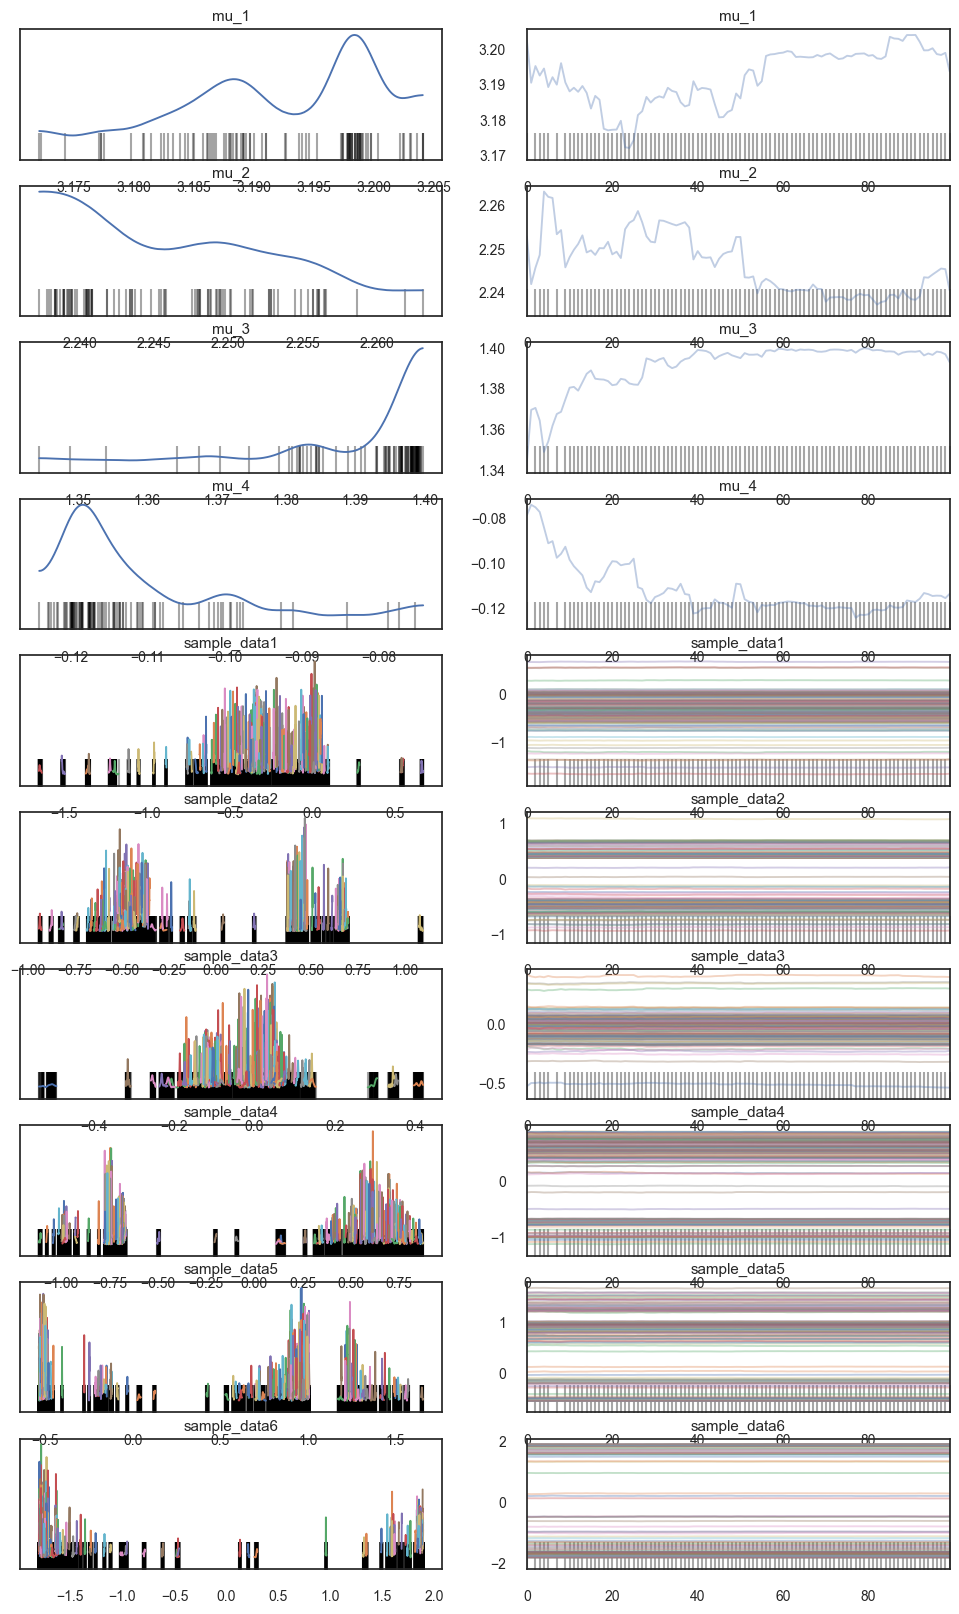

In [245]:
posterior_samples = mcmc.get_samples()
posterior_predictive = Predictive(model_test, posterior_samples)(normalised_hsi)
data = az.from_pyro(posterior=mcmc, prior=prior, posterior_predictive=posterior_predictive)
az.plot_trace(data)
plt.show()

In [246]:
posterior_samples

{'mu_1': tensor([3.2025, 3.1906, 3.1953, 3.1926, 3.1946, 3.1893, 3.1921, 3.1900, 3.1961,
         3.1906, 3.1881, 3.1891, 3.1880, 3.1896, 3.1877, 3.1832, 3.1868, 3.1857,
         3.1775, 3.1771, 3.1772, 3.1773, 3.1798, 3.1723, 3.1721, 3.1743, 3.1814,
         3.1825, 3.1865, 3.1849, 3.1862, 3.1867, 3.1863, 3.1891, 3.1882, 3.1879,
         3.1850, 3.1839, 3.1842, 3.1910, 3.1885, 3.1891, 3.1889, 3.1886, 3.1845,
         3.1807, 3.1808, 3.1823, 3.1828, 3.1875, 3.1861, 3.1927, 3.1943, 3.1940,
         3.1897, 3.1910, 3.1981, 3.1986, 3.1987, 3.1989, 3.1991, 3.1995, 3.1993,
         3.1978, 3.1979, 3.1978, 3.1977, 3.1978, 3.1984, 3.1980, 3.1986, 3.1988,
         3.1980, 3.1973, 3.1974, 3.1982, 3.1980, 3.1987, 3.1988, 3.1988, 3.1982,
         3.1984, 3.1974, 3.1973, 3.1980, 3.2036, 3.2031, 3.2030, 3.2024, 3.2041,
         3.2040, 3.2041, 3.2021, 3.1997, 3.1997, 3.2003, 3.1987, 3.1984, 3.1990,
         3.1938], dtype=torch.float64),
 'mu_2': tensor([2.2529, 2.2419, 2.2457, 2.2486, 2.2631, 2.26

In [247]:
mu_1_mean = posterior_samples["mu_1"].mean()
mu_2_mean = posterior_samples["mu_2"].mean()
mu_3_mean = posterior_samples["mu_3"].mean()
mu_4_mean = posterior_samples["mu_4"].mean()

In [248]:
# loc_mean_posterior, loc_cov_posterior =[], []
# for key, values in posterior_samples.items():
#     print(key)
#     if key == "sample_data":
#         mean = values.mean(dim=0)
#         cov = values.std(dim=0)
#         print("mean\n",mean)
#         print("cov\n", cov)
#         loc_mean_posterior.append(mean.detach().numpy())
#         loc_cov_posterior.append(cov.detach().numpy())
#     elif key == "sigma_data":
#         print("mean\n",values.mean(dim=0), "\nstd\n", values.std(dim=0))
#     else:
#         print("mean\n",values.mean(), "\nstd\n", values.std())

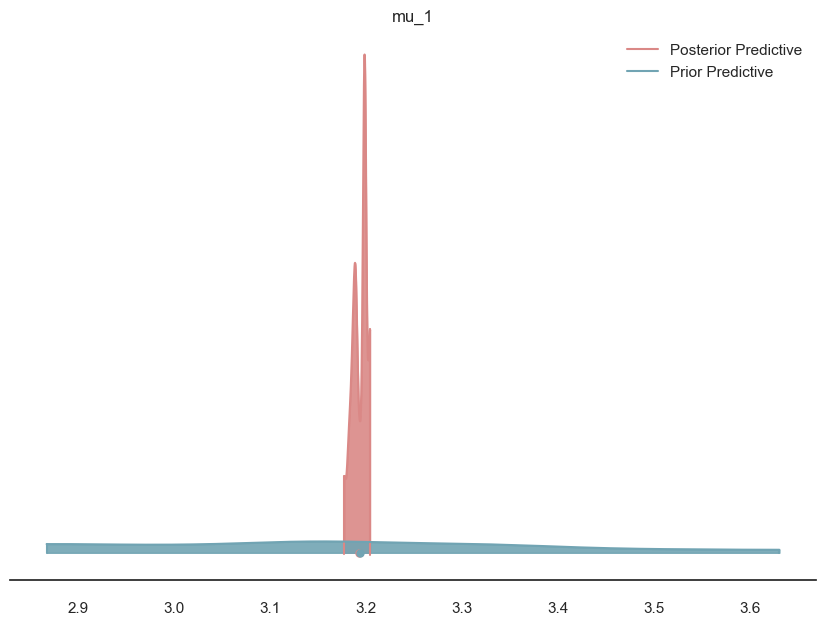

In [249]:
az.plot_density(
    data=[data.posterior, data.prior],
    shade=.9,
    var_names=['mu_1'],
    data_labels=["Posterior Predictive", "Prior Predictive"],
    colors=[default_red, default_blue],
)
plt.show()

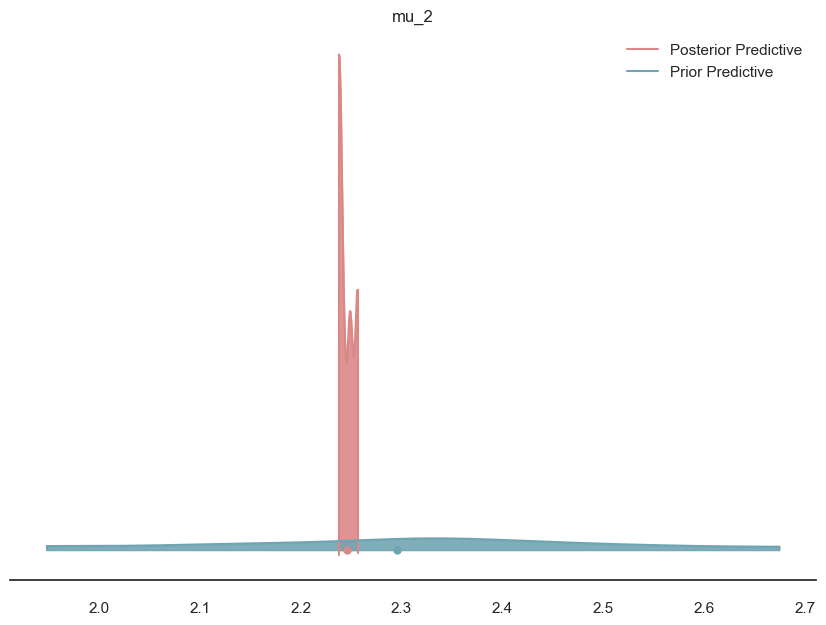

In [250]:
az.plot_density(
    data=[data.posterior, data.prior],
    shade=.9,
    var_names=['mu_2'],
    data_labels=["Posterior Predictive", "Prior Predictive"],
    colors=[default_red, default_blue],
)
plt.show()

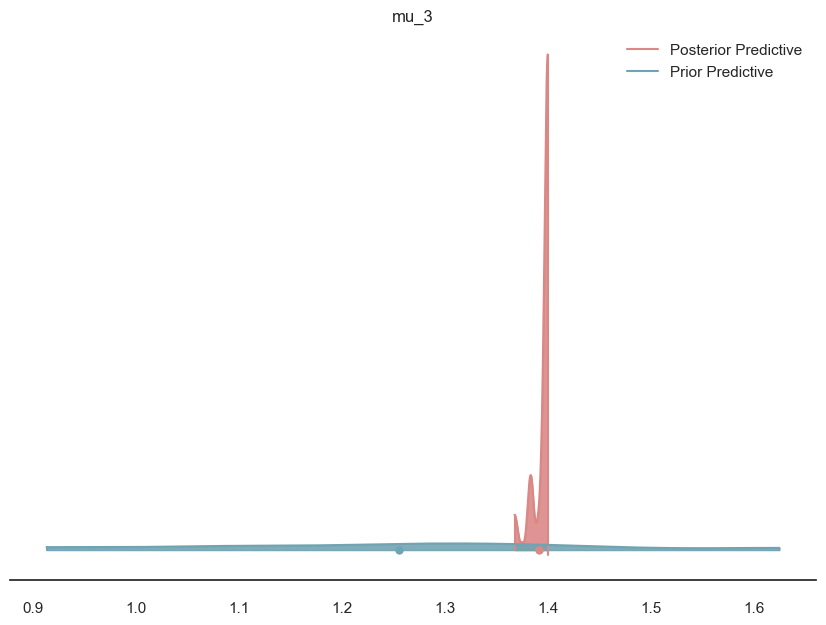

In [251]:
az.plot_density(
    data=[data.posterior, data.prior],
    shade=.9,
    var_names=['mu_3'],
    data_labels=["Posterior Predictive", "Prior Predictive"],
    colors=[default_red, default_blue],
)
plt.show()

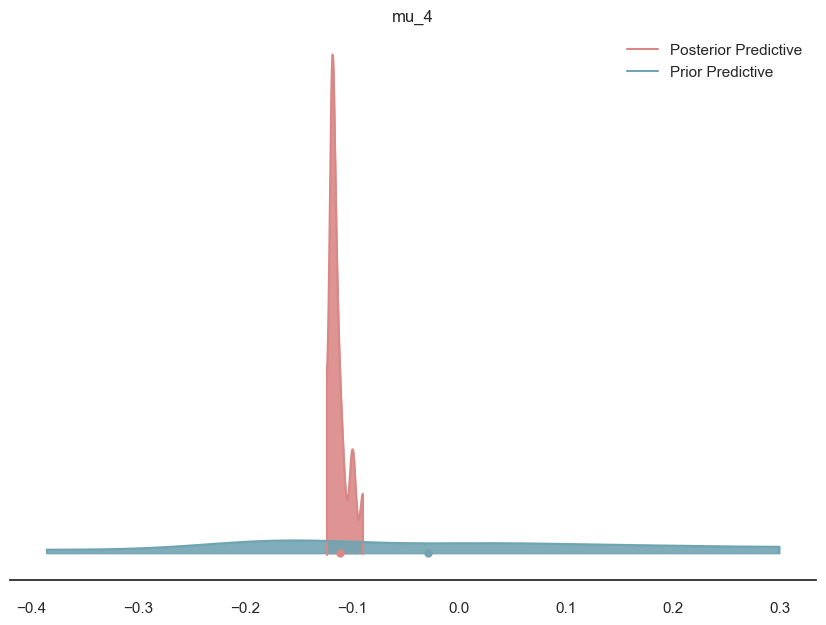

In [252]:
az.plot_density(
    data=[data.posterior, data.prior],
    shade=.9,
    var_names=['mu_4'],
    data_labels=["Posterior Predictive", "Prior Predictive"],
    colors=[default_red, default_blue],
)
plt.show()

Condition number: 1557.346663513197.


/Users/deepprakashravi/miniforge3/envs/gempy3/lib/python3.10/site-packages/gempy_viewer/API/_plot_2d_API.py:172: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  p.fig.show()


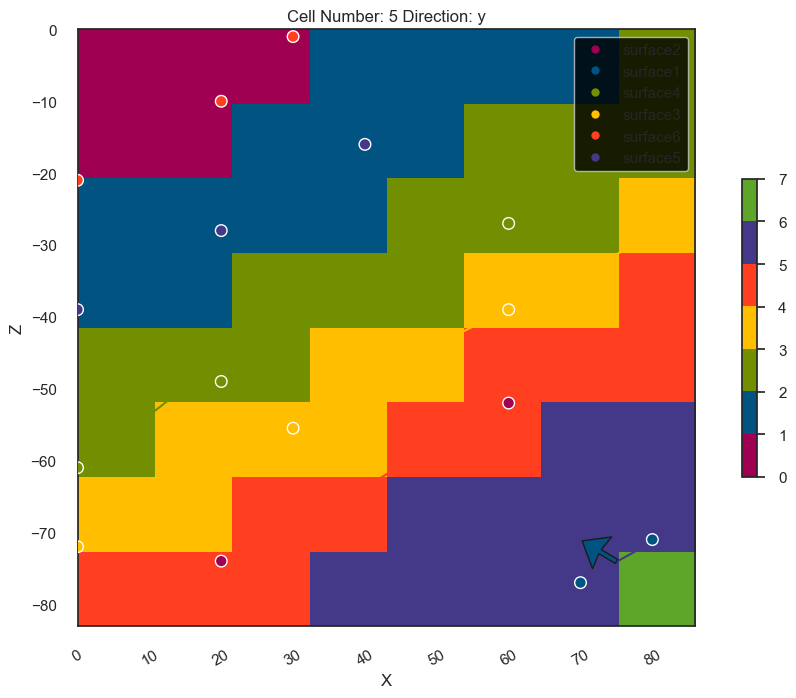

In [253]:
# # Update the model with the new top layer's location
interpolation_input = geo_model_test.interpolation_input
interpolation_input.surface_points.sp_coords = torch.index_put(
    interpolation_input.surface_points.sp_coords,
    (torch.tensor([11]), torch.tensor([2])),
    posterior_samples["mu_1"].mean()
)
interpolation_input.surface_points.sp_coords = torch.index_put(
    interpolation_input.surface_points.sp_coords,
    (torch.tensor([14]), torch.tensor([2])),
    posterior_samples["mu_2"].mean()
)

interpolation_input.surface_points.sp_coords = torch.index_put(
        interpolation_input.surface_points.sp_coords,
        (torch.tensor([5]), torch.tensor([2])),
        posterior_samples["mu_3"].mean()
    )
interpolation_input.surface_points.sp_coords = torch.index_put(
        interpolation_input.surface_points.sp_coords,
        (torch.tensor([0]), torch.tensor([2])),
        posterior_samples["mu_4"].mean()
    )
    
#print("interpolation_input",interpolation_input.surface_points.sp_coords)

# # Compute the geological model
geo_model_test.solutions = gempy_engine.compute_model(
    interpolation_input=interpolation_input,
    options=geo_model_test.interpolation_options,
    data_descriptor=geo_model_test.input_data_descriptor,
    geophysics_input=geo_model_test.geophysics_input,
)

gpv.plot_2d(geo_model_test, cell_number=5, legend='force')

In [254]:
sp_coords_copy_test2 =interpolation_input.surface_points.sp_coords
sp_coords_copy_test2

tensor([[-2.7500,  0.0000, -0.1119],
        [-0.7500,  0.0000,  1.1000],
        [-0.2500,  0.0000, -0.1500],
        [ 0.2500,  0.0000,  0.1500],
        [-3.7500,  0.0000,  0.6500],
        [-2.7500,  0.0000,  1.3912],
        [-0.7500,  0.0000,  2.3500],
        [-3.7500,  0.0000,  0.1000],
        [-2.2500,  0.0000,  0.9250],
        [-0.7500,  0.0000,  1.7500],
        [-3.7500,  0.0000,  2.6500],
        [-2.7500,  0.0000,  3.1921],
        [-2.2500,  0.0000,  3.6500],
        [-3.7500,  0.0000,  1.7500],
        [-2.7500,  0.0000,  2.2464],
        [-1.7500,  0.0000,  2.9000]], dtype=torch.float64,
       grad_fn=<IndexPutBackward0>)

In [255]:
sp_cord= geo_model_test.transform.apply_inverse(sp_coords_copy_test2.detach().numpy())
sp_cord

array([[ 20.        ,   0.        , -76.23835137],
       [ 60.        ,   0.        , -52.        ],
       [ 70.        ,   0.        , -77.        ],
       [ 80.        ,   0.        , -71.        ],
       [  0.        ,   0.        , -61.        ],
       [ 20.        ,   0.        , -46.17609475],
       [ 60.        ,   0.        , -27.        ],
       [  0.        ,   0.        , -72.        ],
       [ 30.        ,   0.        , -55.5       ],
       [ 60.        ,   0.        , -39.        ],
       [  0.        ,   0.        , -21.        ],
       [ 20.        ,   0.        , -10.15786579],
       [ 30.        ,   0.        ,  -1.        ],
       [  0.        ,   0.        , -39.        ],
       [ 20.        ,   0.        , -29.07262173],
       [ 40.        ,   0.        , -16.        ]])

Active grids: ['custom']
Setting Backend To: AvailableBackends.numpy


/Users/deepprakashravi/miniforge3/envs/gempy3/lib/python3.10/site-packages/gempy/core/data/geo_model.py:164: UserWarning: You are using refinement and passing a regular grid. The resolution of the regular grid will be overwritten
  warnings.warn(
/Users/deepprakashravi/miniforge3/envs/gempy3/lib/python3.10/site-packages/gempy_viewer/API/_plot_2d_API.py:172: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  p.fig.show()


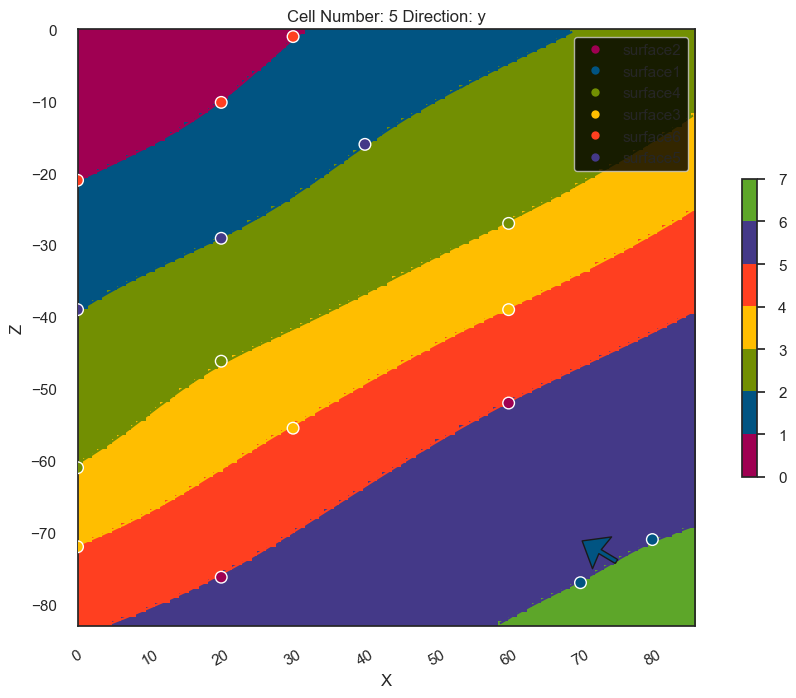

In [256]:
geo_model_test_post = gp.create_geomodel(
    project_name='Gempy_abc_Test_post',
    extent=[0, 86, -10, 10, -83, 0],
    resolution=[86,20,83],
    refinement=7,
    structural_frame= gp.data.StructuralFrame.initialize_default_structure()
    )

gp.add_surface_points(
    geo_model=geo_model_test_post,
    x=[70.0, 80.0],
    y=[0.0, 0.0],
    z=[-77.0, -71.0],
    elements_names=['surface1', 'surface1']
)

gp.add_orientations(
    geo_model=geo_model_test_post,
    x=[75],
    y=[0.0],
    z=[-74],
    elements_names=['surface1'],
    pole_vector=[[-5/3, 0, 1]]
)
geo_model_test_post.update_transform(gp.data.GlobalAnisotropy.NONE)

element2 = gp.data.StructuralElement(
    name='surface2',
    color=next(geo_model_test_post.structural_frame.color_generator),
    surface_points=gp.data.SurfacePointsTable.from_arrays(
        x=np.array([20.0, 60.0]),
        y=np.array([0.0, 0.0]),
        z=np.array([sp_cord[0,2], -52]),
        names='surface2'
    ),
    orientations=gp.data.OrientationsTable.initialize_empty()
)

geo_model_test_post.structural_frame.structural_groups[0].append_element(element2)

element3 = gp.data.StructuralElement(
    name='surface3',
    color=next(geo_model_test_post.structural_frame.color_generator),
    surface_points=gp.data.SurfacePointsTable.from_arrays(
        x=np.array([0.0, 30.0, 60]),
        y=np.array([0.0, 0.0,0.0]),
        z=np.array([-72, -55.5, -39]),
        names='surface3'
    ),
    orientations=gp.data.OrientationsTable.initialize_empty()
)

geo_model_test_post.structural_frame.structural_groups[0].append_element(element3)

element4 = gp.data.StructuralElement(
    name='surface4',
    color=next(geo_model_test_post.structural_frame.color_generator),
    surface_points=gp.data.SurfacePointsTable.from_arrays(
        x=np.array([0.0, 20.0, 60]),
        y=np.array([0.0, 0.0,0.0]),
        z=np.array([-61, sp_cord[5,2], -27]),
        names='surface4'
    ),
    orientations=gp.data.OrientationsTable.initialize_empty()
)

geo_model_test_post.structural_frame.structural_groups[0].append_element(element4)

element5 = gp.data.StructuralElement(
    name='surface5',
    color=next(geo_model_test_post.structural_frame.color_generator),
    surface_points=gp.data.SurfacePointsTable.from_arrays(
        x=np.array([0.0, 20, 40]),
        y=np.array([0.0, 0.0, 0.0]),
        z=np.array([-39, sp_cord[14,2], -16]),
        names='surface5'
    ),
    orientations=gp.data.OrientationsTable.initialize_empty()
)

geo_model_test_post.structural_frame.structural_groups[0].append_element(element5)

element6 = gp.data.StructuralElement(
    name='surface6',
    color=next(geo_model_test_post.structural_frame.color_generator),
    surface_points=gp.data.SurfacePointsTable.from_arrays(
        x=np.array([0.0, 20.0,30]),
        y=np.array([0.0, 0.0, 0.0]),
        z=np.array([-21, sp_cord[11,2], -1]),
        names='surface6'
    ),
    orientations=gp.data.OrientationsTable.initialize_empty()
)

geo_model_test_post.structural_frame.structural_groups[0].append_element(element6)

geo_model_test_post.structural_frame.structural_groups[0].elements[0], geo_model_test_post.structural_frame.structural_groups[0].elements[1],\
geo_model_test_post.structural_frame.structural_groups[0].elements[2], geo_model_test_post.structural_frame.structural_groups[0].elements[3],\
geo_model_test_post.structural_frame.structural_groups[0].elements[4], geo_model_test_post.structural_frame.structural_groups[0].elements[5] = \
geo_model_test_post.structural_frame.structural_groups[0].elements[1], geo_model_test_post.structural_frame.structural_groups[0].elements[0],\
geo_model_test_post.structural_frame.structural_groups[0].elements[3], geo_model_test_post.structural_frame.structural_groups[0].elements[2],\
geo_model_test_post.structural_frame.structural_groups[0].elements[5], geo_model_test_post.structural_frame.structural_groups[0].elements[4]  


gp.set_custom_grid(geo_model_test_post.grid, xyz_coord=xyz_coord)
gp.compute_model(geo_model_test_post)
gpv.plot_2d(geo_model_test_post, cell_number=5, legend='force')


In [257]:
custom_grid_values_post = geo_model_test_post.solutions.octrees_output[0].last_output_center.custom_grid_values

In [258]:
custom_grid_values_post

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 6., 6., 6., 6., 6.])

In [259]:
y_obs_label

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 4., 4., 4., 4., 4., 4., 4., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
        6., 6., 6., 6., 6.], dtype=torch.float64)

In [260]:
torch.sum(torch.tensor(custom_grid_values_post, dtype=torch.float64) != y_obs_label)/ len(y_obs_label)

tensor(0.0339)